In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,916 kB of archives.
After this operation, 12.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew-dev amd64 2.0.0-5 [120 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libosmesa6 amd64 20.0.8-

In [2]:
!pip install gym

In [3]:
!pip install torch torchvision torchaudio

In [4]:
!pip install free-mujoco-py

     |████████████████████████████████| 14.1 MB 2.6 MB/s 
     |████████████████████████████████| 3.3 MB 47.0 MB/s 
     |████████████████████████████████| 203 kB 63.9 MB/s 
     |████████████████████████████████| 4.3 MB 41.6 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
# import the packages
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
from gym.wrappers import FilterObservation, FlattenObservation
import time
from tqdm import tqdm

In [6]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# learn about the environment - FetchReach-v1 is OpenAI Gym enivironment
env = gym.make('FetchReach-v1')
env.reset()

# run the agent for 200 iterations in the environment
for i in range(200):
    # do not use env.render() with jupyter notebook
    # env.render() 
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuexten

In [8]:
# function to unpack observation from gym environment
def unpackObs(obs):
    return  obs['achieved_goal'], \
            obs['desired_goal'],\
            np.concatenate((obs['observation'], \
            obs['desired_goal'])), \
            np.concatenate((obs['observation'], \
            obs['achieved_goal']))

In [9]:
# check and test
unpackObs(env.reset())
assert(len(unpackObs(env.reset())) == 4)

In [10]:
# replay buffer

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### DDPG Architecture

The deterministic policy gradients are used to train the actor network. DDPG is off-policy and combines some methods used for Deep Q Networks (DQN) like target network updating and an experience replay buffer. Unlike DQN, DDPG can be used in the continuous action space. In this example, we train a DDPG network on continuous Lunar Lander.

In [11]:
# Creat Actor NN
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, action_max):
        super(ActorNet, self).__init__()
        self.input_layer = nn.LayerNorm(state_size)
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_1n = nn.LayerNorm(hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_layer_2n = nn.LayerNorm(hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
#         nn.init.uniform_(self.dense_layer_1.weight)
#         nn.init.uniform_(self.dense_layer_2.weight)
        nn.init.uniform_(self.output.weight,-0.003,0.003)
        
        self.action_max = action_max
     
    
    def forward(self, x):
#         x = torch.clamp(x,-1.0,1.0)
        x = self.input_layer(x)
        x = F.relu(self.dense_layer_1n(self.dense_layer_1(x)))
        x = F.relu(self.dense_layer_2n(self.dense_layer_2(x)))
        return torch.tanh(self.output(x)) * self.action_max

# create ctitic NN
class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.input_layer = nn.LayerNorm(state_size+action_size)
        self.dense_layer_1 = nn.Linear(state_size+action_size, hidden_size)
        self.dense_layer_1n = nn.LayerNorm(hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_layer_2n = nn.LayerNorm(hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        
#         nn.init.uniform_(self.dense_layer_1.weight)
#         nn.init.uniform_(self.dense_layer_2.weight)
        nn.init.uniform_(self.output.weight,-0.003,0.003)
        

    def forward(self, x, a):
#         x = torch.clamp(x,-1.0,1.0)
        x = self.input_layer(torch.cat((x,a),dim=1))
        x = F.relu(self.dense_layer_1n(self.dense_layer_1(x)))
        x = F.relu(self.dense_layer_2n(self.dense_layer_2(x)))
        return self.output(x)

In [12]:
# create DDPG Class

class DDPGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount,
                 min_action, max_action, exploration_noise):
        self.action_size = action_size
        self.actor = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.actor_target = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        
        self.critic = CriticNet(state_size, action_size, hidden_size).to(device)
        self.critic_target = CriticNet(state_size, action_size, hidden_size).to(device)
        
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action = self.actor(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action = action.detach().cpu().numpy()
            #in DDPG add noise for exploration
            action = (action + np.random.normal(0., self.exploration_noise, 
                       size=self.action_size)).clip(self.min_action, self.max_action)   
        return action

    
    def train(self, replay_buffer, batch_size):
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and use GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.FloatTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        flipped_done_batch = torch.FloatTensor(d).to(device) #already flipped done when adding to replay buffer

        # get target net target values
        with torch.no_grad():
            target_action = self.actor_target(next_state_batch).view(batch_size,-1)
            target_v = reward_batch + flipped_done_batch*self.discount*self.critic_target(next_state_batch, 
                                                                           target_action).view(batch_size,-1)
        # get train net values for updating the critic network    
        critic_v = self.critic(state_batch, action_batch).view(batch_size,-1)
        
        # train critic
        critic_loss = nn.MSELoss()(critic_v, target_v)
#         critic_loss = F.smooth_l1_loss(critic_v, target_v)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        # train actor
        train_action = self.actor(state_batch)
        actor_loss = -torch.mean(self.critic(state_batch,train_action))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
        
        
    def update_target_network_soft(self, update_tau=0.001):
        # soft target network update: update target networks with mixture of train and target
        for target_var, var in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)
            
        for target_var, var in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)

In [16]:
# Initialize env and set up hyperparameters
env = gym.make('FetchReach-v1')
env = FlattenObservation(FilterObservation(env, ['desired_goal','observation']))
# obs = unpackObs(env.reset())
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]
env.close()

env = gym.make('FetchReach-v1')

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
# create replay buffer
replay_size = 1000000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
# start_training_after = 50 # start training NN after this many timesteps
# update_target_every = 1 # update target network every this steps
tau = 0.001
episodes = 2000   
discount = 0.99
batch_size = 64
exploration_noise = 0.0
hidden_size = 256
actor_lr = 0.0001
critic_lr = 0.001
reward_scale = 1

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [17]:
stats_rewards_list = [] # store stats for plotting in this
# stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

t1 = time.time()
for ep in tqdm(range(episodes)):
    
    achieved_g,desired_g,state,state_prime = unpackObs(env.reset())

    # train in each episode until episode is done
    while True:
        timesteps += 1
        episode_length += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        # enter action into the env
        observation, reward, done, info = env.step(action)
        total_reward += reward
        
        achieved_g,desired_g,next_state,next_state_prime = unpackObs(observation)
        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale,1-float(done)))
        
        # HER experience
        substitute_g = achieved_g.copy()
        substitute_reward = env.compute_reward(achieved_g, substitute_g, info)
        replay_buffer.add((state_prime, next_state_prime, action, substitute_reward*reward_scale,0))
        
        
        # train the agent
        if len(replay_buffer.storage) > batch_size:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft()

            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
             
    
            print('Episode: {}'.format(ep),
                'Timestep: {}'.format(timesteps),
                'Total reward: {:.1f}'.format(total_reward),
                'Episode length: {:.1f}'.format(episode_length),
                'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
            stats_actor_loss, stats_critic_loss = [], []
            total_reward = 0
            episode_length = 0 
            break
        
        state = next_state

t2 = time.time()

  0%|          | 1/2000 [00:00<10:30,  3.17it/s]

Episode: 0 Timestep: 50 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4726 Critic Loss: 0.2610


  0%|          | 2/2000 [00:00<16:45,  1.99it/s]

Episode: 1 Timestep: 100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3926 Critic Loss: 0.1053


  0%|          | 3/2000 [00:01<18:31,  1.80it/s]

Episode: 2 Timestep: 150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3624 Critic Loss: 0.0153


  0%|          | 4/2000 [00:02<19:22,  1.72it/s]

Episode: 3 Timestep: 200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4331 Critic Loss: 0.0168


  0%|          | 5/2000 [00:02<19:40,  1.69it/s]

Episode: 4 Timestep: 250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4295 Critic Loss: 0.0176


  0%|          | 6/2000 [00:03<20:14,  1.64it/s]

Episode: 5 Timestep: 300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4414 Critic Loss: 0.0442


  0%|          | 7/2000 [00:04<21:05,  1.57it/s]

Episode: 6 Timestep: 350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4422 Critic Loss: 0.0232


  0%|          | 8/2000 [00:04<21:54,  1.52it/s]

Episode: 7 Timestep: 400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4658 Critic Loss: 0.0254


  0%|          | 9/2000 [00:05<22:05,  1.50it/s]

Episode: 8 Timestep: 450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4505 Critic Loss: 0.0243


  0%|          | 10/2000 [00:06<22:06,  1.50it/s]

Episode: 9 Timestep: 500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3880 Critic Loss: 0.0205


  1%|          | 11/2000 [00:06<21:52,  1.52it/s]

Episode: 10 Timestep: 550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4549 Critic Loss: 0.0209


  1%|          | 12/2000 [00:07<21:48,  1.52it/s]

Episode: 11 Timestep: 600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5189 Critic Loss: 0.0206


  1%|          | 13/2000 [00:08<21:22,  1.55it/s]

Episode: 12 Timestep: 650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5254 Critic Loss: 0.0195


  1%|          | 14/2000 [00:08<21:09,  1.56it/s]

Episode: 13 Timestep: 700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5375 Critic Loss: 0.0176


  1%|          | 15/2000 [00:09<20:55,  1.58it/s]

Episode: 14 Timestep: 750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5926 Critic Loss: 0.0157


  1%|          | 16/2000 [00:09<20:24,  1.62it/s]

Episode: 15 Timestep: 800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5332 Critic Loss: 0.0214


  1%|          | 17/2000 [00:10<20:06,  1.64it/s]

Episode: 16 Timestep: 850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5132 Critic Loss: 0.0184


  1%|          | 18/2000 [00:11<20:02,  1.65it/s]

Episode: 17 Timestep: 900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5114 Critic Loss: 0.0165


  1%|          | 19/2000 [00:11<19:58,  1.65it/s]

Episode: 18 Timestep: 950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5355 Critic Loss: 0.0169


  1%|          | 20/2000 [00:12<19:56,  1.65it/s]

Episode: 19 Timestep: 1000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5000 Critic Loss: 0.0139


  1%|          | 21/2000 [00:12<19:44,  1.67it/s]

Episode: 20 Timestep: 1050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5414 Critic Loss: 0.0145


  1%|          | 22/2000 [00:13<20:00,  1.65it/s]

Episode: 21 Timestep: 1100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5786 Critic Loss: 0.0099


  1%|          | 23/2000 [00:14<20:14,  1.63it/s]

Episode: 22 Timestep: 1150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5876 Critic Loss: 0.0215


  1%|          | 24/2000 [00:14<20:07,  1.64it/s]

Episode: 23 Timestep: 1200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5817 Critic Loss: 0.0203


  1%|▏         | 25/2000 [00:15<20:08,  1.63it/s]

Episode: 24 Timestep: 1250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6217 Critic Loss: 0.0178


  1%|▏         | 26/2000 [00:16<20:20,  1.62it/s]

Episode: 25 Timestep: 1300 Total reward: -48.0 Episode length: 50.0 Actor Loss: 0.6068 Critic Loss: 0.0142


  1%|▏         | 27/2000 [00:16<20:27,  1.61it/s]

Episode: 26 Timestep: 1350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6272 Critic Loss: 0.0152


  1%|▏         | 28/2000 [00:17<20:38,  1.59it/s]

Episode: 27 Timestep: 1400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5132 Critic Loss: 0.0223


  1%|▏         | 29/2000 [00:17<20:24,  1.61it/s]

Episode: 28 Timestep: 1450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5621 Critic Loss: 0.0259


  2%|▏         | 30/2000 [00:18<20:24,  1.61it/s]

Episode: 29 Timestep: 1500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5989 Critic Loss: 0.0156


  2%|▏         | 31/2000 [00:19<20:29,  1.60it/s]

Episode: 30 Timestep: 1550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6305 Critic Loss: 0.0186


  2%|▏         | 32/2000 [00:19<20:26,  1.60it/s]

Episode: 31 Timestep: 1600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6410 Critic Loss: 0.0123


  2%|▏         | 33/2000 [00:20<20:22,  1.61it/s]

Episode: 32 Timestep: 1650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6913 Critic Loss: 0.0170


  2%|▏         | 34/2000 [00:21<20:21,  1.61it/s]

Episode: 33 Timestep: 1700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6830 Critic Loss: 0.0167


  2%|▏         | 35/2000 [00:21<20:25,  1.60it/s]

Episode: 34 Timestep: 1750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7734 Critic Loss: 0.0138


  2%|▏         | 36/2000 [00:22<20:30,  1.60it/s]

Episode: 35 Timestep: 1800 Total reward: -49.0 Episode length: 50.0 Actor Loss: 0.7641 Critic Loss: 0.0152


  2%|▏         | 37/2000 [00:22<20:24,  1.60it/s]

Episode: 36 Timestep: 1850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8068 Critic Loss: 0.0136


  2%|▏         | 38/2000 [00:23<20:26,  1.60it/s]

Episode: 37 Timestep: 1900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8230 Critic Loss: 0.0162


  2%|▏         | 39/2000 [00:24<20:25,  1.60it/s]

Episode: 38 Timestep: 1950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8472 Critic Loss: 0.0182


  2%|▏         | 40/2000 [00:24<20:03,  1.63it/s]

Episode: 39 Timestep: 2000 Total reward: -45.0 Episode length: 50.0 Actor Loss: 0.8123 Critic Loss: 0.0166


  2%|▏         | 41/2000 [00:25<19:51,  1.64it/s]

Episode: 40 Timestep: 2050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8064 Critic Loss: 0.0165


  2%|▏         | 42/2000 [00:25<19:40,  1.66it/s]

Episode: 41 Timestep: 2100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6881 Critic Loss: 0.0228


  2%|▏         | 43/2000 [00:26<19:43,  1.65it/s]

Episode: 42 Timestep: 2150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6736 Critic Loss: 0.0222


  2%|▏         | 44/2000 [00:27<19:43,  1.65it/s]

Episode: 43 Timestep: 2200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6575 Critic Loss: 0.0208


  2%|▏         | 45/2000 [00:27<19:34,  1.67it/s]

Episode: 44 Timestep: 2250 Total reward: -26.0 Episode length: 50.0 Actor Loss: 0.6351 Critic Loss: 0.0267


  2%|▏         | 46/2000 [00:28<19:41,  1.65it/s]

Episode: 45 Timestep: 2300 Total reward: -27.0 Episode length: 50.0 Actor Loss: 0.6644 Critic Loss: 0.0320


  2%|▏         | 47/2000 [00:28<19:46,  1.65it/s]

Episode: 46 Timestep: 2350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7278 Critic Loss: 0.0282


  2%|▏         | 48/2000 [00:29<19:48,  1.64it/s]

Episode: 47 Timestep: 2400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7182 Critic Loss: 0.0341


  2%|▏         | 49/2000 [00:30<19:36,  1.66it/s]

Episode: 48 Timestep: 2450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8528 Critic Loss: 0.0238


  2%|▎         | 50/2000 [00:30<19:27,  1.67it/s]

Episode: 49 Timestep: 2500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8438 Critic Loss: 0.0282


  3%|▎         | 51/2000 [00:31<19:26,  1.67it/s]

Episode: 50 Timestep: 2550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9184 Critic Loss: 0.0267


  3%|▎         | 52/2000 [00:31<19:28,  1.67it/s]

Episode: 51 Timestep: 2600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8599 Critic Loss: 0.0248


  3%|▎         | 53/2000 [00:32<19:34,  1.66it/s]

Episode: 52 Timestep: 2650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8253 Critic Loss: 0.0343


  3%|▎         | 54/2000 [00:33<19:34,  1.66it/s]

Episode: 53 Timestep: 2700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8568 Critic Loss: 0.0334


  3%|▎         | 55/2000 [00:33<19:51,  1.63it/s]

Episode: 54 Timestep: 2750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9005 Critic Loss: 0.0259


  3%|▎         | 56/2000 [00:34<20:03,  1.62it/s]

Episode: 55 Timestep: 2800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9587 Critic Loss: 0.0291


  3%|▎         | 57/2000 [00:35<19:39,  1.65it/s]

Episode: 56 Timestep: 2850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9996 Critic Loss: 0.0297


  3%|▎         | 58/2000 [00:35<19:38,  1.65it/s]

Episode: 57 Timestep: 2900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0153 Critic Loss: 0.0265


  3%|▎         | 59/2000 [00:36<19:36,  1.65it/s]

Episode: 58 Timestep: 2950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0005 Critic Loss: 0.0244


  3%|▎         | 60/2000 [00:36<19:29,  1.66it/s]

Episode: 59 Timestep: 3000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0118 Critic Loss: 0.0251


  3%|▎         | 61/2000 [00:37<19:24,  1.66it/s]

Episode: 60 Timestep: 3050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0247 Critic Loss: 0.0326


  3%|▎         | 62/2000 [00:37<19:10,  1.68it/s]

Episode: 61 Timestep: 3100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0807 Critic Loss: 0.0308


  3%|▎         | 63/2000 [00:38<19:13,  1.68it/s]

Episode: 62 Timestep: 3150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0790 Critic Loss: 0.0334


  3%|▎         | 64/2000 [00:39<19:05,  1.69it/s]

Episode: 63 Timestep: 3200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1068 Critic Loss: 0.0408


  3%|▎         | 65/2000 [00:39<19:06,  1.69it/s]

Episode: 64 Timestep: 3250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0808 Critic Loss: 0.0510


  3%|▎         | 66/2000 [00:40<19:05,  1.69it/s]

Episode: 65 Timestep: 3300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0995 Critic Loss: 0.0316


  3%|▎         | 67/2000 [00:40<19:27,  1.66it/s]

Episode: 66 Timestep: 3350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1496 Critic Loss: 0.0366


  3%|▎         | 68/2000 [00:41<19:40,  1.64it/s]

Episode: 67 Timestep: 3400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1106 Critic Loss: 0.0336


  3%|▎         | 69/2000 [00:42<19:46,  1.63it/s]

Episode: 68 Timestep: 3450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1863 Critic Loss: 0.0358


  4%|▎         | 70/2000 [00:42<19:54,  1.62it/s]

Episode: 69 Timestep: 3500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2057 Critic Loss: 0.0529


  4%|▎         | 71/2000 [00:43<19:38,  1.64it/s]

Episode: 70 Timestep: 3550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2036 Critic Loss: 0.0371


  4%|▎         | 72/2000 [00:44<19:52,  1.62it/s]

Episode: 71 Timestep: 3600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2382 Critic Loss: 0.0413


  4%|▎         | 73/2000 [00:44<20:08,  1.59it/s]

Episode: 72 Timestep: 3650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2478 Critic Loss: 0.0386


  4%|▎         | 74/2000 [00:45<20:18,  1.58it/s]

Episode: 73 Timestep: 3700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2758 Critic Loss: 0.0416


  4%|▍         | 75/2000 [00:45<20:08,  1.59it/s]

Episode: 74 Timestep: 3750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2825 Critic Loss: 0.0446


  4%|▍         | 76/2000 [00:46<19:59,  1.60it/s]

Episode: 75 Timestep: 3800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2878 Critic Loss: 0.0742


  4%|▍         | 77/2000 [00:47<19:51,  1.61it/s]

Episode: 76 Timestep: 3850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3567 Critic Loss: 0.0584


  4%|▍         | 78/2000 [00:47<19:38,  1.63it/s]

Episode: 77 Timestep: 3900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3371 Critic Loss: 0.0557


  4%|▍         | 79/2000 [00:48<19:20,  1.66it/s]

Episode: 78 Timestep: 3950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4090 Critic Loss: 0.0507


  4%|▍         | 80/2000 [00:49<19:28,  1.64it/s]

Episode: 79 Timestep: 4000 Total reward: -46.0 Episode length: 50.0 Actor Loss: 1.3816 Critic Loss: 0.0688


  4%|▍         | 81/2000 [00:49<19:21,  1.65it/s]

Episode: 80 Timestep: 4050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4562 Critic Loss: 0.0544


  4%|▍         | 82/2000 [00:50<19:41,  1.62it/s]

Episode: 81 Timestep: 4100 Total reward: -49.0 Episode length: 50.0 Actor Loss: 1.4699 Critic Loss: 0.0755


  4%|▍         | 83/2000 [00:50<19:48,  1.61it/s]

Episode: 82 Timestep: 4150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4574 Critic Loss: 0.0348


  4%|▍         | 84/2000 [00:51<19:41,  1.62it/s]

Episode: 83 Timestep: 4200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.5172 Critic Loss: 0.0628


  4%|▍         | 85/2000 [00:52<19:48,  1.61it/s]

Episode: 84 Timestep: 4250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4612 Critic Loss: 0.0605


  4%|▍         | 86/2000 [00:52<19:49,  1.61it/s]

Episode: 85 Timestep: 4300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4888 Critic Loss: 0.0764


  4%|▍         | 87/2000 [00:53<19:46,  1.61it/s]

Episode: 86 Timestep: 4350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4692 Critic Loss: 0.0714


  4%|▍         | 88/2000 [00:53<19:39,  1.62it/s]

Episode: 87 Timestep: 4400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.5508 Critic Loss: 0.0483


  4%|▍         | 89/2000 [00:54<19:39,  1.62it/s]

Episode: 88 Timestep: 4450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6139 Critic Loss: 0.0777


  4%|▍         | 90/2000 [00:55<19:51,  1.60it/s]

Episode: 89 Timestep: 4500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6260 Critic Loss: 0.0828


  5%|▍         | 91/2000 [00:55<20:02,  1.59it/s]

Episode: 90 Timestep: 4550 Total reward: -48.0 Episode length: 50.0 Actor Loss: 1.5908 Critic Loss: 0.0623


  5%|▍         | 92/2000 [00:56<20:03,  1.59it/s]

Episode: 91 Timestep: 4600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6408 Critic Loss: 0.0705


  5%|▍         | 93/2000 [00:57<20:10,  1.58it/s]

Episode: 92 Timestep: 4650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7102 Critic Loss: 0.0813


  5%|▍         | 94/2000 [00:57<19:59,  1.59it/s]

Episode: 93 Timestep: 4700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6956 Critic Loss: 0.1017


  5%|▍         | 95/2000 [00:58<20:02,  1.58it/s]

Episode: 94 Timestep: 4750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6681 Critic Loss: 0.0908


  5%|▍         | 96/2000 [00:59<20:05,  1.58it/s]

Episode: 95 Timestep: 4800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7548 Critic Loss: 0.0676


  5%|▍         | 97/2000 [00:59<19:53,  1.59it/s]

Episode: 96 Timestep: 4850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8025 Critic Loss: 0.0933


  5%|▍         | 98/2000 [01:00<19:55,  1.59it/s]

Episode: 97 Timestep: 4900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7969 Critic Loss: 0.0776


  5%|▍         | 99/2000 [01:00<19:55,  1.59it/s]

Episode: 98 Timestep: 4950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7832 Critic Loss: 0.0942


  5%|▌         | 100/2000 [01:01<19:59,  1.58it/s]

Episode: 99 Timestep: 5000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8475 Critic Loss: 0.0948


  5%|▌         | 101/2000 [01:02<20:01,  1.58it/s]

Episode: 100 Timestep: 5050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8656 Critic Loss: 0.0882


  5%|▌         | 102/2000 [01:02<19:49,  1.60it/s]

Episode: 101 Timestep: 5100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8849 Critic Loss: 0.1002


  5%|▌         | 103/2000 [01:03<19:53,  1.59it/s]

Episode: 102 Timestep: 5150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8850 Critic Loss: 0.0844


  5%|▌         | 104/2000 [01:04<20:03,  1.58it/s]

Episode: 103 Timestep: 5200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8487 Critic Loss: 0.1056


  5%|▌         | 105/2000 [01:04<19:51,  1.59it/s]

Episode: 104 Timestep: 5250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9853 Critic Loss: 0.1026


  5%|▌         | 106/2000 [01:05<19:49,  1.59it/s]

Episode: 105 Timestep: 5300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9497 Critic Loss: 0.1162


  5%|▌         | 107/2000 [01:05<19:26,  1.62it/s]

Episode: 106 Timestep: 5350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9462 Critic Loss: 0.1433


  5%|▌         | 108/2000 [01:06<19:12,  1.64it/s]

Episode: 107 Timestep: 5400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9701 Critic Loss: 0.1269


  5%|▌         | 109/2000 [01:07<19:06,  1.65it/s]

Episode: 108 Timestep: 5450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9924 Critic Loss: 0.1131


  6%|▌         | 110/2000 [01:07<19:10,  1.64it/s]

Episode: 109 Timestep: 5500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0193 Critic Loss: 0.0870


  6%|▌         | 111/2000 [01:08<18:55,  1.66it/s]

Episode: 110 Timestep: 5550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8926 Critic Loss: 0.1210


  6%|▌         | 112/2000 [01:08<18:39,  1.69it/s]

Episode: 111 Timestep: 5600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0214 Critic Loss: 0.1593


  6%|▌         | 113/2000 [01:09<18:32,  1.70it/s]

Episode: 112 Timestep: 5650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0947 Critic Loss: 0.1567


  6%|▌         | 114/2000 [01:10<18:26,  1.70it/s]

Episode: 113 Timestep: 5700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1052 Critic Loss: 0.1072


  6%|▌         | 115/2000 [01:10<18:31,  1.70it/s]

Episode: 114 Timestep: 5750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1027 Critic Loss: 0.1174


  6%|▌         | 116/2000 [01:11<18:29,  1.70it/s]

Episode: 115 Timestep: 5800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0544 Critic Loss: 0.0811


  6%|▌         | 117/2000 [01:11<18:20,  1.71it/s]

Episode: 116 Timestep: 5850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1593 Critic Loss: 0.1665


  6%|▌         | 118/2000 [01:12<18:26,  1.70it/s]

Episode: 117 Timestep: 5900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0436 Critic Loss: 0.1205


  6%|▌         | 119/2000 [01:12<18:24,  1.70it/s]

Episode: 118 Timestep: 5950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1274 Critic Loss: 0.1358


  6%|▌         | 120/2000 [01:13<18:24,  1.70it/s]

Episode: 119 Timestep: 6000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0890 Critic Loss: 0.1314


  6%|▌         | 121/2000 [01:14<18:21,  1.71it/s]

Episode: 120 Timestep: 6050 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.1400 Critic Loss: 0.1587


  6%|▌         | 122/2000 [01:14<18:26,  1.70it/s]

Episode: 121 Timestep: 6100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1390 Critic Loss: 0.1523


  6%|▌         | 123/2000 [01:15<18:32,  1.69it/s]

Episode: 122 Timestep: 6150 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.0803 Critic Loss: 0.1101


  6%|▌         | 124/2000 [01:15<18:33,  1.68it/s]

Episode: 123 Timestep: 6200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2096 Critic Loss: 0.1046


  6%|▋         | 125/2000 [01:16<18:48,  1.66it/s]

Episode: 124 Timestep: 6250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2575 Critic Loss: 0.1951


  6%|▋         | 126/2000 [01:17<18:48,  1.66it/s]

Episode: 125 Timestep: 6300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2514 Critic Loss: 0.1874


  6%|▋         | 127/2000 [01:17<18:43,  1.67it/s]

Episode: 126 Timestep: 6350 Total reward: -45.0 Episode length: 50.0 Actor Loss: 2.2598 Critic Loss: 0.1771


  6%|▋         | 128/2000 [01:18<18:54,  1.65it/s]

Episode: 127 Timestep: 6400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2579 Critic Loss: 0.1390


  6%|▋         | 129/2000 [01:18<18:44,  1.66it/s]

Episode: 128 Timestep: 6450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2369 Critic Loss: 0.1965


  6%|▋         | 130/2000 [01:19<18:38,  1.67it/s]

Episode: 129 Timestep: 6500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2843 Critic Loss: 0.1514


  7%|▋         | 131/2000 [01:20<18:41,  1.67it/s]

Episode: 130 Timestep: 6550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3363 Critic Loss: 0.2135


  7%|▋         | 132/2000 [01:20<18:40,  1.67it/s]

Episode: 131 Timestep: 6600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2903 Critic Loss: 0.1848


  7%|▋         | 133/2000 [01:21<18:46,  1.66it/s]

Episode: 132 Timestep: 6650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3252 Critic Loss: 0.1640


  7%|▋         | 134/2000 [01:21<18:45,  1.66it/s]

Episode: 133 Timestep: 6700 Total reward: -47.0 Episode length: 50.0 Actor Loss: 2.3322 Critic Loss: 0.1351


  7%|▋         | 135/2000 [01:22<18:39,  1.67it/s]

Episode: 134 Timestep: 6750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2656 Critic Loss: 0.2500


  7%|▋         | 136/2000 [01:23<18:36,  1.67it/s]

Episode: 135 Timestep: 6800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3901 Critic Loss: 0.1574


  7%|▋         | 137/2000 [01:23<18:45,  1.66it/s]

Episode: 136 Timestep: 6850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4489 Critic Loss: 0.2227


  7%|▋         | 138/2000 [01:24<18:40,  1.66it/s]

Episode: 137 Timestep: 6900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3477 Critic Loss: 0.1625


  7%|▋         | 139/2000 [01:24<18:35,  1.67it/s]

Episode: 138 Timestep: 6950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3705 Critic Loss: 0.1876


  7%|▋         | 140/2000 [01:25<18:32,  1.67it/s]

Episode: 139 Timestep: 7000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5632 Critic Loss: 0.1976


  7%|▋         | 141/2000 [01:26<18:23,  1.68it/s]

Episode: 140 Timestep: 7050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5247 Critic Loss: 0.1842


  7%|▋         | 142/2000 [01:26<18:17,  1.69it/s]

Episode: 141 Timestep: 7100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5500 Critic Loss: 0.1713


  7%|▋         | 143/2000 [01:27<18:19,  1.69it/s]

Episode: 142 Timestep: 7150 Total reward: -32.0 Episode length: 50.0 Actor Loss: 2.5124 Critic Loss: 0.1326


  7%|▋         | 144/2000 [01:27<18:23,  1.68it/s]

Episode: 143 Timestep: 7200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5167 Critic Loss: 0.2132


  7%|▋         | 145/2000 [01:28<18:26,  1.68it/s]

Episode: 144 Timestep: 7250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4281 Critic Loss: 0.2631


  7%|▋         | 146/2000 [01:29<18:29,  1.67it/s]

Episode: 145 Timestep: 7300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4939 Critic Loss: 0.1849


  7%|▋         | 147/2000 [01:29<18:58,  1.63it/s]

Episode: 146 Timestep: 7350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5821 Critic Loss: 0.1434


  7%|▋         | 148/2000 [01:30<19:15,  1.60it/s]

Episode: 147 Timestep: 7400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6256 Critic Loss: 0.2162


  7%|▋         | 149/2000 [01:31<19:21,  1.59it/s]

Episode: 148 Timestep: 7450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6879 Critic Loss: 0.2086


  8%|▊         | 150/2000 [01:31<19:29,  1.58it/s]

Episode: 149 Timestep: 7500 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.6396 Critic Loss: 0.2427


  8%|▊         | 151/2000 [01:32<19:17,  1.60it/s]

Episode: 150 Timestep: 7550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6912 Critic Loss: 0.2752


  8%|▊         | 152/2000 [01:32<18:59,  1.62it/s]

Episode: 151 Timestep: 7600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5857 Critic Loss: 0.2698


  8%|▊         | 153/2000 [01:33<19:01,  1.62it/s]

Episode: 152 Timestep: 7650 Total reward: -49.0 Episode length: 50.0 Actor Loss: 2.6464 Critic Loss: 0.2086


  8%|▊         | 154/2000 [01:34<18:59,  1.62it/s]

Episode: 153 Timestep: 7700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6405 Critic Loss: 0.2095


  8%|▊         | 155/2000 [01:34<18:39,  1.65it/s]

Episode: 154 Timestep: 7750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8523 Critic Loss: 0.2505


  8%|▊         | 156/2000 [01:35<18:33,  1.66it/s]

Episode: 155 Timestep: 7800 Total reward: -22.0 Episode length: 50.0 Actor Loss: 2.7519 Critic Loss: 0.2941


  8%|▊         | 157/2000 [01:35<18:28,  1.66it/s]

Episode: 156 Timestep: 7850 Total reward: -36.0 Episode length: 50.0 Actor Loss: 2.6997 Critic Loss: 0.2223


  8%|▊         | 158/2000 [01:36<18:38,  1.65it/s]

Episode: 157 Timestep: 7900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7624 Critic Loss: 0.2354


  8%|▊         | 159/2000 [01:37<18:56,  1.62it/s]

Episode: 158 Timestep: 7950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7103 Critic Loss: 0.2679


  8%|▊         | 160/2000 [01:37<18:51,  1.63it/s]

Episode: 159 Timestep: 8000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7282 Critic Loss: 0.2669


  8%|▊         | 161/2000 [01:38<18:49,  1.63it/s]

Episode: 160 Timestep: 8050 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.8917 Critic Loss: 0.2504


  8%|▊         | 162/2000 [01:39<18:45,  1.63it/s]

Episode: 161 Timestep: 8100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8556 Critic Loss: 0.2646


  8%|▊         | 163/2000 [01:39<18:43,  1.64it/s]

Episode: 162 Timestep: 8150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8574 Critic Loss: 0.2100


  8%|▊         | 164/2000 [01:40<18:53,  1.62it/s]

Episode: 163 Timestep: 8200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8954 Critic Loss: 0.1940


  8%|▊         | 165/2000 [01:40<18:34,  1.65it/s]

Episode: 164 Timestep: 8250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7946 Critic Loss: 0.2428


  8%|▊         | 166/2000 [01:41<18:30,  1.65it/s]

Episode: 165 Timestep: 8300 Total reward: -48.0 Episode length: 50.0 Actor Loss: 3.0427 Critic Loss: 0.1672


  8%|▊         | 167/2000 [01:42<18:16,  1.67it/s]

Episode: 166 Timestep: 8350 Total reward: -49.0 Episode length: 50.0 Actor Loss: 2.9685 Critic Loss: 0.2697


  8%|▊         | 168/2000 [01:42<18:00,  1.69it/s]

Episode: 167 Timestep: 8400 Total reward: -43.0 Episode length: 50.0 Actor Loss: 3.0628 Critic Loss: 0.4292


  8%|▊         | 169/2000 [01:43<17:53,  1.71it/s]

Episode: 168 Timestep: 8450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9412 Critic Loss: 0.2795


  8%|▊         | 170/2000 [01:43<17:45,  1.72it/s]

Episode: 169 Timestep: 8500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9176 Critic Loss: 0.2753


  9%|▊         | 171/2000 [01:44<18:03,  1.69it/s]

Episode: 170 Timestep: 8550 Total reward: -33.0 Episode length: 50.0 Actor Loss: 3.0268 Critic Loss: 0.3136


  9%|▊         | 172/2000 [01:44<17:47,  1.71it/s]

Episode: 171 Timestep: 8600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9993 Critic Loss: 0.2254


  9%|▊         | 173/2000 [01:45<17:47,  1.71it/s]

Episode: 172 Timestep: 8650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.0567 Critic Loss: 0.2968


  9%|▊         | 174/2000 [01:46<17:46,  1.71it/s]

Episode: 173 Timestep: 8700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9905 Critic Loss: 0.2549


  9%|▉         | 175/2000 [01:46<17:33,  1.73it/s]

Episode: 174 Timestep: 8750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1452 Critic Loss: 0.2978


  9%|▉         | 176/2000 [01:47<17:25,  1.74it/s]

Episode: 175 Timestep: 8800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.0820 Critic Loss: 0.3079


  9%|▉         | 177/2000 [01:47<17:22,  1.75it/s]

Episode: 176 Timestep: 8850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1143 Critic Loss: 0.2684


  9%|▉         | 178/2000 [01:48<17:20,  1.75it/s]

Episode: 177 Timestep: 8900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1104 Critic Loss: 0.2292


  9%|▉         | 179/2000 [01:48<17:13,  1.76it/s]

Episode: 178 Timestep: 8950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1126 Critic Loss: 0.3266


  9%|▉         | 180/2000 [01:49<17:19,  1.75it/s]

Episode: 179 Timestep: 9000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9445 Critic Loss: 0.3943


  9%|▉         | 181/2000 [01:50<17:37,  1.72it/s]

Episode: 180 Timestep: 9050 Total reward: -44.0 Episode length: 50.0 Actor Loss: 3.0310 Critic Loss: 0.2495


  9%|▉         | 182/2000 [01:50<17:31,  1.73it/s]

Episode: 181 Timestep: 9100 Total reward: -44.0 Episode length: 50.0 Actor Loss: 3.2580 Critic Loss: 0.2857


  9%|▉         | 183/2000 [01:51<17:39,  1.72it/s]

Episode: 182 Timestep: 9150 Total reward: -10.0 Episode length: 50.0 Actor Loss: 3.1767 Critic Loss: 0.3749


  9%|▉         | 184/2000 [01:51<17:40,  1.71it/s]

Episode: 183 Timestep: 9200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1906 Critic Loss: 0.3007


  9%|▉         | 185/2000 [01:52<18:15,  1.66it/s]

Episode: 184 Timestep: 9250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1942 Critic Loss: 0.4349


  9%|▉         | 186/2000 [01:53<18:28,  1.64it/s]

Episode: 185 Timestep: 9300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2459 Critic Loss: 0.3834


  9%|▉         | 187/2000 [01:53<18:20,  1.65it/s]

Episode: 186 Timestep: 9350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2023 Critic Loss: 0.4665


  9%|▉         | 188/2000 [01:54<18:06,  1.67it/s]

Episode: 187 Timestep: 9400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2734 Critic Loss: 0.4251


  9%|▉         | 189/2000 [01:54<17:46,  1.70it/s]

Episode: 188 Timestep: 9450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3466 Critic Loss: 0.3618


 10%|▉         | 190/2000 [01:55<17:36,  1.71it/s]

Episode: 189 Timestep: 9500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3608 Critic Loss: 0.3097


 10%|▉         | 191/2000 [01:56<17:26,  1.73it/s]

Episode: 190 Timestep: 9550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2609 Critic Loss: 0.3544


 10%|▉         | 192/2000 [01:56<17:18,  1.74it/s]

Episode: 191 Timestep: 9600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 3.1971 Critic Loss: 0.3728


 10%|▉         | 193/2000 [01:57<17:11,  1.75it/s]

Episode: 192 Timestep: 9650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3528 Critic Loss: 0.2806


 10%|▉         | 194/2000 [01:57<17:05,  1.76it/s]

Episode: 193 Timestep: 9700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3365 Critic Loss: 0.3396


 10%|▉         | 195/2000 [01:58<17:05,  1.76it/s]

Episode: 194 Timestep: 9750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3106 Critic Loss: 0.5045


 10%|▉         | 196/2000 [01:58<16:58,  1.77it/s]

Episode: 195 Timestep: 9800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3381 Critic Loss: 0.2566


 10%|▉         | 197/2000 [01:59<17:00,  1.77it/s]

Episode: 196 Timestep: 9850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2818 Critic Loss: 0.4553


 10%|▉         | 198/2000 [01:59<17:03,  1.76it/s]

Episode: 197 Timestep: 9900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4256 Critic Loss: 0.4297


 10%|▉         | 199/2000 [02:00<17:04,  1.76it/s]

Episode: 198 Timestep: 9950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3548 Critic Loss: 0.3363


 10%|█         | 200/2000 [02:01<17:03,  1.76it/s]

Episode: 199 Timestep: 10000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2766 Critic Loss: 0.4636


 10%|█         | 201/2000 [02:01<17:07,  1.75it/s]

Episode: 200 Timestep: 10050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4701 Critic Loss: 0.3246


 10%|█         | 202/2000 [02:02<17:14,  1.74it/s]

Episode: 201 Timestep: 10100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4835 Critic Loss: 0.5170


 10%|█         | 203/2000 [02:02<17:05,  1.75it/s]

Episode: 202 Timestep: 10150 Total reward: -48.0 Episode length: 50.0 Actor Loss: 3.4015 Critic Loss: 0.3576


 10%|█         | 204/2000 [02:03<17:09,  1.74it/s]

Episode: 203 Timestep: 10200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4358 Critic Loss: 0.4359


 10%|█         | 205/2000 [02:04<17:13,  1.74it/s]

Episode: 204 Timestep: 10250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5258 Critic Loss: 0.3125


 10%|█         | 206/2000 [02:04<17:07,  1.75it/s]

Episode: 205 Timestep: 10300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4493 Critic Loss: 0.3951


 10%|█         | 207/2000 [02:05<17:10,  1.74it/s]

Episode: 206 Timestep: 10350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5535 Critic Loss: 0.3294


 10%|█         | 208/2000 [02:05<17:06,  1.75it/s]

Episode: 207 Timestep: 10400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5339 Critic Loss: 0.4194


 10%|█         | 209/2000 [02:06<17:10,  1.74it/s]

Episode: 208 Timestep: 10450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4750 Critic Loss: 0.5239


 10%|█         | 210/2000 [02:06<17:22,  1.72it/s]

Episode: 209 Timestep: 10500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6863 Critic Loss: 0.3450


 11%|█         | 211/2000 [02:07<17:22,  1.72it/s]

Episode: 210 Timestep: 10550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5397 Critic Loss: 0.4468


 11%|█         | 212/2000 [02:08<17:18,  1.72it/s]

Episode: 211 Timestep: 10600 Total reward: -40.0 Episode length: 50.0 Actor Loss: 3.6169 Critic Loss: 0.5414


 11%|█         | 213/2000 [02:08<17:18,  1.72it/s]

Episode: 212 Timestep: 10650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6202 Critic Loss: 0.6043


 11%|█         | 214/2000 [02:09<17:12,  1.73it/s]

Episode: 213 Timestep: 10700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6199 Critic Loss: 0.5217


 11%|█         | 215/2000 [02:09<17:00,  1.75it/s]

Episode: 214 Timestep: 10750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6106 Critic Loss: 0.3188


 11%|█         | 216/2000 [02:10<16:58,  1.75it/s]

Episode: 215 Timestep: 10800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5415 Critic Loss: 0.3605


 11%|█         | 217/2000 [02:10<16:52,  1.76it/s]

Episode: 216 Timestep: 10850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4861 Critic Loss: 0.3962


 11%|█         | 218/2000 [02:11<17:08,  1.73it/s]

Episode: 217 Timestep: 10900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6131 Critic Loss: 0.5150


 11%|█         | 219/2000 [02:12<16:55,  1.75it/s]

Episode: 218 Timestep: 10950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7767 Critic Loss: 0.5245


 11%|█         | 220/2000 [02:12<16:59,  1.75it/s]

Episode: 219 Timestep: 11000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6604 Critic Loss: 0.4957


 11%|█         | 221/2000 [02:13<17:00,  1.74it/s]

Episode: 220 Timestep: 11050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6494 Critic Loss: 0.5507


 11%|█         | 222/2000 [02:13<16:59,  1.74it/s]

Episode: 221 Timestep: 11100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6345 Critic Loss: 0.4567


 11%|█         | 223/2000 [02:14<17:02,  1.74it/s]

Episode: 222 Timestep: 11150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6368 Critic Loss: 0.5690


 11%|█         | 224/2000 [02:14<17:10,  1.72it/s]

Episode: 223 Timestep: 11200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7380 Critic Loss: 0.4690


 11%|█▏        | 225/2000 [02:15<17:05,  1.73it/s]

Episode: 224 Timestep: 11250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7443 Critic Loss: 0.4683


 11%|█▏        | 226/2000 [02:16<17:10,  1.72it/s]

Episode: 225 Timestep: 11300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8534 Critic Loss: 0.3907


 11%|█▏        | 227/2000 [02:16<17:00,  1.74it/s]

Episode: 226 Timestep: 11350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7277 Critic Loss: 0.4607


 11%|█▏        | 228/2000 [02:17<17:14,  1.71it/s]

Episode: 227 Timestep: 11400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8060 Critic Loss: 0.3776


 11%|█▏        | 229/2000 [02:17<17:11,  1.72it/s]

Episode: 228 Timestep: 11450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8345 Critic Loss: 0.7706


 12%|█▏        | 230/2000 [02:18<17:10,  1.72it/s]

Episode: 229 Timestep: 11500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7750 Critic Loss: 0.4597


 12%|█▏        | 231/2000 [02:19<17:12,  1.71it/s]

Episode: 230 Timestep: 11550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9412 Critic Loss: 0.6302


 12%|█▏        | 232/2000 [02:19<17:02,  1.73it/s]

Episode: 231 Timestep: 11600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7706 Critic Loss: 0.5954


 12%|█▏        | 233/2000 [02:20<17:11,  1.71it/s]

Episode: 232 Timestep: 11650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8822 Critic Loss: 0.6410


 12%|█▏        | 234/2000 [02:20<17:14,  1.71it/s]

Episode: 233 Timestep: 11700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7192 Critic Loss: 0.4640


 12%|█▏        | 235/2000 [02:21<17:13,  1.71it/s]

Episode: 234 Timestep: 11750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8966 Critic Loss: 0.3635


 12%|█▏        | 236/2000 [02:21<17:00,  1.73it/s]

Episode: 235 Timestep: 11800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9290 Critic Loss: 0.4866


 12%|█▏        | 237/2000 [02:22<16:57,  1.73it/s]

Episode: 236 Timestep: 11850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9277 Critic Loss: 0.6087


 12%|█▏        | 238/2000 [02:23<16:56,  1.73it/s]

Episode: 237 Timestep: 11900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8784 Critic Loss: 0.6041


 12%|█▏        | 239/2000 [02:23<16:52,  1.74it/s]

Episode: 238 Timestep: 11950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9364 Critic Loss: 0.5261


 12%|█▏        | 240/2000 [02:24<16:57,  1.73it/s]

Episode: 239 Timestep: 12000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8245 Critic Loss: 0.5529


 12%|█▏        | 241/2000 [02:24<16:52,  1.74it/s]

Episode: 240 Timestep: 12050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8947 Critic Loss: 0.5994


 12%|█▏        | 242/2000 [02:25<16:56,  1.73it/s]

Episode: 241 Timestep: 12100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9306 Critic Loss: 0.4986


 12%|█▏        | 243/2000 [02:25<16:57,  1.73it/s]

Episode: 242 Timestep: 12150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7767 Critic Loss: 0.5128


 12%|█▏        | 244/2000 [02:26<16:57,  1.73it/s]

Episode: 243 Timestep: 12200 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.0046 Critic Loss: 0.5187


 12%|█▏        | 245/2000 [02:27<17:01,  1.72it/s]

Episode: 244 Timestep: 12250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9916 Critic Loss: 0.6585


 12%|█▏        | 246/2000 [02:27<16:52,  1.73it/s]

Episode: 245 Timestep: 12300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1439 Critic Loss: 0.7168


 12%|█▏        | 247/2000 [02:28<16:49,  1.74it/s]

Episode: 246 Timestep: 12350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1830 Critic Loss: 0.5041


 12%|█▏        | 248/2000 [02:28<16:38,  1.76it/s]

Episode: 247 Timestep: 12400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0877 Critic Loss: 0.4996


 12%|█▏        | 249/2000 [02:29<16:46,  1.74it/s]

Episode: 248 Timestep: 12450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0908 Critic Loss: 0.5992


 12%|█▎        | 250/2000 [02:29<16:37,  1.75it/s]

Episode: 249 Timestep: 12500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1992 Critic Loss: 0.5959


 13%|█▎        | 251/2000 [02:30<16:41,  1.75it/s]

Episode: 250 Timestep: 12550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0277 Critic Loss: 0.7073


 13%|█▎        | 252/2000 [02:31<16:43,  1.74it/s]

Episode: 251 Timestep: 12600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0800 Critic Loss: 0.7362


 13%|█▎        | 253/2000 [02:31<16:45,  1.74it/s]

Episode: 252 Timestep: 12650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0096 Critic Loss: 0.5692


 13%|█▎        | 254/2000 [02:32<16:40,  1.74it/s]

Episode: 253 Timestep: 12700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0680 Critic Loss: 0.5364


 13%|█▎        | 255/2000 [02:32<16:27,  1.77it/s]

Episode: 254 Timestep: 12750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1942 Critic Loss: 0.7088


 13%|█▎        | 256/2000 [02:33<16:28,  1.76it/s]

Episode: 255 Timestep: 12800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0527 Critic Loss: 0.6565


 13%|█▎        | 257/2000 [02:33<16:23,  1.77it/s]

Episode: 256 Timestep: 12850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1356 Critic Loss: 0.7097


 13%|█▎        | 258/2000 [02:34<16:27,  1.76it/s]

Episode: 257 Timestep: 12900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2990 Critic Loss: 0.5645


 13%|█▎        | 259/2000 [02:35<16:29,  1.76it/s]

Episode: 258 Timestep: 12950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3619 Critic Loss: 0.5123


 13%|█▎        | 260/2000 [02:35<16:33,  1.75it/s]

Episode: 259 Timestep: 13000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0968 Critic Loss: 0.5871


 13%|█▎        | 261/2000 [02:36<16:54,  1.71it/s]

Episode: 260 Timestep: 13050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1928 Critic Loss: 0.7347


 13%|█▎        | 262/2000 [02:36<16:52,  1.72it/s]

Episode: 261 Timestep: 13100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2484 Critic Loss: 0.6679


 13%|█▎        | 263/2000 [02:37<16:56,  1.71it/s]

Episode: 262 Timestep: 13150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1493 Critic Loss: 0.7440


 13%|█▎        | 264/2000 [02:38<16:41,  1.73it/s]

Episode: 263 Timestep: 13200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1927 Critic Loss: 0.6492


 13%|█▎        | 265/2000 [02:38<16:33,  1.75it/s]

Episode: 264 Timestep: 13250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3012 Critic Loss: 0.5610


 13%|█▎        | 266/2000 [02:39<16:35,  1.74it/s]

Episode: 265 Timestep: 13300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1036 Critic Loss: 0.8568


 13%|█▎        | 267/2000 [02:39<16:40,  1.73it/s]

Episode: 266 Timestep: 13350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3038 Critic Loss: 0.6156


 13%|█▎        | 268/2000 [02:40<16:36,  1.74it/s]

Episode: 267 Timestep: 13400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3378 Critic Loss: 0.6605


 13%|█▎        | 269/2000 [02:40<16:24,  1.76it/s]

Episode: 268 Timestep: 13450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3929 Critic Loss: 0.5739


 14%|█▎        | 270/2000 [02:41<16:34,  1.74it/s]

Episode: 269 Timestep: 13500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3659 Critic Loss: 0.5498


 14%|█▎        | 271/2000 [02:42<16:24,  1.76it/s]

Episode: 270 Timestep: 13550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3286 Critic Loss: 0.5844


 14%|█▎        | 272/2000 [02:42<16:23,  1.76it/s]

Episode: 271 Timestep: 13600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5524 Critic Loss: 0.8082


 14%|█▎        | 273/2000 [02:43<16:30,  1.74it/s]

Episode: 272 Timestep: 13650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3176 Critic Loss: 0.6055


 14%|█▎        | 274/2000 [02:43<16:26,  1.75it/s]

Episode: 273 Timestep: 13700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4247 Critic Loss: 0.9349


 14%|█▍        | 275/2000 [02:44<16:35,  1.73it/s]

Episode: 274 Timestep: 13750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4347 Critic Loss: 0.8271


 14%|█▍        | 276/2000 [02:44<16:28,  1.74it/s]

Episode: 275 Timestep: 13800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4136 Critic Loss: 0.8045


 14%|█▍        | 277/2000 [02:45<16:36,  1.73it/s]

Episode: 276 Timestep: 13850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3116 Critic Loss: 0.8000


 14%|█▍        | 278/2000 [02:46<16:30,  1.74it/s]

Episode: 277 Timestep: 13900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4703 Critic Loss: 0.7354


 14%|█▍        | 279/2000 [02:46<16:26,  1.74it/s]

Episode: 278 Timestep: 13950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3961 Critic Loss: 0.7171


 14%|█▍        | 280/2000 [02:47<16:07,  1.78it/s]

Episode: 279 Timestep: 14000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4938 Critic Loss: 0.7824


 14%|█▍        | 281/2000 [02:47<16:14,  1.76it/s]

Episode: 280 Timestep: 14050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5111 Critic Loss: 0.6660


 14%|█▍        | 282/2000 [02:48<16:14,  1.76it/s]

Episode: 281 Timestep: 14100 Total reward: -47.0 Episode length: 50.0 Actor Loss: 4.3680 Critic Loss: 0.8834


 14%|█▍        | 283/2000 [02:48<16:23,  1.75it/s]

Episode: 282 Timestep: 14150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5614 Critic Loss: 0.6798


 14%|█▍        | 284/2000 [02:49<16:34,  1.73it/s]

Episode: 283 Timestep: 14200 Total reward: -29.0 Episode length: 50.0 Actor Loss: 4.4454 Critic Loss: 0.6529


 14%|█▍        | 285/2000 [02:50<16:39,  1.72it/s]

Episode: 284 Timestep: 14250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5340 Critic Loss: 0.5550


 14%|█▍        | 286/2000 [02:50<16:36,  1.72it/s]

Episode: 285 Timestep: 14300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4314 Critic Loss: 0.6995


 14%|█▍        | 287/2000 [02:51<16:51,  1.69it/s]

Episode: 286 Timestep: 14350 Total reward: -32.0 Episode length: 50.0 Actor Loss: 4.6216 Critic Loss: 0.7527


 14%|█▍        | 288/2000 [02:51<16:41,  1.71it/s]

Episode: 287 Timestep: 14400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5010 Critic Loss: 0.7906


 14%|█▍        | 289/2000 [02:52<16:48,  1.70it/s]

Episode: 288 Timestep: 14450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5677 Critic Loss: 0.9813


 14%|█▍        | 290/2000 [02:53<16:47,  1.70it/s]

Episode: 289 Timestep: 14500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8073 Critic Loss: 0.8094


 15%|█▍        | 291/2000 [02:53<16:45,  1.70it/s]

Episode: 290 Timestep: 14550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7355 Critic Loss: 1.0513


 15%|█▍        | 292/2000 [02:54<16:44,  1.70it/s]

Episode: 291 Timestep: 14600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5875 Critic Loss: 0.7311


 15%|█▍        | 293/2000 [02:54<16:48,  1.69it/s]

Episode: 292 Timestep: 14650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6826 Critic Loss: 0.8957


 15%|█▍        | 294/2000 [02:55<16:39,  1.71it/s]

Episode: 293 Timestep: 14700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5313 Critic Loss: 0.7931


 15%|█▍        | 295/2000 [02:55<16:39,  1.71it/s]

Episode: 294 Timestep: 14750 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.5603 Critic Loss: 0.7063


 15%|█▍        | 296/2000 [02:56<16:41,  1.70it/s]

Episode: 295 Timestep: 14800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5919 Critic Loss: 0.7423


 15%|█▍        | 297/2000 [02:57<16:25,  1.73it/s]

Episode: 296 Timestep: 14850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5402 Critic Loss: 0.8273


 15%|█▍        | 298/2000 [02:57<16:18,  1.74it/s]

Episode: 297 Timestep: 14900 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.5690 Critic Loss: 0.6916


 15%|█▍        | 299/2000 [02:58<16:04,  1.76it/s]

Episode: 298 Timestep: 14950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7358 Critic Loss: 0.9892


 15%|█▌        | 300/2000 [02:58<16:14,  1.74it/s]

Episode: 299 Timestep: 15000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6107 Critic Loss: 0.7878


 15%|█▌        | 301/2000 [02:59<16:17,  1.74it/s]

Episode: 300 Timestep: 15050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7289 Critic Loss: 0.5471


 15%|█▌        | 302/2000 [02:59<16:35,  1.70it/s]

Episode: 301 Timestep: 15100 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.6779 Critic Loss: 0.8429


 15%|█▌        | 303/2000 [03:00<16:32,  1.71it/s]

Episode: 302 Timestep: 15150 Total reward: -35.0 Episode length: 50.0 Actor Loss: 4.7613 Critic Loss: 0.8270


 15%|█▌        | 304/2000 [03:01<16:37,  1.70it/s]

Episode: 303 Timestep: 15200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7125 Critic Loss: 0.5839


 15%|█▌        | 305/2000 [03:01<16:32,  1.71it/s]

Episode: 304 Timestep: 15250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9008 Critic Loss: 0.9940


 15%|█▌        | 306/2000 [03:02<16:24,  1.72it/s]

Episode: 305 Timestep: 15300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7304 Critic Loss: 0.8864


 15%|█▌        | 307/2000 [03:02<16:17,  1.73it/s]

Episode: 306 Timestep: 15350 Total reward: -33.0 Episode length: 50.0 Actor Loss: 4.7351 Critic Loss: 0.5689


 15%|█▌        | 308/2000 [03:03<16:12,  1.74it/s]

Episode: 307 Timestep: 15400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7173 Critic Loss: 0.8423


 15%|█▌        | 309/2000 [03:04<16:12,  1.74it/s]

Episode: 308 Timestep: 15450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7823 Critic Loss: 0.7624


 16%|█▌        | 310/2000 [03:04<16:09,  1.74it/s]

Episode: 309 Timestep: 15500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8696 Critic Loss: 0.9213


 16%|█▌        | 311/2000 [03:05<16:20,  1.72it/s]

Episode: 310 Timestep: 15550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8490 Critic Loss: 0.9279


 16%|█▌        | 312/2000 [03:05<16:20,  1.72it/s]

Episode: 311 Timestep: 15600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7318 Critic Loss: 0.8576


 16%|█▌        | 313/2000 [03:06<16:16,  1.73it/s]

Episode: 312 Timestep: 15650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8314 Critic Loss: 0.6959


 16%|█▌        | 314/2000 [03:06<16:15,  1.73it/s]

Episode: 313 Timestep: 15700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9656 Critic Loss: 0.7435


 16%|█▌        | 315/2000 [03:07<16:04,  1.75it/s]

Episode: 314 Timestep: 15750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7407 Critic Loss: 0.7880


 16%|█▌        | 316/2000 [03:08<16:07,  1.74it/s]

Episode: 315 Timestep: 15800 Total reward: -35.0 Episode length: 50.0 Actor Loss: 4.8977 Critic Loss: 0.8513


 16%|█▌        | 317/2000 [03:08<16:00,  1.75it/s]

Episode: 316 Timestep: 15850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0696 Critic Loss: 1.1237


 16%|█▌        | 318/2000 [03:09<15:57,  1.76it/s]

Episode: 317 Timestep: 15900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8959 Critic Loss: 0.6637


 16%|█▌        | 319/2000 [03:09<15:48,  1.77it/s]

Episode: 318 Timestep: 15950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8696 Critic Loss: 0.9328


 16%|█▌        | 320/2000 [03:10<15:53,  1.76it/s]

Episode: 319 Timestep: 16000 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.8839 Critic Loss: 1.0823


 16%|█▌        | 321/2000 [03:10<15:58,  1.75it/s]

Episode: 320 Timestep: 16050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0397 Critic Loss: 0.7532


 16%|█▌        | 322/2000 [03:11<16:05,  1.74it/s]

Episode: 321 Timestep: 16100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8939 Critic Loss: 0.7088


 16%|█▌        | 323/2000 [03:12<15:59,  1.75it/s]

Episode: 322 Timestep: 16150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8023 Critic Loss: 1.0782


 16%|█▌        | 324/2000 [03:12<16:17,  1.72it/s]

Episode: 323 Timestep: 16200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9869 Critic Loss: 0.8921


 16%|█▋        | 325/2000 [03:13<16:15,  1.72it/s]

Episode: 324 Timestep: 16250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2016 Critic Loss: 0.6855


 16%|█▋        | 326/2000 [03:13<16:06,  1.73it/s]

Episode: 325 Timestep: 16300 Total reward: -43.0 Episode length: 50.0 Actor Loss: 5.1295 Critic Loss: 0.8904


 16%|█▋        | 327/2000 [03:14<16:08,  1.73it/s]

Episode: 326 Timestep: 16350 Total reward: -47.0 Episode length: 50.0 Actor Loss: 4.9188 Critic Loss: 1.0359


 16%|█▋        | 328/2000 [03:14<16:24,  1.70it/s]

Episode: 327 Timestep: 16400 Total reward: -46.0 Episode length: 50.0 Actor Loss: 5.0037 Critic Loss: 0.9189


 16%|█▋        | 329/2000 [03:15<16:11,  1.72it/s]

Episode: 328 Timestep: 16450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1532 Critic Loss: 1.2841


 16%|█▋        | 330/2000 [03:16<16:02,  1.74it/s]

Episode: 329 Timestep: 16500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0938 Critic Loss: 0.6907


 17%|█▋        | 331/2000 [03:16<16:14,  1.71it/s]

Episode: 330 Timestep: 16550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1066 Critic Loss: 0.9073


 17%|█▋        | 332/2000 [03:17<16:11,  1.72it/s]

Episode: 331 Timestep: 16600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8661 Critic Loss: 1.0330


 17%|█▋        | 333/2000 [03:17<16:20,  1.70it/s]

Episode: 332 Timestep: 16650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1167 Critic Loss: 1.0293


 17%|█▋        | 334/2000 [03:18<16:14,  1.71it/s]

Episode: 333 Timestep: 16700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1689 Critic Loss: 0.9257


 17%|█▋        | 335/2000 [03:19<16:12,  1.71it/s]

Episode: 334 Timestep: 16750 Total reward: -11.0 Episode length: 50.0 Actor Loss: 5.3120 Critic Loss: 0.7219


 17%|█▋        | 336/2000 [03:19<16:04,  1.73it/s]

Episode: 335 Timestep: 16800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0848 Critic Loss: 1.2133


 17%|█▋        | 337/2000 [03:20<16:17,  1.70it/s]

Episode: 336 Timestep: 16850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2809 Critic Loss: 1.1872


 17%|█▋        | 338/2000 [03:20<16:09,  1.71it/s]

Episode: 337 Timestep: 16900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1942 Critic Loss: 1.0219


 17%|█▋        | 339/2000 [03:21<16:02,  1.73it/s]

Episode: 338 Timestep: 16950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3293 Critic Loss: 1.1093


 17%|█▋        | 340/2000 [03:21<16:01,  1.73it/s]

Episode: 339 Timestep: 17000 Total reward: -25.0 Episode length: 50.0 Actor Loss: 5.2897 Critic Loss: 0.9450


 17%|█▋        | 341/2000 [03:22<15:58,  1.73it/s]

Episode: 340 Timestep: 17050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1556 Critic Loss: 1.0644


 17%|█▋        | 342/2000 [03:23<15:55,  1.73it/s]

Episode: 341 Timestep: 17100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4032 Critic Loss: 0.7595


 17%|█▋        | 343/2000 [03:23<15:47,  1.75it/s]

Episode: 342 Timestep: 17150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2338 Critic Loss: 0.9107


 17%|█▋        | 344/2000 [03:24<16:02,  1.72it/s]

Episode: 343 Timestep: 17200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2386 Critic Loss: 0.9185


 17%|█▋        | 345/2000 [03:24<16:03,  1.72it/s]

Episode: 344 Timestep: 17250 Total reward: -41.0 Episode length: 50.0 Actor Loss: 5.2645 Critic Loss: 1.3547


 17%|█▋        | 346/2000 [03:25<16:03,  1.72it/s]

Episode: 345 Timestep: 17300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2995 Critic Loss: 0.9274


 17%|█▋        | 347/2000 [03:26<16:07,  1.71it/s]

Episode: 346 Timestep: 17350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3833 Critic Loss: 0.9414


 17%|█▋        | 348/2000 [03:26<15:59,  1.72it/s]

Episode: 347 Timestep: 17400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3692 Critic Loss: 0.8706


 17%|█▋        | 349/2000 [03:27<16:02,  1.71it/s]

Episode: 348 Timestep: 17450 Total reward: -49.0 Episode length: 50.0 Actor Loss: 5.3139 Critic Loss: 1.1059


 18%|█▊        | 350/2000 [03:27<15:56,  1.72it/s]

Episode: 349 Timestep: 17500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0860 Critic Loss: 0.7568


 18%|█▊        | 351/2000 [03:28<16:02,  1.71it/s]

Episode: 350 Timestep: 17550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.5260 Critic Loss: 1.3951


 18%|█▊        | 352/2000 [03:28<15:51,  1.73it/s]

Episode: 351 Timestep: 17600 Total reward: -4.0 Episode length: 50.0 Actor Loss: 5.4446 Critic Loss: 0.8961


 18%|█▊        | 353/2000 [03:29<15:51,  1.73it/s]

Episode: 352 Timestep: 17650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3241 Critic Loss: 0.9205


 18%|█▊        | 354/2000 [03:30<15:50,  1.73it/s]

Episode: 353 Timestep: 17700 Total reward: -34.0 Episode length: 50.0 Actor Loss: 5.3278 Critic Loss: 1.2184


 18%|█▊        | 355/2000 [03:30<16:00,  1.71it/s]

Episode: 354 Timestep: 17750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2479 Critic Loss: 1.2079


 18%|█▊        | 356/2000 [03:31<15:50,  1.73it/s]

Episode: 355 Timestep: 17800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4313 Critic Loss: 1.0092


 18%|█▊        | 357/2000 [03:31<15:39,  1.75it/s]

Episode: 356 Timestep: 17850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3247 Critic Loss: 1.0859


 18%|█▊        | 358/2000 [03:32<15:42,  1.74it/s]

Episode: 357 Timestep: 17900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4227 Critic Loss: 0.6569


 18%|█▊        | 359/2000 [03:32<15:52,  1.72it/s]

Episode: 358 Timestep: 17950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4505 Critic Loss: 1.2182


 18%|█▊        | 360/2000 [03:33<15:56,  1.72it/s]

Episode: 359 Timestep: 18000 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.4668 Critic Loss: 1.1190


 18%|█▊        | 361/2000 [03:34<15:55,  1.72it/s]

Episode: 360 Timestep: 18050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4420 Critic Loss: 1.1244


 18%|█▊        | 362/2000 [03:34<15:52,  1.72it/s]

Episode: 361 Timestep: 18100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3291 Critic Loss: 0.9842


 18%|█▊        | 363/2000 [03:35<15:49,  1.72it/s]

Episode: 362 Timestep: 18150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4608 Critic Loss: 1.1636


 18%|█▊        | 364/2000 [03:35<16:09,  1.69it/s]

Episode: 363 Timestep: 18200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3985 Critic Loss: 0.9503


 18%|█▊        | 365/2000 [03:36<16:02,  1.70it/s]

Episode: 364 Timestep: 18250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4351 Critic Loss: 0.9011


 18%|█▊        | 366/2000 [03:37<15:55,  1.71it/s]

Episode: 365 Timestep: 18300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3365 Critic Loss: 1.0172


 18%|█▊        | 367/2000 [03:37<16:05,  1.69it/s]

Episode: 366 Timestep: 18350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4378 Critic Loss: 0.6914


 18%|█▊        | 368/2000 [03:38<15:52,  1.71it/s]

Episode: 367 Timestep: 18400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3269 Critic Loss: 1.2695


 18%|█▊        | 369/2000 [03:38<15:53,  1.71it/s]

Episode: 368 Timestep: 18450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3671 Critic Loss: 1.0814


 18%|█▊        | 370/2000 [03:39<16:12,  1.68it/s]

Episode: 369 Timestep: 18500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4672 Critic Loss: 1.1268


 19%|█▊        | 371/2000 [03:40<16:02,  1.69it/s]

Episode: 370 Timestep: 18550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3453 Critic Loss: 1.2014


 19%|█▊        | 372/2000 [03:40<16:14,  1.67it/s]

Episode: 371 Timestep: 18600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.6253 Critic Loss: 1.2705


 19%|█▊        | 373/2000 [03:41<16:04,  1.69it/s]

Episode: 372 Timestep: 18650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3825 Critic Loss: 1.1427


 19%|█▊        | 374/2000 [03:41<15:52,  1.71it/s]

Episode: 373 Timestep: 18700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.5998 Critic Loss: 1.1944


 19%|█▉        | 375/2000 [03:42<15:46,  1.72it/s]

Episode: 374 Timestep: 18750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.9464 Critic Loss: 0.9604


 19%|█▉        | 376/2000 [03:42<15:39,  1.73it/s]

Episode: 375 Timestep: 18800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7715 Critic Loss: 1.3692


 19%|█▉        | 377/2000 [03:43<15:35,  1.74it/s]

Episode: 376 Timestep: 18850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8434 Critic Loss: 1.0619


 19%|█▉        | 378/2000 [03:44<15:32,  1.74it/s]

Episode: 377 Timestep: 18900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8654 Critic Loss: 1.1186


 19%|█▉        | 379/2000 [03:44<15:40,  1.72it/s]

Episode: 378 Timestep: 18950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7026 Critic Loss: 1.2895


 19%|█▉        | 380/2000 [03:45<15:40,  1.72it/s]

Episode: 379 Timestep: 19000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.5888 Critic Loss: 1.1723


 19%|█▉        | 381/2000 [03:45<15:34,  1.73it/s]

Episode: 380 Timestep: 19050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4998 Critic Loss: 1.5511


 19%|█▉        | 382/2000 [03:46<15:29,  1.74it/s]

Episode: 381 Timestep: 19100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7876 Critic Loss: 1.3341


 19%|█▉        | 383/2000 [03:47<15:41,  1.72it/s]

Episode: 382 Timestep: 19150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.6715 Critic Loss: 1.4308


 19%|█▉        | 384/2000 [03:47<15:30,  1.74it/s]

Episode: 383 Timestep: 19200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8431 Critic Loss: 1.4419


 19%|█▉        | 385/2000 [03:48<15:52,  1.70it/s]

Episode: 384 Timestep: 19250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8495 Critic Loss: 1.2624


 19%|█▉        | 386/2000 [03:48<15:49,  1.70it/s]

Episode: 385 Timestep: 19300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7045 Critic Loss: 1.4619


 19%|█▉        | 387/2000 [03:49<15:50,  1.70it/s]

Episode: 386 Timestep: 19350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0438 Critic Loss: 1.3260


 19%|█▉        | 388/2000 [03:49<15:43,  1.71it/s]

Episode: 387 Timestep: 19400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.9011 Critic Loss: 1.2826


 19%|█▉        | 389/2000 [03:50<15:43,  1.71it/s]

Episode: 388 Timestep: 19450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7894 Critic Loss: 1.0445


 20%|█▉        | 390/2000 [03:51<15:39,  1.71it/s]

Episode: 389 Timestep: 19500 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.9039 Critic Loss: 1.4555


 20%|█▉        | 391/2000 [03:51<15:28,  1.73it/s]

Episode: 390 Timestep: 19550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8795 Critic Loss: 1.4932


 20%|█▉        | 392/2000 [03:52<15:28,  1.73it/s]

Episode: 391 Timestep: 19600 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.7228 Critic Loss: 1.4010


 20%|█▉        | 393/2000 [03:52<15:23,  1.74it/s]

Episode: 392 Timestep: 19650 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.8962 Critic Loss: 1.5771


 20%|█▉        | 394/2000 [03:53<15:21,  1.74it/s]

Episode: 393 Timestep: 19700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0047 Critic Loss: 1.5222


 20%|█▉        | 395/2000 [03:53<15:23,  1.74it/s]

Episode: 394 Timestep: 19750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8977 Critic Loss: 1.2343


 20%|█▉        | 396/2000 [03:54<15:41,  1.70it/s]

Episode: 395 Timestep: 19800 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.0686 Critic Loss: 1.2641


 20%|█▉        | 397/2000 [03:55<15:39,  1.71it/s]

Episode: 396 Timestep: 19850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0408 Critic Loss: 1.3277


 20%|█▉        | 398/2000 [03:55<15:52,  1.68it/s]

Episode: 397 Timestep: 19900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8065 Critic Loss: 1.2804


 20%|█▉        | 399/2000 [03:56<15:40,  1.70it/s]

Episode: 398 Timestep: 19950 Total reward: -36.0 Episode length: 50.0 Actor Loss: 5.9197 Critic Loss: 1.0246


 20%|██        | 400/2000 [03:56<15:36,  1.71it/s]

Episode: 399 Timestep: 20000 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.9132 Critic Loss: 1.4431


 20%|██        | 401/2000 [03:57<15:27,  1.72it/s]

Episode: 400 Timestep: 20050 Total reward: -31.0 Episode length: 50.0 Actor Loss: 5.9623 Critic Loss: 1.5441


 20%|██        | 402/2000 [03:58<15:37,  1.70it/s]

Episode: 401 Timestep: 20100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0769 Critic Loss: 1.1997


 20%|██        | 403/2000 [03:58<15:36,  1.71it/s]

Episode: 402 Timestep: 20150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8697 Critic Loss: 1.5085


 20%|██        | 404/2000 [03:59<15:36,  1.70it/s]

Episode: 403 Timestep: 20200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1069 Critic Loss: 1.9496


 20%|██        | 405/2000 [03:59<15:46,  1.68it/s]

Episode: 404 Timestep: 20250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0254 Critic Loss: 1.4804


 20%|██        | 406/2000 [04:00<15:54,  1.67it/s]

Episode: 405 Timestep: 20300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1037 Critic Loss: 1.2295


 20%|██        | 407/2000 [04:01<15:48,  1.68it/s]

Episode: 406 Timestep: 20350 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.0805 Critic Loss: 1.3247


 20%|██        | 408/2000 [04:01<15:49,  1.68it/s]

Episode: 407 Timestep: 20400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8903 Critic Loss: 0.5804


 20%|██        | 409/2000 [04:02<16:08,  1.64it/s]

Episode: 408 Timestep: 20450 Total reward: -43.0 Episode length: 50.0 Actor Loss: 6.1653 Critic Loss: 1.8071


 20%|██        | 410/2000 [04:02<15:53,  1.67it/s]

Episode: 409 Timestep: 20500 Total reward: -22.0 Episode length: 50.0 Actor Loss: 6.0793 Critic Loss: 1.3827


 21%|██        | 411/2000 [04:03<15:40,  1.69it/s]

Episode: 410 Timestep: 20550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.9119 Critic Loss: 1.3037


 21%|██        | 412/2000 [04:04<15:36,  1.70it/s]

Episode: 411 Timestep: 20600 Total reward: -47.0 Episode length: 50.0 Actor Loss: 5.9312 Critic Loss: 1.1380


 21%|██        | 413/2000 [04:04<15:27,  1.71it/s]

Episode: 412 Timestep: 20650 Total reward: -44.0 Episode length: 50.0 Actor Loss: 6.0348 Critic Loss: 1.2204


 21%|██        | 414/2000 [04:05<15:26,  1.71it/s]

Episode: 413 Timestep: 20700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0444 Critic Loss: 1.8880


 21%|██        | 415/2000 [04:05<15:17,  1.73it/s]

Episode: 414 Timestep: 20750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0337 Critic Loss: 1.7494


 21%|██        | 416/2000 [04:06<15:26,  1.71it/s]

Episode: 415 Timestep: 20800 Total reward: -45.0 Episode length: 50.0 Actor Loss: 6.0539 Critic Loss: 1.5235


 21%|██        | 417/2000 [04:06<15:26,  1.71it/s]

Episode: 416 Timestep: 20850 Total reward: -46.0 Episode length: 50.0 Actor Loss: 6.1186 Critic Loss: 1.4939


 21%|██        | 418/2000 [04:07<15:16,  1.73it/s]

Episode: 417 Timestep: 20900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0796 Critic Loss: 1.0957


 21%|██        | 419/2000 [04:08<15:13,  1.73it/s]

Episode: 418 Timestep: 20950 Total reward: -15.0 Episode length: 50.0 Actor Loss: 6.0698 Critic Loss: 1.3665


 21%|██        | 420/2000 [04:08<15:18,  1.72it/s]

Episode: 419 Timestep: 21000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3239 Critic Loss: 1.2846


 21%|██        | 421/2000 [04:09<15:25,  1.71it/s]

Episode: 420 Timestep: 21050 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.1519 Critic Loss: 1.3425


 21%|██        | 422/2000 [04:09<15:08,  1.74it/s]

Episode: 421 Timestep: 21100 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.4086 Critic Loss: 1.3380


 21%|██        | 423/2000 [04:10<15:01,  1.75it/s]

Episode: 422 Timestep: 21150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.2197 Critic Loss: 1.9313


 21%|██        | 424/2000 [04:10<15:10,  1.73it/s]

Episode: 423 Timestep: 21200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.2905 Critic Loss: 1.4935


 21%|██▏       | 425/2000 [04:11<15:14,  1.72it/s]

Episode: 424 Timestep: 21250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3633 Critic Loss: 1.8805


 21%|██▏       | 426/2000 [04:12<15:07,  1.73it/s]

Episode: 425 Timestep: 21300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0852 Critic Loss: 1.3012


 21%|██▏       | 427/2000 [04:12<15:04,  1.74it/s]

Episode: 426 Timestep: 21350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1834 Critic Loss: 1.8671


 21%|██▏       | 428/2000 [04:13<15:03,  1.74it/s]

Episode: 427 Timestep: 21400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3246 Critic Loss: 1.4900


 21%|██▏       | 429/2000 [04:13<14:52,  1.76it/s]

Episode: 428 Timestep: 21450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1738 Critic Loss: 1.6318


 22%|██▏       | 430/2000 [04:14<15:05,  1.73it/s]

Episode: 429 Timestep: 21500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4121 Critic Loss: 1.8113


 22%|██▏       | 431/2000 [04:15<14:56,  1.75it/s]

Episode: 430 Timestep: 21550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3123 Critic Loss: 1.3244


 22%|██▏       | 432/2000 [04:15<15:14,  1.72it/s]

Episode: 431 Timestep: 21600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.2158 Critic Loss: 1.5841


 22%|██▏       | 433/2000 [04:16<15:22,  1.70it/s]

Episode: 432 Timestep: 21650 Total reward: -44.0 Episode length: 50.0 Actor Loss: 6.3884 Critic Loss: 1.4199


 22%|██▏       | 434/2000 [04:16<15:33,  1.68it/s]

Episode: 433 Timestep: 21700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3351 Critic Loss: 1.3597


 22%|██▏       | 435/2000 [04:17<15:29,  1.68it/s]

Episode: 434 Timestep: 21750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.2687 Critic Loss: 1.6263


 22%|██▏       | 436/2000 [04:17<15:19,  1.70it/s]

Episode: 435 Timestep: 21800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3518 Critic Loss: 1.4962


 22%|██▏       | 437/2000 [04:18<15:21,  1.70it/s]

Episode: 436 Timestep: 21850 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.7150 Critic Loss: 1.5510


 22%|██▏       | 438/2000 [04:19<15:13,  1.71it/s]

Episode: 437 Timestep: 21900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4487 Critic Loss: 1.4018


 22%|██▏       | 439/2000 [04:19<15:17,  1.70it/s]

Episode: 438 Timestep: 21950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4414 Critic Loss: 1.6568


 22%|██▏       | 440/2000 [04:20<15:14,  1.71it/s]

Episode: 439 Timestep: 22000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6731 Critic Loss: 1.3346


 22%|██▏       | 441/2000 [04:20<15:21,  1.69it/s]

Episode: 440 Timestep: 22050 Total reward: -41.0 Episode length: 50.0 Actor Loss: 6.4423 Critic Loss: 1.6001


 22%|██▏       | 442/2000 [04:21<15:10,  1.71it/s]

Episode: 441 Timestep: 22100 Total reward: -42.0 Episode length: 50.0 Actor Loss: 6.3880 Critic Loss: 1.9935


 22%|██▏       | 443/2000 [04:22<14:55,  1.74it/s]

Episode: 442 Timestep: 22150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4024 Critic Loss: 1.5821


 22%|██▏       | 444/2000 [04:22<14:56,  1.74it/s]

Episode: 443 Timestep: 22200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3050 Critic Loss: 1.3950


 22%|██▏       | 445/2000 [04:23<15:03,  1.72it/s]

Episode: 444 Timestep: 22250 Total reward: -16.0 Episode length: 50.0 Actor Loss: 6.6684 Critic Loss: 1.2955


 22%|██▏       | 446/2000 [04:23<15:06,  1.71it/s]

Episode: 445 Timestep: 22300 Total reward: -46.0 Episode length: 50.0 Actor Loss: 6.5569 Critic Loss: 1.1483


 22%|██▏       | 447/2000 [04:24<15:13,  1.70it/s]

Episode: 446 Timestep: 22350 Total reward: -18.0 Episode length: 50.0 Actor Loss: 6.5996 Critic Loss: 1.5892


 22%|██▏       | 448/2000 [04:25<15:22,  1.68it/s]

Episode: 447 Timestep: 22400 Total reward: -45.0 Episode length: 50.0 Actor Loss: 6.4655 Critic Loss: 1.6750


 22%|██▏       | 449/2000 [04:25<15:18,  1.69it/s]

Episode: 448 Timestep: 22450 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.5529 Critic Loss: 1.3570


 22%|██▎       | 450/2000 [04:26<15:04,  1.71it/s]

Episode: 449 Timestep: 22500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4740 Critic Loss: 1.8052


 23%|██▎       | 451/2000 [04:26<15:06,  1.71it/s]

Episode: 450 Timestep: 22550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6307 Critic Loss: 1.6456


 23%|██▎       | 452/2000 [04:27<15:07,  1.71it/s]

Episode: 451 Timestep: 22600 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.5975 Critic Loss: 1.7608


 23%|██▎       | 453/2000 [04:27<15:07,  1.71it/s]

Episode: 452 Timestep: 22650 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.4704 Critic Loss: 1.8990


 23%|██▎       | 454/2000 [04:28<15:18,  1.68it/s]

Episode: 453 Timestep: 22700 Total reward: -45.0 Episode length: 50.0 Actor Loss: 6.8241 Critic Loss: 1.7580


 23%|██▎       | 455/2000 [04:29<15:12,  1.69it/s]

Episode: 454 Timestep: 22750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6984 Critic Loss: 1.8688


 23%|██▎       | 456/2000 [04:29<15:22,  1.67it/s]

Episode: 455 Timestep: 22800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6160 Critic Loss: 1.9596


 23%|██▎       | 457/2000 [04:30<15:11,  1.69it/s]

Episode: 456 Timestep: 22850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4285 Critic Loss: 1.6402


 23%|██▎       | 458/2000 [04:30<15:10,  1.69it/s]

Episode: 457 Timestep: 22900 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.5076 Critic Loss: 1.2018


 23%|██▎       | 459/2000 [04:31<14:57,  1.72it/s]

Episode: 458 Timestep: 22950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5417 Critic Loss: 1.7766


 23%|██▎       | 460/2000 [04:32<15:14,  1.68it/s]

Episode: 459 Timestep: 23000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4794 Critic Loss: 1.7482


 23%|██▎       | 461/2000 [04:32<15:09,  1.69it/s]

Episode: 460 Timestep: 23050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6474 Critic Loss: 1.5918


 23%|██▎       | 462/2000 [04:33<14:57,  1.71it/s]

Episode: 461 Timestep: 23100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4958 Critic Loss: 1.7057


 23%|██▎       | 463/2000 [04:33<14:56,  1.71it/s]

Episode: 462 Timestep: 23150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8293 Critic Loss: 1.6934


 23%|██▎       | 464/2000 [04:34<15:06,  1.69it/s]

Episode: 463 Timestep: 23200 Total reward: -29.0 Episode length: 50.0 Actor Loss: 6.6410 Critic Loss: 1.2508


 23%|██▎       | 465/2000 [04:35<15:03,  1.70it/s]

Episode: 464 Timestep: 23250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7430 Critic Loss: 1.6207


 23%|██▎       | 466/2000 [04:35<15:22,  1.66it/s]

Episode: 465 Timestep: 23300 Total reward: -46.0 Episode length: 50.0 Actor Loss: 6.7901 Critic Loss: 1.5230


 23%|██▎       | 467/2000 [04:36<15:14,  1.68it/s]

Episode: 466 Timestep: 23350 Total reward: -15.0 Episode length: 50.0 Actor Loss: 6.7881 Critic Loss: 2.1130


 23%|██▎       | 468/2000 [04:36<15:03,  1.70it/s]

Episode: 467 Timestep: 23400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6094 Critic Loss: 2.0094


 23%|██▎       | 469/2000 [04:37<14:56,  1.71it/s]

Episode: 468 Timestep: 23450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8673 Critic Loss: 1.6235


 24%|██▎       | 470/2000 [04:37<14:47,  1.72it/s]

Episode: 469 Timestep: 23500 Total reward: -28.0 Episode length: 50.0 Actor Loss: 6.8156 Critic Loss: 1.9295


 24%|██▎       | 471/2000 [04:38<14:45,  1.73it/s]

Episode: 470 Timestep: 23550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7105 Critic Loss: 1.2958


 24%|██▎       | 472/2000 [04:39<14:59,  1.70it/s]

Episode: 471 Timestep: 23600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7451 Critic Loss: 1.5021


 24%|██▎       | 473/2000 [04:39<15:23,  1.65it/s]

Episode: 472 Timestep: 23650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5930 Critic Loss: 1.9767


 24%|██▎       | 474/2000 [04:40<15:40,  1.62it/s]

Episode: 473 Timestep: 23700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7051 Critic Loss: 2.0447


 24%|██▍       | 475/2000 [04:41<15:27,  1.64it/s]

Episode: 474 Timestep: 23750 Total reward: -22.0 Episode length: 50.0 Actor Loss: 6.8477 Critic Loss: 2.1516


 24%|██▍       | 476/2000 [04:41<15:10,  1.67it/s]

Episode: 475 Timestep: 23800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8562 Critic Loss: 1.5804


 24%|██▍       | 477/2000 [04:42<15:09,  1.68it/s]

Episode: 476 Timestep: 23850 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.8433 Critic Loss: 1.1881


 24%|██▍       | 478/2000 [04:42<15:03,  1.69it/s]

Episode: 477 Timestep: 23900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8749 Critic Loss: 1.8880


 24%|██▍       | 479/2000 [04:43<14:56,  1.70it/s]

Episode: 478 Timestep: 23950 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.7280 Critic Loss: 1.5048


 24%|██▍       | 480/2000 [04:43<14:47,  1.71it/s]

Episode: 479 Timestep: 24000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1685 Critic Loss: 1.8664


 24%|██▍       | 481/2000 [04:44<14:58,  1.69it/s]

Episode: 480 Timestep: 24050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7617 Critic Loss: 1.6485


 24%|██▍       | 482/2000 [04:45<15:02,  1.68it/s]

Episode: 481 Timestep: 24100 Total reward: -32.0 Episode length: 50.0 Actor Loss: 6.8885 Critic Loss: 1.6949


 24%|██▍       | 483/2000 [04:45<14:54,  1.70it/s]

Episode: 482 Timestep: 24150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0703 Critic Loss: 2.3421


 24%|██▍       | 484/2000 [04:46<15:04,  1.68it/s]

Episode: 483 Timestep: 24200 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.0213 Critic Loss: 2.1878


 24%|██▍       | 485/2000 [04:46<14:51,  1.70it/s]

Episode: 484 Timestep: 24250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9723 Critic Loss: 1.8304


 24%|██▍       | 486/2000 [04:47<14:47,  1.71it/s]

Episode: 485 Timestep: 24300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0421 Critic Loss: 2.2895


 24%|██▍       | 487/2000 [04:48<14:48,  1.70it/s]

Episode: 486 Timestep: 24350 Total reward: -6.0 Episode length: 50.0 Actor Loss: 6.7688 Critic Loss: 1.8216


 24%|██▍       | 488/2000 [04:48<14:44,  1.71it/s]

Episode: 487 Timestep: 24400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9565 Critic Loss: 1.5103


 24%|██▍       | 489/2000 [04:49<14:41,  1.71it/s]

Episode: 488 Timestep: 24450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0172 Critic Loss: 1.4532


 24%|██▍       | 490/2000 [04:49<14:36,  1.72it/s]

Episode: 489 Timestep: 24500 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.9845 Critic Loss: 1.4812


 25%|██▍       | 491/2000 [04:50<15:00,  1.67it/s]

Episode: 490 Timestep: 24550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1123 Critic Loss: 1.9990


 25%|██▍       | 492/2000 [04:51<15:03,  1.67it/s]

Episode: 491 Timestep: 24600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0718 Critic Loss: 2.0307


 25%|██▍       | 493/2000 [04:51<14:58,  1.68it/s]

Episode: 492 Timestep: 24650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9956 Critic Loss: 2.0921


 25%|██▍       | 494/2000 [04:52<15:15,  1.64it/s]

Episode: 493 Timestep: 24700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8993 Critic Loss: 1.9553


 25%|██▍       | 495/2000 [04:52<15:13,  1.65it/s]

Episode: 494 Timestep: 24750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0064 Critic Loss: 1.8482


 25%|██▍       | 496/2000 [04:53<15:07,  1.66it/s]

Episode: 495 Timestep: 24800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8861 Critic Loss: 2.1225


 25%|██▍       | 497/2000 [04:54<15:00,  1.67it/s]

Episode: 496 Timestep: 24850 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.9625 Critic Loss: 1.8217


 25%|██▍       | 498/2000 [04:54<14:54,  1.68it/s]

Episode: 497 Timestep: 24900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0234 Critic Loss: 2.0737


 25%|██▍       | 499/2000 [04:55<14:47,  1.69it/s]

Episode: 498 Timestep: 24950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9131 Critic Loss: 2.2583


 25%|██▌       | 500/2000 [04:55<14:37,  1.71it/s]

Episode: 499 Timestep: 25000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9460 Critic Loss: 1.7397


 25%|██▌       | 501/2000 [04:56<14:41,  1.70it/s]

Episode: 500 Timestep: 25050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1152 Critic Loss: 2.0862


 25%|██▌       | 502/2000 [04:56<14:30,  1.72it/s]

Episode: 501 Timestep: 25100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0298 Critic Loss: 2.0113


 25%|██▌       | 503/2000 [04:57<14:39,  1.70it/s]

Episode: 502 Timestep: 25150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0288 Critic Loss: 1.9064


 25%|██▌       | 504/2000 [04:58<14:33,  1.71it/s]

Episode: 503 Timestep: 25200 Total reward: -45.0 Episode length: 50.0 Actor Loss: 6.8921 Critic Loss: 2.1928


 25%|██▌       | 505/2000 [04:58<14:43,  1.69it/s]

Episode: 504 Timestep: 25250 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.9697 Critic Loss: 2.2933


 25%|██▌       | 506/2000 [04:59<14:46,  1.69it/s]

Episode: 505 Timestep: 25300 Total reward: -45.0 Episode length: 50.0 Actor Loss: 7.0208 Critic Loss: 1.5396


 25%|██▌       | 507/2000 [04:59<14:44,  1.69it/s]

Episode: 506 Timestep: 25350 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.0155 Critic Loss: 1.5904


 25%|██▌       | 508/2000 [05:00<14:38,  1.70it/s]

Episode: 507 Timestep: 25400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0356 Critic Loss: 1.5267


 25%|██▌       | 509/2000 [05:01<14:45,  1.68it/s]

Episode: 508 Timestep: 25450 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.1414 Critic Loss: 2.5389


 26%|██▌       | 510/2000 [05:01<14:48,  1.68it/s]

Episode: 509 Timestep: 25500 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.1369 Critic Loss: 1.5546


 26%|██▌       | 511/2000 [05:02<14:39,  1.69it/s]

Episode: 510 Timestep: 25550 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.9541 Critic Loss: 2.4108


 26%|██▌       | 512/2000 [05:02<14:45,  1.68it/s]

Episode: 511 Timestep: 25600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2800 Critic Loss: 1.6854


 26%|██▌       | 513/2000 [05:03<14:48,  1.67it/s]

Episode: 512 Timestep: 25650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2013 Critic Loss: 2.0944


 26%|██▌       | 514/2000 [05:04<14:43,  1.68it/s]

Episode: 513 Timestep: 25700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1763 Critic Loss: 1.0729


 26%|██▌       | 515/2000 [05:04<14:41,  1.68it/s]

Episode: 514 Timestep: 25750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1120 Critic Loss: 2.3482


 26%|██▌       | 516/2000 [05:05<14:41,  1.68it/s]

Episode: 515 Timestep: 25800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0660 Critic Loss: 1.3691


 26%|██▌       | 517/2000 [05:05<14:32,  1.70it/s]

Episode: 516 Timestep: 25850 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.3243 Critic Loss: 2.5313


 26%|██▌       | 518/2000 [05:06<14:35,  1.69it/s]

Episode: 517 Timestep: 25900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1068 Critic Loss: 2.0371


 26%|██▌       | 519/2000 [05:07<14:25,  1.71it/s]

Episode: 518 Timestep: 25950 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.9699 Critic Loss: 1.9655


 26%|██▌       | 520/2000 [05:07<14:27,  1.71it/s]

Episode: 519 Timestep: 26000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2142 Critic Loss: 1.7634


 26%|██▌       | 521/2000 [05:08<14:33,  1.69it/s]

Episode: 520 Timestep: 26050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9214 Critic Loss: 2.3628


 26%|██▌       | 522/2000 [05:08<14:28,  1.70it/s]

Episode: 521 Timestep: 26100 Total reward: -7.0 Episode length: 50.0 Actor Loss: 7.3164 Critic Loss: 1.5798


 26%|██▌       | 523/2000 [05:09<14:36,  1.68it/s]

Episode: 522 Timestep: 26150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1013 Critic Loss: 1.8689


 26%|██▌       | 524/2000 [05:09<14:24,  1.71it/s]

Episode: 523 Timestep: 26200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4913 Critic Loss: 2.6111


 26%|██▋       | 525/2000 [05:10<14:25,  1.70it/s]

Episode: 524 Timestep: 26250 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.0657 Critic Loss: 2.0563


 26%|██▋       | 526/2000 [05:11<14:23,  1.71it/s]

Episode: 525 Timestep: 26300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1730 Critic Loss: 2.3354


 26%|██▋       | 527/2000 [05:11<14:32,  1.69it/s]

Episode: 526 Timestep: 26350 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.0832 Critic Loss: 1.6941


 26%|██▋       | 528/2000 [05:12<14:20,  1.71it/s]

Episode: 527 Timestep: 26400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2972 Critic Loss: 2.1183


 26%|██▋       | 529/2000 [05:12<14:15,  1.72it/s]

Episode: 528 Timestep: 26450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2033 Critic Loss: 1.5156


 26%|██▋       | 530/2000 [05:13<14:14,  1.72it/s]

Episode: 529 Timestep: 26500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3369 Critic Loss: 1.8227


 27%|██▋       | 531/2000 [05:14<14:17,  1.71it/s]

Episode: 530 Timestep: 26550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3391 Critic Loss: 2.2387


 27%|██▋       | 532/2000 [05:14<14:20,  1.71it/s]

Episode: 531 Timestep: 26600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1649 Critic Loss: 2.3364


 27%|██▋       | 533/2000 [05:15<14:33,  1.68it/s]

Episode: 532 Timestep: 26650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4564 Critic Loss: 1.5876


 27%|██▋       | 534/2000 [05:15<14:46,  1.65it/s]

Episode: 533 Timestep: 26700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1064 Critic Loss: 1.4855


 27%|██▋       | 535/2000 [05:16<14:38,  1.67it/s]

Episode: 534 Timestep: 26750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5750 Critic Loss: 1.9747


 27%|██▋       | 536/2000 [05:17<14:34,  1.67it/s]

Episode: 535 Timestep: 26800 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.2874 Critic Loss: 1.7494


 27%|██▋       | 537/2000 [05:17<14:29,  1.68it/s]

Episode: 536 Timestep: 26850 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.2515 Critic Loss: 2.1436


 27%|██▋       | 538/2000 [05:18<14:18,  1.70it/s]

Episode: 537 Timestep: 26900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1620 Critic Loss: 1.6444


 27%|██▋       | 539/2000 [05:18<14:18,  1.70it/s]

Episode: 538 Timestep: 26950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6725 Critic Loss: 1.7178


 27%|██▋       | 540/2000 [05:19<14:25,  1.69it/s]

Episode: 539 Timestep: 27000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2632 Critic Loss: 2.0443


 27%|██▋       | 541/2000 [05:20<14:27,  1.68it/s]

Episode: 540 Timestep: 27050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3243 Critic Loss: 1.9394


 27%|██▋       | 542/2000 [05:20<14:29,  1.68it/s]

Episode: 541 Timestep: 27100 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.4679 Critic Loss: 1.9022


 27%|██▋       | 543/2000 [05:21<14:24,  1.69it/s]

Episode: 542 Timestep: 27150 Total reward: -32.0 Episode length: 50.0 Actor Loss: 7.2899 Critic Loss: 1.3394


 27%|██▋       | 544/2000 [05:21<14:43,  1.65it/s]

Episode: 543 Timestep: 27200 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.0877 Critic Loss: 2.2972


 27%|██▋       | 545/2000 [05:22<14:42,  1.65it/s]

Episode: 544 Timestep: 27250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3917 Critic Loss: 2.5206


 27%|██▋       | 546/2000 [05:23<14:41,  1.65it/s]

Episode: 545 Timestep: 27300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4120 Critic Loss: 2.1551


 27%|██▋       | 547/2000 [05:23<14:49,  1.63it/s]

Episode: 546 Timestep: 27350 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.3102 Critic Loss: 2.7764


 27%|██▋       | 548/2000 [05:24<14:44,  1.64it/s]

Episode: 547 Timestep: 27400 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.7900 Critic Loss: 1.7734


 27%|██▋       | 549/2000 [05:24<14:43,  1.64it/s]

Episode: 548 Timestep: 27450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3174 Critic Loss: 1.3582


 28%|██▊       | 550/2000 [05:25<14:42,  1.64it/s]

Episode: 549 Timestep: 27500 Total reward: -46.0 Episode length: 50.0 Actor Loss: 7.0443 Critic Loss: 2.1993


 28%|██▊       | 551/2000 [05:26<14:31,  1.66it/s]

Episode: 550 Timestep: 27550 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.3588 Critic Loss: 2.3784


 28%|██▊       | 552/2000 [05:26<14:25,  1.67it/s]

Episode: 551 Timestep: 27600 Total reward: -22.0 Episode length: 50.0 Actor Loss: 7.3951 Critic Loss: 1.9146


 28%|██▊       | 553/2000 [05:27<14:43,  1.64it/s]

Episode: 552 Timestep: 27650 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.5259 Critic Loss: 1.9402


 28%|██▊       | 554/2000 [05:27<14:37,  1.65it/s]

Episode: 553 Timestep: 27700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3250 Critic Loss: 1.6262


 28%|██▊       | 555/2000 [05:28<14:34,  1.65it/s]

Episode: 554 Timestep: 27750 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.2721 Critic Loss: 1.2708


 28%|██▊       | 556/2000 [05:29<14:39,  1.64it/s]

Episode: 555 Timestep: 27800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2557 Critic Loss: 2.9608


 28%|██▊       | 557/2000 [05:29<14:33,  1.65it/s]

Episode: 556 Timestep: 27850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5033 Critic Loss: 2.2253


 28%|██▊       | 558/2000 [05:30<14:36,  1.65it/s]

Episode: 557 Timestep: 27900 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.4011 Critic Loss: 1.6665


 28%|██▊       | 559/2000 [05:30<14:35,  1.65it/s]

Episode: 558 Timestep: 27950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3941 Critic Loss: 2.0277


 28%|██▊       | 560/2000 [05:31<14:28,  1.66it/s]

Episode: 559 Timestep: 28000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4338 Critic Loss: 1.8312


 28%|██▊       | 561/2000 [05:32<14:16,  1.68it/s]

Episode: 560 Timestep: 28050 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.3907 Critic Loss: 1.7199


 28%|██▊       | 562/2000 [05:32<14:14,  1.68it/s]

Episode: 561 Timestep: 28100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3718 Critic Loss: 2.3089


 28%|██▊       | 563/2000 [05:33<14:22,  1.67it/s]

Episode: 562 Timestep: 28150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3207 Critic Loss: 1.9297


 28%|██▊       | 564/2000 [05:33<14:09,  1.69it/s]

Episode: 563 Timestep: 28200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3415 Critic Loss: 2.3417


 28%|██▊       | 565/2000 [05:34<14:08,  1.69it/s]

Episode: 564 Timestep: 28250 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.3482 Critic Loss: 3.3444


 28%|██▊       | 566/2000 [05:35<14:06,  1.69it/s]

Episode: 565 Timestep: 28300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5907 Critic Loss: 2.3028


 28%|██▊       | 567/2000 [05:35<13:54,  1.72it/s]

Episode: 566 Timestep: 28350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4570 Critic Loss: 2.2529


 28%|██▊       | 568/2000 [05:36<13:57,  1.71it/s]

Episode: 567 Timestep: 28400 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.6411 Critic Loss: 2.0841


 28%|██▊       | 569/2000 [05:36<14:04,  1.69it/s]

Episode: 568 Timestep: 28450 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.5548 Critic Loss: 2.1545


 28%|██▊       | 570/2000 [05:37<14:02,  1.70it/s]

Episode: 569 Timestep: 28500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4129 Critic Loss: 2.2407


 29%|██▊       | 571/2000 [05:38<14:09,  1.68it/s]

Episode: 570 Timestep: 28550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4345 Critic Loss: 2.0210


 29%|██▊       | 572/2000 [05:38<13:56,  1.71it/s]

Episode: 571 Timestep: 28600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4176 Critic Loss: 2.0016


 29%|██▊       | 573/2000 [05:39<14:02,  1.69it/s]

Episode: 572 Timestep: 28650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2999 Critic Loss: 2.4176


 29%|██▊       | 574/2000 [05:39<13:52,  1.71it/s]

Episode: 573 Timestep: 28700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7015 Critic Loss: 2.0496


 29%|██▉       | 575/2000 [05:40<13:57,  1.70it/s]

Episode: 574 Timestep: 28750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5356 Critic Loss: 2.4825


 29%|██▉       | 576/2000 [05:40<14:08,  1.68it/s]

Episode: 575 Timestep: 28800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4676 Critic Loss: 2.2674


 29%|██▉       | 577/2000 [05:41<14:20,  1.65it/s]

Episode: 576 Timestep: 28850 Total reward: -43.0 Episode length: 50.0 Actor Loss: 7.6932 Critic Loss: 1.8801


 29%|██▉       | 578/2000 [05:42<14:12,  1.67it/s]

Episode: 577 Timestep: 28900 Total reward: -40.0 Episode length: 50.0 Actor Loss: 7.5906 Critic Loss: 2.9217


 29%|██▉       | 579/2000 [05:42<14:13,  1.67it/s]

Episode: 578 Timestep: 28950 Total reward: -6.0 Episode length: 50.0 Actor Loss: 7.5644 Critic Loss: 2.0294


 29%|██▉       | 580/2000 [05:43<14:08,  1.67it/s]

Episode: 579 Timestep: 29000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4992 Critic Loss: 2.2986


 29%|██▉       | 581/2000 [05:44<14:20,  1.65it/s]

Episode: 580 Timestep: 29050 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.3980 Critic Loss: 2.5800


 29%|██▉       | 582/2000 [05:44<14:16,  1.66it/s]

Episode: 581 Timestep: 29100 Total reward: -34.0 Episode length: 50.0 Actor Loss: 7.7001 Critic Loss: 2.2320


 29%|██▉       | 583/2000 [05:45<14:11,  1.66it/s]

Episode: 582 Timestep: 29150 Total reward: -38.0 Episode length: 50.0 Actor Loss: 7.6753 Critic Loss: 2.2043


 29%|██▉       | 584/2000 [05:45<14:17,  1.65it/s]

Episode: 583 Timestep: 29200 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.5469 Critic Loss: 2.5171


 29%|██▉       | 585/2000 [05:46<14:18,  1.65it/s]

Episode: 584 Timestep: 29250 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.7171 Critic Loss: 2.0581


 29%|██▉       | 586/2000 [05:47<14:22,  1.64it/s]

Episode: 585 Timestep: 29300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7601 Critic Loss: 1.7096


 29%|██▉       | 587/2000 [05:47<14:07,  1.67it/s]

Episode: 586 Timestep: 29350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4690 Critic Loss: 2.8860


 29%|██▉       | 588/2000 [05:48<14:13,  1.65it/s]

Episode: 587 Timestep: 29400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5776 Critic Loss: 2.9862


 29%|██▉       | 589/2000 [05:48<14:01,  1.68it/s]

Episode: 588 Timestep: 29450 Total reward: -45.0 Episode length: 50.0 Actor Loss: 7.7281 Critic Loss: 1.7068


 30%|██▉       | 590/2000 [05:49<14:00,  1.68it/s]

Episode: 589 Timestep: 29500 Total reward: -37.0 Episode length: 50.0 Actor Loss: 7.6586 Critic Loss: 2.1747


 30%|██▉       | 591/2000 [05:50<14:03,  1.67it/s]

Episode: 590 Timestep: 29550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7066 Critic Loss: 1.6992


 30%|██▉       | 592/2000 [05:50<14:03,  1.67it/s]

Episode: 591 Timestep: 29600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5917 Critic Loss: 2.2582


 30%|██▉       | 593/2000 [05:51<13:58,  1.68it/s]

Episode: 592 Timestep: 29650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8371 Critic Loss: 2.0256


 30%|██▉       | 594/2000 [05:51<14:03,  1.67it/s]

Episode: 593 Timestep: 29700 Total reward: -17.0 Episode length: 50.0 Actor Loss: 7.6834 Critic Loss: 2.5054


 30%|██▉       | 595/2000 [05:52<14:05,  1.66it/s]

Episode: 594 Timestep: 29750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6413 Critic Loss: 2.3128


 30%|██▉       | 596/2000 [05:53<14:20,  1.63it/s]

Episode: 595 Timestep: 29800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5611 Critic Loss: 3.1827


 30%|██▉       | 597/2000 [05:53<14:12,  1.65it/s]

Episode: 596 Timestep: 29850 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.8279 Critic Loss: 2.2707


 30%|██▉       | 598/2000 [05:54<14:00,  1.67it/s]

Episode: 597 Timestep: 29900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6215 Critic Loss: 2.4646


 30%|██▉       | 599/2000 [05:54<14:08,  1.65it/s]

Episode: 598 Timestep: 29950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6070 Critic Loss: 3.1580


 30%|███       | 600/2000 [05:55<14:02,  1.66it/s]

Episode: 599 Timestep: 30000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7634 Critic Loss: 1.9943


 30%|███       | 601/2000 [05:56<13:52,  1.68it/s]

Episode: 600 Timestep: 30050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6372 Critic Loss: 2.1954


 30%|███       | 602/2000 [05:56<13:49,  1.69it/s]

Episode: 601 Timestep: 30100 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.4154 Critic Loss: 2.8475


 30%|███       | 603/2000 [05:57<13:54,  1.67it/s]

Episode: 602 Timestep: 30150 Total reward: -28.0 Episode length: 50.0 Actor Loss: 7.5960 Critic Loss: 2.3977


 30%|███       | 604/2000 [05:57<13:40,  1.70it/s]

Episode: 603 Timestep: 30200 Total reward: -15.0 Episode length: 50.0 Actor Loss: 7.7833 Critic Loss: 1.9469


 30%|███       | 605/2000 [05:58<13:52,  1.67it/s]

Episode: 604 Timestep: 30250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5784 Critic Loss: 1.9223


 30%|███       | 606/2000 [05:58<13:47,  1.68it/s]

Episode: 605 Timestep: 30300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6005 Critic Loss: 3.3148


 30%|███       | 607/2000 [05:59<13:44,  1.69it/s]

Episode: 606 Timestep: 30350 Total reward: -25.0 Episode length: 50.0 Actor Loss: 7.5825 Critic Loss: 1.6215


 30%|███       | 608/2000 [06:00<13:53,  1.67it/s]

Episode: 607 Timestep: 30400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9245 Critic Loss: 2.2575


 30%|███       | 609/2000 [06:00<13:47,  1.68it/s]

Episode: 608 Timestep: 30450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0285 Critic Loss: 2.7196


 30%|███       | 610/2000 [06:01<13:44,  1.69it/s]

Episode: 609 Timestep: 30500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6625 Critic Loss: 2.5532


 31%|███       | 611/2000 [06:01<13:49,  1.67it/s]

Episode: 610 Timestep: 30550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7313 Critic Loss: 1.6842


 31%|███       | 612/2000 [06:02<13:57,  1.66it/s]

Episode: 611 Timestep: 30600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6803 Critic Loss: 2.5956


 31%|███       | 613/2000 [06:03<14:06,  1.64it/s]

Episode: 612 Timestep: 30650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7944 Critic Loss: 2.3386


 31%|███       | 614/2000 [06:03<14:20,  1.61it/s]

Episode: 613 Timestep: 30700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7467 Critic Loss: 1.9927


 31%|███       | 615/2000 [06:04<14:11,  1.63it/s]

Episode: 614 Timestep: 30750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7582 Critic Loss: 2.6311


 31%|███       | 616/2000 [06:05<14:22,  1.60it/s]

Episode: 615 Timestep: 30800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6385 Critic Loss: 2.0980


 31%|███       | 617/2000 [06:05<14:19,  1.61it/s]

Episode: 616 Timestep: 30850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5850 Critic Loss: 2.9923


 31%|███       | 618/2000 [06:06<14:06,  1.63it/s]

Episode: 617 Timestep: 30900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8256 Critic Loss: 1.9774


 31%|███       | 619/2000 [06:06<13:55,  1.65it/s]

Episode: 618 Timestep: 30950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7745 Critic Loss: 1.7941


 31%|███       | 620/2000 [06:07<13:52,  1.66it/s]

Episode: 619 Timestep: 31000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6777 Critic Loss: 2.9427


 31%|███       | 621/2000 [06:08<13:56,  1.65it/s]

Episode: 620 Timestep: 31050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7900 Critic Loss: 1.9279


 31%|███       | 622/2000 [06:08<13:47,  1.67it/s]

Episode: 621 Timestep: 31100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6921 Critic Loss: 1.7777


 31%|███       | 623/2000 [06:09<13:44,  1.67it/s]

Episode: 622 Timestep: 31150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8272 Critic Loss: 2.5037


 31%|███       | 624/2000 [06:09<13:39,  1.68it/s]

Episode: 623 Timestep: 31200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9420 Critic Loss: 2.0771


 31%|███▏      | 625/2000 [06:10<13:40,  1.68it/s]

Episode: 624 Timestep: 31250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6432 Critic Loss: 2.7941


 31%|███▏      | 626/2000 [06:11<13:56,  1.64it/s]

Episode: 625 Timestep: 31300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1101 Critic Loss: 2.6333


 31%|███▏      | 627/2000 [06:11<13:41,  1.67it/s]

Episode: 626 Timestep: 31350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8011 Critic Loss: 2.5270


 31%|███▏      | 628/2000 [06:12<13:31,  1.69it/s]

Episode: 627 Timestep: 31400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7451 Critic Loss: 3.0345


 31%|███▏      | 629/2000 [06:12<13:21,  1.71it/s]

Episode: 628 Timestep: 31450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8468 Critic Loss: 2.2534


 32%|███▏      | 630/2000 [06:13<13:31,  1.69it/s]

Episode: 629 Timestep: 31500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6995 Critic Loss: 2.4494


 32%|███▏      | 631/2000 [06:14<13:36,  1.68it/s]

Episode: 630 Timestep: 31550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9149 Critic Loss: 1.8051


 32%|███▏      | 632/2000 [06:14<13:39,  1.67it/s]

Episode: 631 Timestep: 31600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9365 Critic Loss: 1.8563


 32%|███▏      | 633/2000 [06:15<13:40,  1.67it/s]

Episode: 632 Timestep: 31650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8907 Critic Loss: 2.8660


 32%|███▏      | 634/2000 [06:15<13:30,  1.69it/s]

Episode: 633 Timestep: 31700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8867 Critic Loss: 2.8007


 32%|███▏      | 635/2000 [06:16<13:37,  1.67it/s]

Episode: 634 Timestep: 31750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6077 Critic Loss: 2.7563


 32%|███▏      | 636/2000 [06:17<13:49,  1.64it/s]

Episode: 635 Timestep: 31800 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.7877 Critic Loss: 1.7076


 32%|███▏      | 637/2000 [06:17<13:46,  1.65it/s]

Episode: 636 Timestep: 31850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9005 Critic Loss: 1.6015


 32%|███▏      | 638/2000 [06:18<13:40,  1.66it/s]

Episode: 637 Timestep: 31900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8290 Critic Loss: 2.5053


 32%|███▏      | 639/2000 [06:18<13:30,  1.68it/s]

Episode: 638 Timestep: 31950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8889 Critic Loss: 2.9022


 32%|███▏      | 640/2000 [06:19<13:35,  1.67it/s]

Episode: 639 Timestep: 32000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8171 Critic Loss: 2.5705


 32%|███▏      | 641/2000 [06:20<13:48,  1.64it/s]

Episode: 640 Timestep: 32050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7798 Critic Loss: 2.9531


 32%|███▏      | 642/2000 [06:20<13:59,  1.62it/s]

Episode: 641 Timestep: 32100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0665 Critic Loss: 2.2103


 32%|███▏      | 643/2000 [06:21<13:59,  1.62it/s]

Episode: 642 Timestep: 32150 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.6021 Critic Loss: 1.5402


 32%|███▏      | 644/2000 [06:21<13:48,  1.64it/s]

Episode: 643 Timestep: 32200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6413 Critic Loss: 2.2463


 32%|███▏      | 645/2000 [06:22<13:42,  1.65it/s]

Episode: 644 Timestep: 32250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7775 Critic Loss: 1.6242


 32%|███▏      | 646/2000 [06:23<13:35,  1.66it/s]

Episode: 645 Timestep: 32300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8767 Critic Loss: 2.1235


 32%|███▏      | 647/2000 [06:23<13:32,  1.67it/s]

Episode: 646 Timestep: 32350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8760 Critic Loss: 3.1027


 32%|███▏      | 648/2000 [06:24<13:34,  1.66it/s]

Episode: 647 Timestep: 32400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7629 Critic Loss: 2.3606


 32%|███▏      | 649/2000 [06:24<13:17,  1.69it/s]

Episode: 648 Timestep: 32450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8724 Critic Loss: 2.8905


 32%|███▎      | 650/2000 [06:25<13:26,  1.67it/s]

Episode: 649 Timestep: 32500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9494 Critic Loss: 2.1856


 33%|███▎      | 651/2000 [06:26<13:16,  1.69it/s]

Episode: 650 Timestep: 32550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0352 Critic Loss: 2.3115


 33%|███▎      | 652/2000 [06:26<13:18,  1.69it/s]

Episode: 651 Timestep: 32600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1492 Critic Loss: 1.9035


 33%|███▎      | 653/2000 [06:27<13:15,  1.69it/s]

Episode: 652 Timestep: 32650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9533 Critic Loss: 2.1057


 33%|███▎      | 654/2000 [06:27<13:11,  1.70it/s]

Episode: 653 Timestep: 32700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9207 Critic Loss: 2.7007


 33%|███▎      | 655/2000 [06:28<13:26,  1.67it/s]

Episode: 654 Timestep: 32750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8620 Critic Loss: 2.3330


 33%|███▎      | 656/2000 [06:29<13:18,  1.68it/s]

Episode: 655 Timestep: 32800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6545 Critic Loss: 3.2282


 33%|███▎      | 657/2000 [06:29<13:31,  1.66it/s]

Episode: 656 Timestep: 32850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8770 Critic Loss: 2.9477


 33%|███▎      | 658/2000 [06:30<13:42,  1.63it/s]

Episode: 657 Timestep: 32900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7302 Critic Loss: 2.6075


 33%|███▎      | 659/2000 [06:30<13:27,  1.66it/s]

Episode: 658 Timestep: 32950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9400 Critic Loss: 1.6474


 33%|███▎      | 660/2000 [06:31<13:28,  1.66it/s]

Episode: 659 Timestep: 33000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8419 Critic Loss: 3.0336


 33%|███▎      | 661/2000 [06:32<13:19,  1.68it/s]

Episode: 660 Timestep: 33050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7661 Critic Loss: 2.4216


 33%|███▎      | 662/2000 [06:32<13:28,  1.65it/s]

Episode: 661 Timestep: 33100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8031 Critic Loss: 2.9359


 33%|███▎      | 663/2000 [06:33<13:41,  1.63it/s]

Episode: 662 Timestep: 33150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7108 Critic Loss: 2.3789


 33%|███▎      | 664/2000 [06:33<13:36,  1.64it/s]

Episode: 663 Timestep: 33200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9100 Critic Loss: 2.4412


 33%|███▎      | 665/2000 [06:34<13:32,  1.64it/s]

Episode: 664 Timestep: 33250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9983 Critic Loss: 3.0014


 33%|███▎      | 666/2000 [06:35<13:31,  1.64it/s]

Episode: 665 Timestep: 33300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8950 Critic Loss: 2.4764


 33%|███▎      | 667/2000 [06:35<13:28,  1.65it/s]

Episode: 666 Timestep: 33350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6680 Critic Loss: 2.5445


 33%|███▎      | 668/2000 [06:36<13:22,  1.66it/s]

Episode: 667 Timestep: 33400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7268 Critic Loss: 2.5572


 33%|███▎      | 669/2000 [06:36<13:24,  1.65it/s]

Episode: 668 Timestep: 33450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6814 Critic Loss: 2.4504


 34%|███▎      | 670/2000 [06:37<13:32,  1.64it/s]

Episode: 669 Timestep: 33500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8996 Critic Loss: 2.7733


 34%|███▎      | 671/2000 [06:38<13:19,  1.66it/s]

Episode: 670 Timestep: 33550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9325 Critic Loss: 2.5931


 34%|███▎      | 672/2000 [06:38<13:18,  1.66it/s]

Episode: 671 Timestep: 33600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7477 Critic Loss: 2.4356


 34%|███▎      | 673/2000 [06:39<13:35,  1.63it/s]

Episode: 672 Timestep: 33650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7870 Critic Loss: 2.7857


 34%|███▎      | 674/2000 [06:40<13:39,  1.62it/s]

Episode: 673 Timestep: 33700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0323 Critic Loss: 2.3681


 34%|███▍      | 675/2000 [06:40<13:39,  1.62it/s]

Episode: 674 Timestep: 33750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7662 Critic Loss: 2.8048


 34%|███▍      | 676/2000 [06:41<13:41,  1.61it/s]

Episode: 675 Timestep: 33800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5555 Critic Loss: 2.1926


 34%|███▍      | 677/2000 [06:41<13:42,  1.61it/s]

Episode: 676 Timestep: 33850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9862 Critic Loss: 3.0903


 34%|███▍      | 678/2000 [06:42<13:38,  1.61it/s]

Episode: 677 Timestep: 33900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1117 Critic Loss: 2.1422


 34%|███▍      | 679/2000 [06:43<13:36,  1.62it/s]

Episode: 678 Timestep: 33950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1564 Critic Loss: 1.9079


 34%|███▍      | 680/2000 [06:43<13:39,  1.61it/s]

Episode: 679 Timestep: 34000 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.9720 Critic Loss: 2.6269


 34%|███▍      | 681/2000 [06:44<13:53,  1.58it/s]

Episode: 680 Timestep: 34050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0474 Critic Loss: 2.5103


 34%|███▍      | 682/2000 [06:45<13:54,  1.58it/s]

Episode: 681 Timestep: 34100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8199 Critic Loss: 1.8744


 34%|███▍      | 683/2000 [06:45<13:48,  1.59it/s]

Episode: 682 Timestep: 34150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9487 Critic Loss: 2.7436


 34%|███▍      | 684/2000 [06:46<14:02,  1.56it/s]

Episode: 683 Timestep: 34200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8989 Critic Loss: 2.4062


 34%|███▍      | 685/2000 [06:46<13:56,  1.57it/s]

Episode: 684 Timestep: 34250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6502 Critic Loss: 2.9036


 34%|███▍      | 686/2000 [06:47<13:55,  1.57it/s]

Episode: 685 Timestep: 34300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8699 Critic Loss: 2.2383


 34%|███▍      | 687/2000 [06:48<13:43,  1.60it/s]

Episode: 686 Timestep: 34350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7557 Critic Loss: 2.0677


 34%|███▍      | 688/2000 [06:48<13:45,  1.59it/s]

Episode: 687 Timestep: 34400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3012 Critic Loss: 2.5208


 34%|███▍      | 689/2000 [06:49<13:30,  1.62it/s]

Episode: 688 Timestep: 34450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0976 Critic Loss: 2.8438


 34%|███▍      | 690/2000 [06:50<13:40,  1.60it/s]

Episode: 689 Timestep: 34500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0420 Critic Loss: 2.1253


 35%|███▍      | 691/2000 [06:50<13:30,  1.62it/s]

Episode: 690 Timestep: 34550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0830 Critic Loss: 2.5122


 35%|███▍      | 692/2000 [06:51<13:29,  1.62it/s]

Episode: 691 Timestep: 34600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9761 Critic Loss: 2.2842


 35%|███▍      | 693/2000 [06:51<13:17,  1.64it/s]

Episode: 692 Timestep: 34650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2612 Critic Loss: 2.2239


 35%|███▍      | 694/2000 [06:52<13:07,  1.66it/s]

Episode: 693 Timestep: 34700 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.9641 Critic Loss: 2.5541


 35%|███▍      | 695/2000 [06:53<12:59,  1.67it/s]

Episode: 694 Timestep: 34750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1824 Critic Loss: 2.3873


 35%|███▍      | 696/2000 [06:53<12:56,  1.68it/s]

Episode: 695 Timestep: 34800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9269 Critic Loss: 2.0891


 35%|███▍      | 697/2000 [06:54<13:05,  1.66it/s]

Episode: 696 Timestep: 34850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0131 Critic Loss: 3.3323


 35%|███▍      | 698/2000 [06:54<13:20,  1.63it/s]

Episode: 697 Timestep: 34900 Total reward: -47.0 Episode length: 50.0 Actor Loss: 8.0247 Critic Loss: 3.5164


 35%|███▍      | 699/2000 [06:55<13:11,  1.64it/s]

Episode: 698 Timestep: 34950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0297 Critic Loss: 3.1392


 35%|███▌      | 700/2000 [06:56<13:10,  1.64it/s]

Episode: 699 Timestep: 35000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0601 Critic Loss: 2.4538


 35%|███▌      | 701/2000 [06:56<12:59,  1.67it/s]

Episode: 700 Timestep: 35050 Total reward: -40.0 Episode length: 50.0 Actor Loss: 7.8889 Critic Loss: 3.1623


 35%|███▌      | 702/2000 [06:57<13:07,  1.65it/s]

Episode: 701 Timestep: 35100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0738 Critic Loss: 3.1624


 35%|███▌      | 703/2000 [06:57<13:15,  1.63it/s]

Episode: 702 Timestep: 35150 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.8033 Critic Loss: 2.8200


 35%|███▌      | 704/2000 [06:58<13:04,  1.65it/s]

Episode: 703 Timestep: 35200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9095 Critic Loss: 1.3377


 35%|███▌      | 705/2000 [06:59<13:10,  1.64it/s]

Episode: 704 Timestep: 35250 Total reward: -30.0 Episode length: 50.0 Actor Loss: 8.0766 Critic Loss: 2.5752


 35%|███▌      | 706/2000 [06:59<13:35,  1.59it/s]

Episode: 705 Timestep: 35300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6765 Critic Loss: 3.3579


 35%|███▌      | 707/2000 [07:00<13:35,  1.58it/s]

Episode: 706 Timestep: 35350 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.9951 Critic Loss: 2.8388


 35%|███▌      | 708/2000 [07:01<13:44,  1.57it/s]

Episode: 707 Timestep: 35400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9893 Critic Loss: 2.6196


 35%|███▌      | 709/2000 [07:01<13:48,  1.56it/s]

Episode: 708 Timestep: 35450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9922 Critic Loss: 2.6229


 36%|███▌      | 710/2000 [07:02<14:06,  1.52it/s]

Episode: 709 Timestep: 35500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6827 Critic Loss: 2.5816


 36%|███▌      | 711/2000 [07:03<14:01,  1.53it/s]

Episode: 710 Timestep: 35550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1219 Critic Loss: 2.4925


 36%|███▌      | 712/2000 [07:03<13:49,  1.55it/s]

Episode: 711 Timestep: 35600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1108 Critic Loss: 1.7938


 36%|███▌      | 713/2000 [07:04<13:39,  1.57it/s]

Episode: 712 Timestep: 35650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8966 Critic Loss: 2.2622


 36%|███▌      | 714/2000 [07:04<13:28,  1.59it/s]

Episode: 713 Timestep: 35700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2931 Critic Loss: 1.9620


 36%|███▌      | 715/2000 [07:05<13:22,  1.60it/s]

Episode: 714 Timestep: 35750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9926 Critic Loss: 2.9479


 36%|███▌      | 716/2000 [07:06<13:39,  1.57it/s]

Episode: 715 Timestep: 35800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0633 Critic Loss: 2.9156


 36%|███▌      | 717/2000 [07:06<13:36,  1.57it/s]

Episode: 716 Timestep: 35850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3807 Critic Loss: 2.5972


 36%|███▌      | 718/2000 [07:07<13:39,  1.57it/s]

Episode: 717 Timestep: 35900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7934 Critic Loss: 1.6994


 36%|███▌      | 719/2000 [07:08<13:28,  1.59it/s]

Episode: 718 Timestep: 35950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0849 Critic Loss: 2.9442


 36%|███▌      | 720/2000 [07:08<13:19,  1.60it/s]

Episode: 719 Timestep: 36000 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.0546 Critic Loss: 2.8437


 36%|███▌      | 721/2000 [07:09<13:11,  1.62it/s]

Episode: 720 Timestep: 36050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0682 Critic Loss: 2.7351


 36%|███▌      | 722/2000 [07:09<13:07,  1.62it/s]

Episode: 721 Timestep: 36100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3457 Critic Loss: 3.5476


 36%|███▌      | 723/2000 [07:10<13:11,  1.61it/s]

Episode: 722 Timestep: 36150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8642 Critic Loss: 2.8060


 36%|███▌      | 724/2000 [07:11<13:15,  1.60it/s]

Episode: 723 Timestep: 36200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2208 Critic Loss: 2.5387


 36%|███▋      | 725/2000 [07:11<13:15,  1.60it/s]

Episode: 724 Timestep: 36250 Total reward: -43.0 Episode length: 50.0 Actor Loss: 8.0196 Critic Loss: 2.3529


 36%|███▋      | 726/2000 [07:12<13:30,  1.57it/s]

Episode: 725 Timestep: 36300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0291 Critic Loss: 2.7034


 36%|███▋      | 727/2000 [07:13<13:28,  1.58it/s]

Episode: 726 Timestep: 36350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3116 Critic Loss: 1.7738


 36%|███▋      | 728/2000 [07:13<13:31,  1.57it/s]

Episode: 727 Timestep: 36400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2181 Critic Loss: 2.3161


 36%|███▋      | 729/2000 [07:14<13:14,  1.60it/s]

Episode: 728 Timestep: 36450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0898 Critic Loss: 2.6822


 36%|███▋      | 730/2000 [07:15<13:09,  1.61it/s]

Episode: 729 Timestep: 36500 Total reward: -27.0 Episode length: 50.0 Actor Loss: 8.1492 Critic Loss: 2.0233


 37%|███▋      | 731/2000 [07:15<13:23,  1.58it/s]

Episode: 730 Timestep: 36550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3803 Critic Loss: 2.2268


 37%|███▋      | 732/2000 [07:16<13:13,  1.60it/s]

Episode: 731 Timestep: 36600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5551 Critic Loss: 1.8478


 37%|███▋      | 733/2000 [07:16<13:22,  1.58it/s]

Episode: 732 Timestep: 36650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0659 Critic Loss: 3.1729


 37%|███▋      | 734/2000 [07:17<13:12,  1.60it/s]

Episode: 733 Timestep: 36700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2590 Critic Loss: 2.9351


 37%|███▋      | 735/2000 [07:18<13:16,  1.59it/s]

Episode: 734 Timestep: 36750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2620 Critic Loss: 3.8179


 37%|███▋      | 736/2000 [07:18<13:30,  1.56it/s]

Episode: 735 Timestep: 36800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3122 Critic Loss: 3.2120


 37%|███▋      | 737/2000 [07:19<13:32,  1.56it/s]

Episode: 736 Timestep: 36850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2898 Critic Loss: 2.2053


 37%|███▋      | 738/2000 [07:20<13:39,  1.54it/s]

Episode: 737 Timestep: 36900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1355 Critic Loss: 2.1764


 37%|███▋      | 739/2000 [07:20<13:23,  1.57it/s]

Episode: 738 Timestep: 36950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9662 Critic Loss: 2.8476


 37%|███▋      | 740/2000 [07:21<13:01,  1.61it/s]

Episode: 739 Timestep: 37000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4277 Critic Loss: 2.9775


 37%|███▋      | 741/2000 [07:21<12:53,  1.63it/s]

Episode: 740 Timestep: 37050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1603 Critic Loss: 2.7454


 37%|███▋      | 742/2000 [07:22<12:48,  1.64it/s]

Episode: 741 Timestep: 37100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5305 Critic Loss: 2.5061


 37%|███▋      | 743/2000 [07:23<12:47,  1.64it/s]

Episode: 742 Timestep: 37150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4267 Critic Loss: 2.5267


 37%|███▋      | 744/2000 [07:23<12:44,  1.64it/s]

Episode: 743 Timestep: 37200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0525 Critic Loss: 2.4809


 37%|███▋      | 745/2000 [07:24<12:40,  1.65it/s]

Episode: 744 Timestep: 37250 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.2353 Critic Loss: 2.8575


 37%|███▋      | 746/2000 [07:24<12:43,  1.64it/s]

Episode: 745 Timestep: 37300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1846 Critic Loss: 2.3311


 37%|███▋      | 747/2000 [07:25<12:59,  1.61it/s]

Episode: 746 Timestep: 37350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2508 Critic Loss: 2.6371


 37%|███▋      | 748/2000 [07:26<12:53,  1.62it/s]

Episode: 747 Timestep: 37400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2279 Critic Loss: 2.8200


 37%|███▋      | 749/2000 [07:26<12:53,  1.62it/s]

Episode: 748 Timestep: 37450 Total reward: -43.0 Episode length: 50.0 Actor Loss: 8.3034 Critic Loss: 2.8271


 38%|███▊      | 750/2000 [07:27<12:46,  1.63it/s]

Episode: 749 Timestep: 37500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5463 Critic Loss: 3.4005


 38%|███▊      | 751/2000 [07:28<13:00,  1.60it/s]

Episode: 750 Timestep: 37550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1248 Critic Loss: 3.3637


 38%|███▊      | 752/2000 [07:28<12:55,  1.61it/s]

Episode: 751 Timestep: 37600 Total reward: -4.0 Episode length: 50.0 Actor Loss: 8.3992 Critic Loss: 2.8720


 38%|███▊      | 753/2000 [07:29<12:48,  1.62it/s]

Episode: 752 Timestep: 37650 Total reward: -25.0 Episode length: 50.0 Actor Loss: 8.2410 Critic Loss: 2.2099


 38%|███▊      | 754/2000 [07:29<12:42,  1.63it/s]

Episode: 753 Timestep: 37700 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.1966 Critic Loss: 3.2852


 38%|███▊      | 755/2000 [07:30<12:48,  1.62it/s]

Episode: 754 Timestep: 37750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0089 Critic Loss: 3.2896


 38%|███▊      | 756/2000 [07:31<12:44,  1.63it/s]

Episode: 755 Timestep: 37800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0627 Critic Loss: 3.3737


 38%|███▊      | 757/2000 [07:31<12:38,  1.64it/s]

Episode: 756 Timestep: 37850 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.3942 Critic Loss: 2.5514


 38%|███▊      | 758/2000 [07:32<12:51,  1.61it/s]

Episode: 757 Timestep: 37900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3045 Critic Loss: 2.5856


 38%|███▊      | 759/2000 [07:32<12:38,  1.64it/s]

Episode: 758 Timestep: 37950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.1003 Critic Loss: 2.4851


 38%|███▊      | 760/2000 [07:33<12:34,  1.64it/s]

Episode: 759 Timestep: 38000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4196 Critic Loss: 2.5479


 38%|███▊      | 761/2000 [07:34<12:35,  1.64it/s]

Episode: 760 Timestep: 38050 Total reward: -25.0 Episode length: 50.0 Actor Loss: 8.1416 Critic Loss: 3.0957


 38%|███▊      | 762/2000 [07:34<12:40,  1.63it/s]

Episode: 761 Timestep: 38100 Total reward: -12.0 Episode length: 50.0 Actor Loss: 8.2606 Critic Loss: 2.3988


 38%|███▊      | 763/2000 [07:35<12:44,  1.62it/s]

Episode: 762 Timestep: 38150 Total reward: -34.0 Episode length: 50.0 Actor Loss: 8.2260 Critic Loss: 3.1931


 38%|███▊      | 764/2000 [07:36<12:59,  1.58it/s]

Episode: 763 Timestep: 38200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4064 Critic Loss: 3.3457


 38%|███▊      | 765/2000 [07:36<13:14,  1.55it/s]

Episode: 764 Timestep: 38250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1896 Critic Loss: 2.6163


 38%|███▊      | 766/2000 [07:37<13:13,  1.56it/s]

Episode: 765 Timestep: 38300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2644 Critic Loss: 1.7345


 38%|███▊      | 767/2000 [07:38<13:21,  1.54it/s]

Episode: 766 Timestep: 38350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2676 Critic Loss: 2.9961


 38%|███▊      | 768/2000 [07:38<13:06,  1.57it/s]

Episode: 767 Timestep: 38400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4347 Critic Loss: 2.1477


 38%|███▊      | 769/2000 [07:39<12:59,  1.58it/s]

Episode: 768 Timestep: 38450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5405 Critic Loss: 2.6115


 38%|███▊      | 770/2000 [07:39<13:03,  1.57it/s]

Episode: 769 Timestep: 38500 Total reward: -18.0 Episode length: 50.0 Actor Loss: 8.3444 Critic Loss: 2.2753


 39%|███▊      | 771/2000 [07:40<13:10,  1.56it/s]

Episode: 770 Timestep: 38550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3371 Critic Loss: 2.5928


 39%|███▊      | 772/2000 [07:41<13:00,  1.57it/s]

Episode: 771 Timestep: 38600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3715 Critic Loss: 3.5459


 39%|███▊      | 773/2000 [07:41<13:03,  1.57it/s]

Episode: 772 Timestep: 38650 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.3661 Critic Loss: 2.8734


 39%|███▊      | 774/2000 [07:42<12:50,  1.59it/s]

Episode: 773 Timestep: 38700 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.1573 Critic Loss: 2.8795


 39%|███▉      | 775/2000 [07:43<12:46,  1.60it/s]

Episode: 774 Timestep: 38750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1334 Critic Loss: 2.5966


 39%|███▉      | 776/2000 [07:43<12:38,  1.61it/s]

Episode: 775 Timestep: 38800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2692 Critic Loss: 2.0638


 39%|███▉      | 777/2000 [07:44<12:45,  1.60it/s]

Episode: 776 Timestep: 38850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.1258 Critic Loss: 2.6692


 39%|███▉      | 778/2000 [07:45<12:50,  1.59it/s]

Episode: 777 Timestep: 38900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1639 Critic Loss: 2.3545


 39%|███▉      | 779/2000 [07:45<12:41,  1.60it/s]

Episode: 778 Timestep: 38950 Total reward: -42.0 Episode length: 50.0 Actor Loss: 8.3582 Critic Loss: 2.2359


 39%|███▉      | 780/2000 [07:46<12:35,  1.62it/s]

Episode: 779 Timestep: 39000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.5279 Critic Loss: 2.4203


 39%|███▉      | 781/2000 [07:46<12:32,  1.62it/s]

Episode: 780 Timestep: 39050 Total reward: -34.0 Episode length: 50.0 Actor Loss: 8.3670 Critic Loss: 3.0703


 39%|███▉      | 782/2000 [07:47<12:32,  1.62it/s]

Episode: 781 Timestep: 39100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3120 Critic Loss: 2.6201


 39%|███▉      | 783/2000 [07:48<12:37,  1.61it/s]

Episode: 782 Timestep: 39150 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.3069 Critic Loss: 2.6597


 39%|███▉      | 784/2000 [07:48<12:44,  1.59it/s]

Episode: 783 Timestep: 39200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8616 Critic Loss: 2.7161


 39%|███▉      | 785/2000 [07:49<12:37,  1.60it/s]

Episode: 784 Timestep: 39250 Total reward: -47.0 Episode length: 50.0 Actor Loss: 8.4478 Critic Loss: 2.9131


 39%|███▉      | 786/2000 [07:49<12:35,  1.61it/s]

Episode: 785 Timestep: 39300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.1371 Critic Loss: 2.9424


 39%|███▉      | 787/2000 [07:50<12:43,  1.59it/s]

Episode: 786 Timestep: 39350 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.0480 Critic Loss: 2.8873


 39%|███▉      | 788/2000 [07:51<13:01,  1.55it/s]

Episode: 787 Timestep: 39400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0774 Critic Loss: 2.2772


 39%|███▉      | 789/2000 [07:51<13:00,  1.55it/s]

Episode: 788 Timestep: 39450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3369 Critic Loss: 3.6209


 40%|███▉      | 790/2000 [07:52<12:58,  1.55it/s]

Episode: 789 Timestep: 39500 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.3185 Critic Loss: 2.7028


 40%|███▉      | 791/2000 [07:53<13:02,  1.55it/s]

Episode: 790 Timestep: 39550 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.1907 Critic Loss: 3.3584


 40%|███▉      | 792/2000 [07:53<12:52,  1.56it/s]

Episode: 791 Timestep: 39600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2743 Critic Loss: 3.2212


 40%|███▉      | 793/2000 [07:54<12:41,  1.58it/s]

Episode: 792 Timestep: 39650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3382 Critic Loss: 2.4558


 40%|███▉      | 794/2000 [07:55<12:23,  1.62it/s]

Episode: 793 Timestep: 39700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4829 Critic Loss: 3.3266


 40%|███▉      | 795/2000 [07:55<12:26,  1.61it/s]

Episode: 794 Timestep: 39750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7691 Critic Loss: 2.1899


 40%|███▉      | 796/2000 [07:56<12:22,  1.62it/s]

Episode: 795 Timestep: 39800 Total reward: -4.0 Episode length: 50.0 Actor Loss: 8.0876 Critic Loss: 2.8407


 40%|███▉      | 797/2000 [07:56<12:17,  1.63it/s]

Episode: 796 Timestep: 39850 Total reward: -39.0 Episode length: 50.0 Actor Loss: 8.2916 Critic Loss: 2.3796


 40%|███▉      | 798/2000 [07:57<12:34,  1.59it/s]

Episode: 797 Timestep: 39900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4918 Critic Loss: 2.8208


 40%|███▉      | 799/2000 [07:58<12:22,  1.62it/s]

Episode: 798 Timestep: 39950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3131 Critic Loss: 2.9696


 40%|████      | 800/2000 [07:58<12:25,  1.61it/s]

Episode: 799 Timestep: 40000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4274 Critic Loss: 3.8177


 40%|████      | 801/2000 [07:59<12:46,  1.56it/s]

Episode: 800 Timestep: 40050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2318 Critic Loss: 3.2702


 40%|████      | 802/2000 [08:00<12:47,  1.56it/s]

Episode: 801 Timestep: 40100 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.2939 Critic Loss: 3.7371


 40%|████      | 803/2000 [08:00<12:32,  1.59it/s]

Episode: 802 Timestep: 40150 Total reward: -44.0 Episode length: 50.0 Actor Loss: 8.0748 Critic Loss: 2.2659


 40%|████      | 804/2000 [08:01<12:29,  1.60it/s]

Episode: 803 Timestep: 40200 Total reward: -19.0 Episode length: 50.0 Actor Loss: 8.3426 Critic Loss: 2.4277


 40%|████      | 805/2000 [08:01<12:39,  1.57it/s]

Episode: 804 Timestep: 40250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4846 Critic Loss: 3.4869


 40%|████      | 806/2000 [08:02<12:39,  1.57it/s]

Episode: 805 Timestep: 40300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3060 Critic Loss: 2.7188


 40%|████      | 807/2000 [08:03<12:22,  1.61it/s]

Episode: 806 Timestep: 40350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.2977 Critic Loss: 3.5227


 40%|████      | 808/2000 [08:03<12:32,  1.58it/s]

Episode: 807 Timestep: 40400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4690 Critic Loss: 2.5218


 40%|████      | 809/2000 [08:04<12:32,  1.58it/s]

Episode: 808 Timestep: 40450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.2001 Critic Loss: 2.9187


 40%|████      | 810/2000 [08:05<12:15,  1.62it/s]

Episode: 809 Timestep: 40500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.6862 Critic Loss: 3.1486


 41%|████      | 811/2000 [08:05<12:30,  1.59it/s]

Episode: 810 Timestep: 40550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5065 Critic Loss: 3.6476


 41%|████      | 812/2000 [08:06<12:20,  1.61it/s]

Episode: 811 Timestep: 40600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6289 Critic Loss: 4.3137


 41%|████      | 813/2000 [08:06<12:13,  1.62it/s]

Episode: 812 Timestep: 40650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2887 Critic Loss: 1.8678


 41%|████      | 814/2000 [08:07<12:21,  1.60it/s]

Episode: 813 Timestep: 40700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3551 Critic Loss: 3.6666


 41%|████      | 815/2000 [08:08<12:23,  1.59it/s]

Episode: 814 Timestep: 40750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6417 Critic Loss: 3.5894


 41%|████      | 816/2000 [08:08<12:12,  1.62it/s]

Episode: 815 Timestep: 40800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1026 Critic Loss: 3.2537


 41%|████      | 817/2000 [08:09<12:29,  1.58it/s]

Episode: 816 Timestep: 40850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5053 Critic Loss: 2.7085


 41%|████      | 818/2000 [08:10<12:48,  1.54it/s]

Episode: 817 Timestep: 40900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3164 Critic Loss: 3.2569


 41%|████      | 819/2000 [08:10<12:54,  1.52it/s]

Episode: 818 Timestep: 40950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.4128 Critic Loss: 2.7715


 41%|████      | 820/2000 [08:11<12:42,  1.55it/s]

Episode: 819 Timestep: 41000 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.4339 Critic Loss: 2.8482


 41%|████      | 821/2000 [08:12<12:38,  1.55it/s]

Episode: 820 Timestep: 41050 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.5866 Critic Loss: 1.7794


 41%|████      | 822/2000 [08:12<12:26,  1.58it/s]

Episode: 821 Timestep: 41100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7118 Critic Loss: 3.3800


 41%|████      | 823/2000 [08:13<12:20,  1.59it/s]

Episode: 822 Timestep: 41150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5754 Critic Loss: 2.1812


 41%|████      | 824/2000 [08:13<12:15,  1.60it/s]

Episode: 823 Timestep: 41200 Total reward: -21.0 Episode length: 50.0 Actor Loss: 8.3613 Critic Loss: 2.5680


 41%|████▏     | 825/2000 [08:14<12:20,  1.59it/s]

Episode: 824 Timestep: 41250 Total reward: -9.0 Episode length: 50.0 Actor Loss: 8.4071 Critic Loss: 2.4511


 41%|████▏     | 826/2000 [08:15<12:25,  1.57it/s]

Episode: 825 Timestep: 41300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3450 Critic Loss: 2.5178


 41%|████▏     | 827/2000 [08:15<12:22,  1.58it/s]

Episode: 826 Timestep: 41350 Total reward: -37.0 Episode length: 50.0 Actor Loss: 8.8095 Critic Loss: 2.5855


 41%|████▏     | 828/2000 [08:16<12:11,  1.60it/s]

Episode: 827 Timestep: 41400 Total reward: -46.0 Episode length: 50.0 Actor Loss: 8.2005 Critic Loss: 3.1187


 41%|████▏     | 829/2000 [08:17<12:19,  1.58it/s]

Episode: 828 Timestep: 41450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3686 Critic Loss: 2.2869


 42%|████▏     | 830/2000 [08:17<12:25,  1.57it/s]

Episode: 829 Timestep: 41500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2320 Critic Loss: 3.1939


 42%|████▏     | 831/2000 [08:18<12:08,  1.60it/s]

Episode: 830 Timestep: 41550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7133 Critic Loss: 1.9875


 42%|████▏     | 832/2000 [08:19<12:12,  1.59it/s]

Episode: 831 Timestep: 41600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4778 Critic Loss: 3.5134


 42%|████▏     | 833/2000 [08:19<12:19,  1.58it/s]

Episode: 832 Timestep: 41650 Total reward: -45.0 Episode length: 50.0 Actor Loss: 8.3464 Critic Loss: 2.8943


 42%|████▏     | 834/2000 [08:20<12:21,  1.57it/s]

Episode: 833 Timestep: 41700 Total reward: -41.0 Episode length: 50.0 Actor Loss: 8.1936 Critic Loss: 3.2597


 42%|████▏     | 835/2000 [08:20<12:13,  1.59it/s]

Episode: 834 Timestep: 41750 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.3061 Critic Loss: 3.6273


 42%|████▏     | 836/2000 [08:21<12:14,  1.58it/s]

Episode: 835 Timestep: 41800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4671 Critic Loss: 3.2396


 42%|████▏     | 837/2000 [08:22<12:04,  1.61it/s]

Episode: 836 Timestep: 41850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.2478 Critic Loss: 2.6351


 42%|████▏     | 838/2000 [08:22<11:52,  1.63it/s]

Episode: 837 Timestep: 41900 Total reward: -35.0 Episode length: 50.0 Actor Loss: 8.7065 Critic Loss: 2.4787


 42%|████▏     | 839/2000 [08:23<11:53,  1.63it/s]

Episode: 838 Timestep: 41950 Total reward: -31.0 Episode length: 50.0 Actor Loss: 8.4334 Critic Loss: 3.6344


 42%|████▏     | 840/2000 [08:23<11:57,  1.62it/s]

Episode: 839 Timestep: 42000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4111 Critic Loss: 2.3992


 42%|████▏     | 841/2000 [08:24<11:59,  1.61it/s]

Episode: 840 Timestep: 42050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5764 Critic Loss: 3.2689


 42%|████▏     | 842/2000 [08:25<11:53,  1.62it/s]

Episode: 841 Timestep: 42100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7006 Critic Loss: 2.7531


 42%|████▏     | 843/2000 [08:25<11:49,  1.63it/s]

Episode: 842 Timestep: 42150 Total reward: -5.0 Episode length: 50.0 Actor Loss: 8.5019 Critic Loss: 2.3410


 42%|████▏     | 844/2000 [08:26<11:49,  1.63it/s]

Episode: 843 Timestep: 42200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5355 Critic Loss: 2.3015


 42%|████▏     | 845/2000 [08:27<11:49,  1.63it/s]

Episode: 844 Timestep: 42250 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.2773 Critic Loss: 2.9976


 42%|████▏     | 846/2000 [08:27<11:49,  1.63it/s]

Episode: 845 Timestep: 42300 Total reward: -4.0 Episode length: 50.0 Actor Loss: 8.3798 Critic Loss: 3.6427


 42%|████▏     | 847/2000 [08:28<11:48,  1.63it/s]

Episode: 846 Timestep: 42350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2624 Critic Loss: 2.9062


 42%|████▏     | 848/2000 [08:28<11:35,  1.66it/s]

Episode: 847 Timestep: 42400 Total reward: -17.0 Episode length: 50.0 Actor Loss: 8.6158 Critic Loss: 2.5562


 42%|████▏     | 849/2000 [08:29<11:43,  1.64it/s]

Episode: 848 Timestep: 42450 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.7040 Critic Loss: 2.4784


 42%|████▎     | 850/2000 [08:30<11:47,  1.63it/s]

Episode: 849 Timestep: 42500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5315 Critic Loss: 2.9162


 43%|████▎     | 851/2000 [08:30<11:38,  1.65it/s]

Episode: 850 Timestep: 42550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4019 Critic Loss: 3.4673


 43%|████▎     | 852/2000 [08:31<11:40,  1.64it/s]

Episode: 851 Timestep: 42600 Total reward: -44.0 Episode length: 50.0 Actor Loss: 8.3721 Critic Loss: 2.7670


 43%|████▎     | 853/2000 [08:31<11:37,  1.64it/s]

Episode: 852 Timestep: 42650 Total reward: -26.0 Episode length: 50.0 Actor Loss: 8.5109 Critic Loss: 3.2220


 43%|████▎     | 854/2000 [08:32<11:45,  1.62it/s]

Episode: 853 Timestep: 42700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2791 Critic Loss: 2.5561


 43%|████▎     | 855/2000 [08:33<11:45,  1.62it/s]

Episode: 854 Timestep: 42750 Total reward: -6.0 Episode length: 50.0 Actor Loss: 8.5837 Critic Loss: 2.8751


 43%|████▎     | 856/2000 [08:33<11:49,  1.61it/s]

Episode: 855 Timestep: 42800 Total reward: -47.0 Episode length: 50.0 Actor Loss: 8.9193 Critic Loss: 3.8868


 43%|████▎     | 857/2000 [08:34<11:46,  1.62it/s]

Episode: 856 Timestep: 42850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.5686 Critic Loss: 2.7812


 43%|████▎     | 858/2000 [08:35<11:41,  1.63it/s]

Episode: 857 Timestep: 42900 Total reward: -14.0 Episode length: 50.0 Actor Loss: 8.6553 Critic Loss: 2.2414


 43%|████▎     | 859/2000 [08:35<11:55,  1.59it/s]

Episode: 858 Timestep: 42950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5199 Critic Loss: 2.9181


 43%|████▎     | 860/2000 [08:36<11:55,  1.59it/s]

Episode: 859 Timestep: 43000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.8494 Critic Loss: 2.8433


 43%|████▎     | 861/2000 [08:36<11:43,  1.62it/s]

Episode: 860 Timestep: 43050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6494 Critic Loss: 2.4382


 43%|████▎     | 862/2000 [08:37<11:43,  1.62it/s]

Episode: 861 Timestep: 43100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.4316 Critic Loss: 3.0741


 43%|████▎     | 863/2000 [08:38<11:38,  1.63it/s]

Episode: 862 Timestep: 43150 Total reward: -11.0 Episode length: 50.0 Actor Loss: 8.7612 Critic Loss: 3.4646


 43%|████▎     | 864/2000 [08:38<11:45,  1.61it/s]

Episode: 863 Timestep: 43200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5327 Critic Loss: 3.1003


 43%|████▎     | 865/2000 [08:39<11:38,  1.62it/s]

Episode: 864 Timestep: 43250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5640 Critic Loss: 2.7917


 43%|████▎     | 866/2000 [08:39<11:32,  1.64it/s]

Episode: 865 Timestep: 43300 Total reward: -46.0 Episode length: 50.0 Actor Loss: 8.6159 Critic Loss: 2.9220


 43%|████▎     | 867/2000 [08:40<11:40,  1.62it/s]

Episode: 866 Timestep: 43350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7539 Critic Loss: 3.3118


 43%|████▎     | 868/2000 [08:41<11:39,  1.62it/s]

Episode: 867 Timestep: 43400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5888 Critic Loss: 3.2229


 43%|████▎     | 869/2000 [08:41<11:34,  1.63it/s]

Episode: 868 Timestep: 43450 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.7608 Critic Loss: 2.9299


 44%|████▎     | 870/2000 [08:42<11:36,  1.62it/s]

Episode: 869 Timestep: 43500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4667 Critic Loss: 3.4377


 44%|████▎     | 871/2000 [08:43<11:40,  1.61it/s]

Episode: 870 Timestep: 43550 Total reward: -34.0 Episode length: 50.0 Actor Loss: 8.5883 Critic Loss: 2.0095


 44%|████▎     | 872/2000 [08:43<11:44,  1.60it/s]

Episode: 871 Timestep: 43600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5956 Critic Loss: 3.0914


 44%|████▎     | 873/2000 [08:44<11:46,  1.60it/s]

Episode: 872 Timestep: 43650 Total reward: -41.0 Episode length: 50.0 Actor Loss: 8.6574 Critic Loss: 3.1217


 44%|████▎     | 874/2000 [08:44<11:52,  1.58it/s]

Episode: 873 Timestep: 43700 Total reward: -23.0 Episode length: 50.0 Actor Loss: 8.5891 Critic Loss: 2.8135


 44%|████▍     | 875/2000 [08:45<11:48,  1.59it/s]

Episode: 874 Timestep: 43750 Total reward: -31.0 Episode length: 50.0 Actor Loss: 8.5023 Critic Loss: 3.3838


 44%|████▍     | 876/2000 [08:46<11:40,  1.60it/s]

Episode: 875 Timestep: 43800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.8440 Critic Loss: 3.1337


 44%|████▍     | 877/2000 [08:46<11:38,  1.61it/s]

Episode: 876 Timestep: 43850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.6276 Critic Loss: 2.3275


 44%|████▍     | 878/2000 [08:47<11:42,  1.60it/s]

Episode: 877 Timestep: 43900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5104 Critic Loss: 2.9483


 44%|████▍     | 879/2000 [08:48<11:33,  1.62it/s]

Episode: 878 Timestep: 43950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.3277 Critic Loss: 2.6099


 44%|████▍     | 880/2000 [08:48<11:44,  1.59it/s]

Episode: 879 Timestep: 44000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6694 Critic Loss: 2.6611


 44%|████▍     | 881/2000 [08:49<11:46,  1.58it/s]

Episode: 880 Timestep: 44050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.5627 Critic Loss: 2.8280


 44%|████▍     | 882/2000 [08:50<11:48,  1.58it/s]

Episode: 881 Timestep: 44100 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.6740 Critic Loss: 2.5097


 44%|████▍     | 883/2000 [08:50<11:57,  1.56it/s]

Episode: 882 Timestep: 44150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.8502 Critic Loss: 2.9838


 44%|████▍     | 884/2000 [08:51<12:04,  1.54it/s]

Episode: 883 Timestep: 44200 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.2977 Critic Loss: 3.5284


 44%|████▍     | 885/2000 [08:52<12:11,  1.53it/s]

Episode: 884 Timestep: 44250 Total reward: -9.0 Episode length: 50.0 Actor Loss: 8.3939 Critic Loss: 2.9024


 44%|████▍     | 886/2000 [08:52<12:05,  1.54it/s]

Episode: 885 Timestep: 44300 Total reward: -19.0 Episode length: 50.0 Actor Loss: 8.4657 Critic Loss: 3.3849


 44%|████▍     | 887/2000 [08:53<12:00,  1.54it/s]

Episode: 886 Timestep: 44350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4116 Critic Loss: 2.8791


 44%|████▍     | 888/2000 [08:53<11:49,  1.57it/s]

Episode: 887 Timestep: 44400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4271 Critic Loss: 2.4433


 44%|████▍     | 889/2000 [08:54<11:40,  1.59it/s]

Episode: 888 Timestep: 44450 Total reward: 0.0 Episode length: 50.0 Actor Loss: 8.3904 Critic Loss: 4.9543


 44%|████▍     | 890/2000 [08:55<11:32,  1.60it/s]

Episode: 889 Timestep: 44500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5826 Critic Loss: 2.3400


 45%|████▍     | 891/2000 [08:55<11:30,  1.61it/s]

Episode: 890 Timestep: 44550 Total reward: -37.0 Episode length: 50.0 Actor Loss: 8.6246 Critic Loss: 2.0986


 45%|████▍     | 892/2000 [08:56<11:24,  1.62it/s]

Episode: 891 Timestep: 44600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6524 Critic Loss: 3.3187


 45%|████▍     | 893/2000 [08:56<11:21,  1.62it/s]

Episode: 892 Timestep: 44650 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.8632 Critic Loss: 2.8919


 45%|████▍     | 894/2000 [08:57<11:19,  1.63it/s]

Episode: 893 Timestep: 44700 Total reward: -18.0 Episode length: 50.0 Actor Loss: 8.5227 Critic Loss: 2.7287


 45%|████▍     | 895/2000 [08:58<11:22,  1.62it/s]

Episode: 894 Timestep: 44750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5308 Critic Loss: 2.8636


 45%|████▍     | 896/2000 [08:58<11:19,  1.63it/s]

Episode: 895 Timestep: 44800 Total reward: -10.0 Episode length: 50.0 Actor Loss: 8.6688 Critic Loss: 2.6503


 45%|████▍     | 897/2000 [08:59<11:29,  1.60it/s]

Episode: 896 Timestep: 44850 Total reward: -5.0 Episode length: 50.0 Actor Loss: 8.5572 Critic Loss: 4.4758


 45%|████▍     | 898/2000 [09:00<11:41,  1.57it/s]

Episode: 897 Timestep: 44900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7672 Critic Loss: 2.6740


 45%|████▍     | 899/2000 [09:00<11:37,  1.58it/s]

Episode: 898 Timestep: 44950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4166 Critic Loss: 2.6301


 45%|████▌     | 900/2000 [09:01<11:34,  1.58it/s]

Episode: 899 Timestep: 45000 Total reward: -22.0 Episode length: 50.0 Actor Loss: 8.5999 Critic Loss: 3.4393


 45%|████▌     | 901/2000 [09:02<11:40,  1.57it/s]

Episode: 900 Timestep: 45050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4173 Critic Loss: 2.6226


 45%|████▌     | 902/2000 [09:02<11:42,  1.56it/s]

Episode: 901 Timestep: 45100 Total reward: -38.0 Episode length: 50.0 Actor Loss: 8.6316 Critic Loss: 2.3951


 45%|████▌     | 903/2000 [09:03<11:39,  1.57it/s]

Episode: 902 Timestep: 45150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.4831 Critic Loss: 3.6757


 45%|████▌     | 904/2000 [09:03<11:44,  1.56it/s]

Episode: 903 Timestep: 45200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5667 Critic Loss: 2.7315


 45%|████▌     | 905/2000 [09:04<11:35,  1.57it/s]

Episode: 904 Timestep: 45250 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.4880 Critic Loss: 2.6510


 45%|████▌     | 906/2000 [09:05<11:29,  1.59it/s]

Episode: 905 Timestep: 45300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.8896 Critic Loss: 3.0797


 45%|████▌     | 907/2000 [09:05<11:38,  1.56it/s]

Episode: 906 Timestep: 45350 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.5230 Critic Loss: 3.0179


 45%|████▌     | 908/2000 [09:06<11:42,  1.55it/s]

Episode: 907 Timestep: 45400 Total reward: -31.0 Episode length: 50.0 Actor Loss: 8.5084 Critic Loss: 2.9116


 45%|████▌     | 909/2000 [09:07<11:32,  1.57it/s]

Episode: 908 Timestep: 45450 Total reward: -47.0 Episode length: 50.0 Actor Loss: 8.6298 Critic Loss: 3.3747


 46%|████▌     | 910/2000 [09:07<11:26,  1.59it/s]

Episode: 909 Timestep: 45500 Total reward: -12.0 Episode length: 50.0 Actor Loss: 8.2452 Critic Loss: 2.9249


 46%|████▌     | 911/2000 [09:08<11:26,  1.59it/s]

Episode: 910 Timestep: 45550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3488 Critic Loss: 3.1446


 46%|████▌     | 912/2000 [09:09<11:29,  1.58it/s]

Episode: 911 Timestep: 45600 Total reward: -45.0 Episode length: 50.0 Actor Loss: 8.4555 Critic Loss: 2.6947


 46%|████▌     | 913/2000 [09:09<11:19,  1.60it/s]

Episode: 912 Timestep: 45650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5575 Critic Loss: 3.5599


 46%|████▌     | 914/2000 [09:10<11:28,  1.58it/s]

Episode: 913 Timestep: 45700 Total reward: -17.0 Episode length: 50.0 Actor Loss: 8.7535 Critic Loss: 3.3754


 46%|████▌     | 915/2000 [09:10<11:25,  1.58it/s]

Episode: 914 Timestep: 45750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5826 Critic Loss: 3.1283


 46%|████▌     | 916/2000 [09:11<11:26,  1.58it/s]

Episode: 915 Timestep: 45800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4938 Critic Loss: 3.3361


 46%|████▌     | 917/2000 [09:12<11:25,  1.58it/s]

Episode: 916 Timestep: 45850 Total reward: -39.0 Episode length: 50.0 Actor Loss: 8.6250 Critic Loss: 3.1458


 46%|████▌     | 918/2000 [09:12<11:24,  1.58it/s]

Episode: 917 Timestep: 45900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4704 Critic Loss: 3.1048


 46%|████▌     | 919/2000 [09:13<11:24,  1.58it/s]

Episode: 918 Timestep: 45950 Total reward: -43.0 Episode length: 50.0 Actor Loss: 8.8060 Critic Loss: 3.3071


 46%|████▌     | 920/2000 [09:14<11:31,  1.56it/s]

Episode: 919 Timestep: 46000 Total reward: -4.0 Episode length: 50.0 Actor Loss: 8.4626 Critic Loss: 2.3579


 46%|████▌     | 921/2000 [09:14<11:28,  1.57it/s]

Episode: 920 Timestep: 46050 Total reward: -37.0 Episode length: 50.0 Actor Loss: 8.4487 Critic Loss: 2.7264


 46%|████▌     | 922/2000 [09:15<11:30,  1.56it/s]

Episode: 921 Timestep: 46100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6752 Critic Loss: 3.6562


 46%|████▌     | 923/2000 [09:15<11:24,  1.57it/s]

Episode: 922 Timestep: 46150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5784 Critic Loss: 4.1069


 46%|████▌     | 924/2000 [09:16<11:22,  1.58it/s]

Episode: 923 Timestep: 46200 Total reward: -11.0 Episode length: 50.0 Actor Loss: 8.7359 Critic Loss: 2.7268


 46%|████▋     | 925/2000 [09:17<11:16,  1.59it/s]

Episode: 924 Timestep: 46250 Total reward: -26.0 Episode length: 50.0 Actor Loss: 8.4437 Critic Loss: 3.4104


 46%|████▋     | 926/2000 [09:17<11:07,  1.61it/s]

Episode: 925 Timestep: 46300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.5069 Critic Loss: 3.2815


 46%|████▋     | 927/2000 [09:18<11:09,  1.60it/s]

Episode: 926 Timestep: 46350 Total reward: 0.0 Episode length: 50.0 Actor Loss: 8.5166 Critic Loss: 1.6483


 46%|████▋     | 928/2000 [09:19<11:10,  1.60it/s]

Episode: 927 Timestep: 46400 Total reward: -39.0 Episode length: 50.0 Actor Loss: 8.4589 Critic Loss: 3.6260


 46%|████▋     | 929/2000 [09:19<11:15,  1.59it/s]

Episode: 928 Timestep: 46450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2712 Critic Loss: 3.1061


 46%|████▋     | 930/2000 [09:20<11:08,  1.60it/s]

Episode: 929 Timestep: 46500 Total reward: -42.0 Episode length: 50.0 Actor Loss: 8.3703 Critic Loss: 2.9248


 47%|████▋     | 931/2000 [09:20<11:09,  1.60it/s]

Episode: 930 Timestep: 46550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.6558 Critic Loss: 3.3749


 47%|████▋     | 932/2000 [09:21<11:13,  1.58it/s]

Episode: 931 Timestep: 46600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4925 Critic Loss: 3.2570


 47%|████▋     | 933/2000 [09:22<11:14,  1.58it/s]

Episode: 932 Timestep: 46650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.7617 Critic Loss: 2.8727


 47%|████▋     | 934/2000 [09:22<11:18,  1.57it/s]

Episode: 933 Timestep: 46700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3422 Critic Loss: 2.3916


 47%|████▋     | 935/2000 [09:23<11:20,  1.56it/s]

Episode: 934 Timestep: 46750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3244 Critic Loss: 3.6293


 47%|████▋     | 936/2000 [09:24<11:12,  1.58it/s]

Episode: 935 Timestep: 46800 Total reward: -5.0 Episode length: 50.0 Actor Loss: 8.5963 Critic Loss: 3.8015


 47%|████▋     | 937/2000 [09:24<11:15,  1.57it/s]

Episode: 936 Timestep: 46850 Total reward: -46.0 Episode length: 50.0 Actor Loss: 8.4595 Critic Loss: 3.1049


 47%|████▋     | 938/2000 [09:25<11:09,  1.59it/s]

Episode: 937 Timestep: 46900 Total reward: -27.0 Episode length: 50.0 Actor Loss: 8.7778 Critic Loss: 3.0937


 47%|████▋     | 939/2000 [09:26<11:04,  1.60it/s]

Episode: 938 Timestep: 46950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3269 Critic Loss: 4.6035


 47%|████▋     | 940/2000 [09:26<11:00,  1.60it/s]

Episode: 939 Timestep: 47000 Total reward: -37.0 Episode length: 50.0 Actor Loss: 8.3872 Critic Loss: 2.5614


 47%|████▋     | 941/2000 [09:27<10:51,  1.62it/s]

Episode: 940 Timestep: 47050 Total reward: -36.0 Episode length: 50.0 Actor Loss: 8.2950 Critic Loss: 3.5981


 47%|████▋     | 942/2000 [09:27<10:58,  1.61it/s]

Episode: 941 Timestep: 47100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5430 Critic Loss: 3.4220


 47%|████▋     | 943/2000 [09:28<10:57,  1.61it/s]

Episode: 942 Timestep: 47150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3023 Critic Loss: 4.3377


 47%|████▋     | 944/2000 [09:29<11:01,  1.60it/s]

Episode: 943 Timestep: 47200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.6180 Critic Loss: 2.8725


 47%|████▋     | 945/2000 [09:29<11:01,  1.60it/s]

Episode: 944 Timestep: 47250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3156 Critic Loss: 3.3280


 47%|████▋     | 946/2000 [09:30<10:53,  1.61it/s]

Episode: 945 Timestep: 47300 Total reward: -24.0 Episode length: 50.0 Actor Loss: 8.5920 Critic Loss: 2.6778


 47%|████▋     | 947/2000 [09:31<10:54,  1.61it/s]

Episode: 946 Timestep: 47350 Total reward: -10.0 Episode length: 50.0 Actor Loss: 8.4441 Critic Loss: 3.7931


 47%|████▋     | 948/2000 [09:31<11:00,  1.59it/s]

Episode: 947 Timestep: 47400 Total reward: -6.0 Episode length: 50.0 Actor Loss: 8.3124 Critic Loss: 2.2206


 47%|████▋     | 949/2000 [09:32<10:53,  1.61it/s]

Episode: 948 Timestep: 47450 Total reward: -19.0 Episode length: 50.0 Actor Loss: 8.1357 Critic Loss: 2.7299


 48%|████▊     | 950/2000 [09:32<10:57,  1.60it/s]

Episode: 949 Timestep: 47500 Total reward: -21.0 Episode length: 50.0 Actor Loss: 8.3542 Critic Loss: 2.9260


 48%|████▊     | 951/2000 [09:33<10:55,  1.60it/s]

Episode: 950 Timestep: 47550 Total reward: -40.0 Episode length: 50.0 Actor Loss: 8.2571 Critic Loss: 2.6252


 48%|████▊     | 952/2000 [09:34<10:50,  1.61it/s]

Episode: 951 Timestep: 47600 Total reward: -33.0 Episode length: 50.0 Actor Loss: 8.4399 Critic Loss: 3.5899


 48%|████▊     | 953/2000 [09:34<10:45,  1.62it/s]

Episode: 952 Timestep: 47650 Total reward: -43.0 Episode length: 50.0 Actor Loss: 8.4204 Critic Loss: 3.3443


 48%|████▊     | 954/2000 [09:35<10:47,  1.61it/s]

Episode: 953 Timestep: 47700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3827 Critic Loss: 2.2417


 48%|████▊     | 955/2000 [09:36<10:52,  1.60it/s]

Episode: 954 Timestep: 47750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.4490 Critic Loss: 3.5705


 48%|████▊     | 956/2000 [09:36<10:50,  1.61it/s]

Episode: 955 Timestep: 47800 Total reward: -20.0 Episode length: 50.0 Actor Loss: 8.6485 Critic Loss: 4.0198


 48%|████▊     | 957/2000 [09:37<10:44,  1.62it/s]

Episode: 956 Timestep: 47850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.1694 Critic Loss: 2.6633


 48%|████▊     | 958/2000 [09:37<10:43,  1.62it/s]

Episode: 957 Timestep: 47900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4827 Critic Loss: 3.7751


 48%|████▊     | 959/2000 [09:38<10:33,  1.64it/s]

Episode: 958 Timestep: 47950 Total reward: -19.0 Episode length: 50.0 Actor Loss: 8.7344 Critic Loss: 3.5266


 48%|████▊     | 960/2000 [09:39<10:36,  1.64it/s]

Episode: 959 Timestep: 48000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.7020 Critic Loss: 3.7295


 48%|████▊     | 961/2000 [09:39<10:34,  1.64it/s]

Episode: 960 Timestep: 48050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3278 Critic Loss: 2.9175


 48%|████▊     | 962/2000 [09:40<10:51,  1.59it/s]

Episode: 961 Timestep: 48100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5529 Critic Loss: 2.9470


 48%|████▊     | 963/2000 [09:40<10:49,  1.60it/s]

Episode: 962 Timestep: 48150 Total reward: -16.0 Episode length: 50.0 Actor Loss: 8.4435 Critic Loss: 3.2895


 48%|████▊     | 964/2000 [09:41<10:48,  1.60it/s]

Episode: 963 Timestep: 48200 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.2713 Critic Loss: 3.5519


 48%|████▊     | 965/2000 [09:42<10:47,  1.60it/s]

Episode: 964 Timestep: 48250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.8238 Critic Loss: 3.1714


 48%|████▊     | 966/2000 [09:42<10:49,  1.59it/s]

Episode: 965 Timestep: 48300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4666 Critic Loss: 2.9833


 48%|████▊     | 967/2000 [09:43<10:47,  1.60it/s]

Episode: 966 Timestep: 48350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.2839 Critic Loss: 2.9795


 48%|████▊     | 968/2000 [09:44<10:48,  1.59it/s]

Episode: 967 Timestep: 48400 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.4421 Critic Loss: 3.1434


 48%|████▊     | 969/2000 [09:44<10:48,  1.59it/s]

Episode: 968 Timestep: 48450 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.6106 Critic Loss: 3.3906


 48%|████▊     | 970/2000 [09:45<10:49,  1.59it/s]

Episode: 969 Timestep: 48500 Total reward: -4.0 Episode length: 50.0 Actor Loss: 8.5451 Critic Loss: 3.3116


 49%|████▊     | 971/2000 [09:45<10:50,  1.58it/s]

Episode: 970 Timestep: 48550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5818 Critic Loss: 2.2451


 49%|████▊     | 972/2000 [09:46<10:39,  1.61it/s]

Episode: 971 Timestep: 48600 Total reward: -45.0 Episode length: 50.0 Actor Loss: 8.3065 Critic Loss: 2.9613


 49%|████▊     | 973/2000 [09:47<10:40,  1.60it/s]

Episode: 972 Timestep: 48650 Total reward: -30.0 Episode length: 50.0 Actor Loss: 8.3931 Critic Loss: 1.7968


 49%|████▊     | 974/2000 [09:47<10:38,  1.61it/s]

Episode: 973 Timestep: 48700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5173 Critic Loss: 3.3051


 49%|████▉     | 975/2000 [09:48<10:44,  1.59it/s]

Episode: 974 Timestep: 48750 Total reward: -19.0 Episode length: 50.0 Actor Loss: 8.2842 Critic Loss: 3.0017


 49%|████▉     | 976/2000 [09:49<10:43,  1.59it/s]

Episode: 975 Timestep: 48800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2191 Critic Loss: 3.8396


 49%|████▉     | 977/2000 [09:49<10:47,  1.58it/s]

Episode: 976 Timestep: 48850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0622 Critic Loss: 3.4585


 49%|████▉     | 978/2000 [09:50<10:46,  1.58it/s]

Episode: 977 Timestep: 48900 Total reward: -8.0 Episode length: 50.0 Actor Loss: 8.2478 Critic Loss: 2.8342


 49%|████▉     | 979/2000 [09:51<10:55,  1.56it/s]

Episode: 978 Timestep: 48950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.2259 Critic Loss: 3.2311


 49%|████▉     | 980/2000 [09:51<10:49,  1.57it/s]

Episode: 979 Timestep: 49000 Total reward: -27.0 Episode length: 50.0 Actor Loss: 8.4050 Critic Loss: 2.1702


 49%|████▉     | 981/2000 [09:52<10:54,  1.56it/s]

Episode: 980 Timestep: 49050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9883 Critic Loss: 2.3735


 49%|████▉     | 982/2000 [09:52<10:47,  1.57it/s]

Episode: 981 Timestep: 49100 Total reward: -42.0 Episode length: 50.0 Actor Loss: 8.3513 Critic Loss: 3.0312


 49%|████▉     | 983/2000 [09:53<10:54,  1.55it/s]

Episode: 982 Timestep: 49150 Total reward: -5.0 Episode length: 50.0 Actor Loss: 8.7433 Critic Loss: 3.4332


 49%|████▉     | 984/2000 [09:54<10:59,  1.54it/s]

Episode: 983 Timestep: 49200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.4793 Critic Loss: 3.0604


 49%|████▉     | 985/2000 [09:54<10:53,  1.55it/s]

Episode: 984 Timestep: 49250 Total reward: -6.0 Episode length: 50.0 Actor Loss: 8.2187 Critic Loss: 2.5026


 49%|████▉     | 986/2000 [09:55<10:46,  1.57it/s]

Episode: 985 Timestep: 49300 Total reward: -22.0 Episode length: 50.0 Actor Loss: 8.1939 Critic Loss: 3.6584


 49%|████▉     | 987/2000 [09:56<10:44,  1.57it/s]

Episode: 986 Timestep: 49350 Total reward: -26.0 Episode length: 50.0 Actor Loss: 8.3662 Critic Loss: 3.4054


 49%|████▉     | 988/2000 [09:56<10:49,  1.56it/s]

Episode: 987 Timestep: 49400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0199 Critic Loss: 3.3520


 49%|████▉     | 989/2000 [09:57<10:44,  1.57it/s]

Episode: 988 Timestep: 49450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0862 Critic Loss: 2.5242


 50%|████▉     | 990/2000 [09:58<10:39,  1.58it/s]

Episode: 989 Timestep: 49500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2242 Critic Loss: 3.5682


 50%|████▉     | 991/2000 [09:58<10:40,  1.58it/s]

Episode: 990 Timestep: 49550 Total reward: -18.0 Episode length: 50.0 Actor Loss: 8.4132 Critic Loss: 3.5586


 50%|████▉     | 992/2000 [09:59<10:41,  1.57it/s]

Episode: 991 Timestep: 49600 Total reward: -14.0 Episode length: 50.0 Actor Loss: 8.5612 Critic Loss: 2.9997


 50%|████▉     | 993/2000 [09:59<10:44,  1.56it/s]

Episode: 992 Timestep: 49650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.5181 Critic Loss: 3.1260


 50%|████▉     | 994/2000 [10:00<10:42,  1.57it/s]

Episode: 993 Timestep: 49700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4037 Critic Loss: 1.8091


 50%|████▉     | 995/2000 [10:01<10:41,  1.57it/s]

Episode: 994 Timestep: 49750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.4118 Critic Loss: 3.4333


 50%|████▉     | 996/2000 [10:01<10:38,  1.57it/s]

Episode: 995 Timestep: 49800 Total reward: -24.0 Episode length: 50.0 Actor Loss: 8.3527 Critic Loss: 2.7880


 50%|████▉     | 997/2000 [10:02<10:40,  1.57it/s]

Episode: 996 Timestep: 49850 Total reward: -18.0 Episode length: 50.0 Actor Loss: 8.1127 Critic Loss: 3.2192


 50%|████▉     | 998/2000 [10:03<10:36,  1.58it/s]

Episode: 997 Timestep: 49900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.0608 Critic Loss: 4.0672


 50%|████▉     | 999/2000 [10:03<10:44,  1.55it/s]

Episode: 998 Timestep: 49950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2827 Critic Loss: 3.5395


 50%|█████     | 1000/2000 [10:04<10:43,  1.55it/s]

Episode: 999 Timestep: 50000 Total reward: -23.0 Episode length: 50.0 Actor Loss: 8.3717 Critic Loss: 3.2196


 50%|█████     | 1001/2000 [10:05<10:37,  1.57it/s]

Episode: 1000 Timestep: 50050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2859 Critic Loss: 3.3462


 50%|█████     | 1002/2000 [10:05<10:32,  1.58it/s]

Episode: 1001 Timestep: 50100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3585 Critic Loss: 2.2379


 50%|█████     | 1003/2000 [10:06<10:31,  1.58it/s]

Episode: 1002 Timestep: 50150 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.1886 Critic Loss: 3.4912


 50%|█████     | 1004/2000 [10:06<10:23,  1.60it/s]

Episode: 1003 Timestep: 50200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.2839 Critic Loss: 2.5877


 50%|█████     | 1005/2000 [10:07<10:27,  1.59it/s]

Episode: 1004 Timestep: 50250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2982 Critic Loss: 3.4214


 50%|█████     | 1006/2000 [10:08<10:25,  1.59it/s]

Episode: 1005 Timestep: 50300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4112 Critic Loss: 2.8116


 50%|█████     | 1007/2000 [10:08<10:27,  1.58it/s]

Episode: 1006 Timestep: 50350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1143 Critic Loss: 2.3542


 50%|█████     | 1008/2000 [10:09<10:27,  1.58it/s]

Episode: 1007 Timestep: 50400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0310 Critic Loss: 2.9794


 50%|█████     | 1009/2000 [10:10<10:17,  1.61it/s]

Episode: 1008 Timestep: 50450 Total reward: -7.0 Episode length: 50.0 Actor Loss: 8.1250 Critic Loss: 3.5519


 50%|█████     | 1010/2000 [10:10<10:18,  1.60it/s]

Episode: 1009 Timestep: 50500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1549 Critic Loss: 3.8768


 51%|█████     | 1011/2000 [10:11<10:14,  1.61it/s]

Episode: 1010 Timestep: 50550 Total reward: -12.0 Episode length: 50.0 Actor Loss: 8.2902 Critic Loss: 4.2390


 51%|█████     | 1012/2000 [10:11<10:10,  1.62it/s]

Episode: 1011 Timestep: 50600 Total reward: -5.0 Episode length: 50.0 Actor Loss: 8.2854 Critic Loss: 2.3030


 51%|█████     | 1013/2000 [10:12<10:16,  1.60it/s]

Episode: 1012 Timestep: 50650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.2736 Critic Loss: 2.9609


 51%|█████     | 1014/2000 [10:13<10:13,  1.61it/s]

Episode: 1013 Timestep: 50700 Total reward: -1.0 Episode length: 50.0 Actor Loss: 8.1465 Critic Loss: 2.4899


 51%|█████     | 1015/2000 [10:13<10:15,  1.60it/s]

Episode: 1014 Timestep: 50750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3954 Critic Loss: 2.9089


 51%|█████     | 1016/2000 [10:14<10:15,  1.60it/s]

Episode: 1015 Timestep: 50800 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.3953 Critic Loss: 2.4795


 51%|█████     | 1017/2000 [10:15<10:25,  1.57it/s]

Episode: 1016 Timestep: 50850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9745 Critic Loss: 3.0711


 51%|█████     | 1018/2000 [10:15<10:15,  1.60it/s]

Episode: 1017 Timestep: 50900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.3457 Critic Loss: 2.8727


 51%|█████     | 1019/2000 [10:16<10:17,  1.59it/s]

Episode: 1018 Timestep: 50950 Total reward: -12.0 Episode length: 50.0 Actor Loss: 8.2136 Critic Loss: 3.1733


 51%|█████     | 1020/2000 [10:17<10:19,  1.58it/s]

Episode: 1019 Timestep: 51000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4201 Critic Loss: 2.9581


 51%|█████     | 1021/2000 [10:17<10:16,  1.59it/s]

Episode: 1020 Timestep: 51050 Total reward: -14.0 Episode length: 50.0 Actor Loss: 8.2733 Critic Loss: 3.3761


 51%|█████     | 1022/2000 [10:18<10:11,  1.60it/s]

Episode: 1021 Timestep: 51100 Total reward: -15.0 Episode length: 50.0 Actor Loss: 8.1831 Critic Loss: 3.2993


 51%|█████     | 1023/2000 [10:18<10:21,  1.57it/s]

Episode: 1022 Timestep: 51150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.2468 Critic Loss: 1.8165


 51%|█████     | 1024/2000 [10:19<10:20,  1.57it/s]

Episode: 1023 Timestep: 51200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.1335 Critic Loss: 2.5833


 51%|█████▏    | 1025/2000 [10:20<10:17,  1.58it/s]

Episode: 1024 Timestep: 51250 Total reward: -9.0 Episode length: 50.0 Actor Loss: 8.0806 Critic Loss: 3.3385


 51%|█████▏    | 1026/2000 [10:20<10:13,  1.59it/s]

Episode: 1025 Timestep: 51300 Total reward: -49.0 Episode length: 50.0 Actor Loss: 8.3428 Critic Loss: 3.1250


 51%|█████▏    | 1027/2000 [10:21<10:15,  1.58it/s]

Episode: 1026 Timestep: 51350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0428 Critic Loss: 3.2025


 51%|█████▏    | 1028/2000 [10:22<10:13,  1.58it/s]

Episode: 1027 Timestep: 51400 Total reward: -41.0 Episode length: 50.0 Actor Loss: 8.3212 Critic Loss: 2.6714


 51%|█████▏    | 1029/2000 [10:22<10:17,  1.57it/s]

Episode: 1028 Timestep: 51450 Total reward: -21.0 Episode length: 50.0 Actor Loss: 8.3168 Critic Loss: 3.0487


 52%|█████▏    | 1030/2000 [10:23<10:14,  1.58it/s]

Episode: 1029 Timestep: 51500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1422 Critic Loss: 2.8268


 52%|█████▏    | 1031/2000 [10:23<10:08,  1.59it/s]

Episode: 1030 Timestep: 51550 Total reward: -32.0 Episode length: 50.0 Actor Loss: 8.2507 Critic Loss: 3.3892


 52%|█████▏    | 1032/2000 [10:24<10:13,  1.58it/s]

Episode: 1031 Timestep: 51600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.4196 Critic Loss: 1.8194


 52%|█████▏    | 1033/2000 [10:25<10:20,  1.56it/s]

Episode: 1032 Timestep: 51650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7318 Critic Loss: 4.3986


 52%|█████▏    | 1034/2000 [10:25<10:18,  1.56it/s]

Episode: 1033 Timestep: 51700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0782 Critic Loss: 3.0961


 52%|█████▏    | 1035/2000 [10:26<10:11,  1.58it/s]

Episode: 1034 Timestep: 51750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1426 Critic Loss: 2.3465


 52%|█████▏    | 1036/2000 [10:27<10:17,  1.56it/s]

Episode: 1035 Timestep: 51800 Total reward: -45.0 Episode length: 50.0 Actor Loss: 8.2345 Critic Loss: 2.3120


 52%|█████▏    | 1037/2000 [10:27<10:18,  1.56it/s]

Episode: 1036 Timestep: 51850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.4947 Critic Loss: 3.3012


 52%|█████▏    | 1038/2000 [10:28<10:09,  1.58it/s]

Episode: 1037 Timestep: 51900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.3449 Critic Loss: 3.5876


 52%|█████▏    | 1039/2000 [10:29<10:16,  1.56it/s]

Episode: 1038 Timestep: 51950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2292 Critic Loss: 2.5683


 52%|█████▏    | 1040/2000 [10:29<10:14,  1.56it/s]

Episode: 1039 Timestep: 52000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1356 Critic Loss: 4.3403


 52%|█████▏    | 1041/2000 [10:30<10:17,  1.55it/s]

Episode: 1040 Timestep: 52050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0187 Critic Loss: 3.8798


 52%|█████▏    | 1042/2000 [10:31<10:15,  1.56it/s]

Episode: 1041 Timestep: 52100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2825 Critic Loss: 2.3352


 52%|█████▏    | 1043/2000 [10:31<10:13,  1.56it/s]

Episode: 1042 Timestep: 52150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 8.1211 Critic Loss: 3.4025


 52%|█████▏    | 1044/2000 [10:32<10:08,  1.57it/s]

Episode: 1043 Timestep: 52200 Total reward: -4.0 Episode length: 50.0 Actor Loss: 8.1120 Critic Loss: 3.0572


 52%|█████▏    | 1045/2000 [10:32<10:11,  1.56it/s]

Episode: 1044 Timestep: 52250 Total reward: -13.0 Episode length: 50.0 Actor Loss: 8.0808 Critic Loss: 2.6345


 52%|█████▏    | 1046/2000 [10:33<10:11,  1.56it/s]

Episode: 1045 Timestep: 52300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9638 Critic Loss: 3.2011


 52%|█████▏    | 1047/2000 [10:34<10:10,  1.56it/s]

Episode: 1046 Timestep: 52350 Total reward: -44.0 Episode length: 50.0 Actor Loss: 8.3611 Critic Loss: 2.0410


 52%|█████▏    | 1048/2000 [10:34<10:07,  1.57it/s]

Episode: 1047 Timestep: 52400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.2256 Critic Loss: 3.0550


 52%|█████▏    | 1049/2000 [10:35<10:04,  1.57it/s]

Episode: 1048 Timestep: 52450 Total reward: -39.0 Episode length: 50.0 Actor Loss: 7.9097 Critic Loss: 2.9829


 52%|█████▎    | 1050/2000 [10:36<10:18,  1.53it/s]

Episode: 1049 Timestep: 52500 Total reward: -15.0 Episode length: 50.0 Actor Loss: 8.0880 Critic Loss: 3.0301


 53%|█████▎    | 1051/2000 [10:36<10:08,  1.56it/s]

Episode: 1050 Timestep: 52550 Total reward: -43.0 Episode length: 50.0 Actor Loss: 7.9833 Critic Loss: 2.8999


 53%|█████▎    | 1052/2000 [10:37<10:12,  1.55it/s]

Episode: 1051 Timestep: 52600 Total reward: -22.0 Episode length: 50.0 Actor Loss: 7.9503 Critic Loss: 3.3636


 53%|█████▎    | 1053/2000 [10:38<10:02,  1.57it/s]

Episode: 1052 Timestep: 52650 Total reward: -37.0 Episode length: 50.0 Actor Loss: 7.9813 Critic Loss: 3.1853


 53%|█████▎    | 1054/2000 [10:38<09:59,  1.58it/s]

Episode: 1053 Timestep: 52700 Total reward: -19.0 Episode length: 50.0 Actor Loss: 7.9331 Critic Loss: 2.3803


 53%|█████▎    | 1055/2000 [10:39<09:58,  1.58it/s]

Episode: 1054 Timestep: 52750 Total reward: -33.0 Episode length: 50.0 Actor Loss: 8.1526 Critic Loss: 3.2408


 53%|█████▎    | 1056/2000 [10:39<09:52,  1.59it/s]

Episode: 1055 Timestep: 52800 Total reward: -31.0 Episode length: 50.0 Actor Loss: 7.9399 Critic Loss: 2.2559


 53%|█████▎    | 1057/2000 [10:40<09:52,  1.59it/s]

Episode: 1056 Timestep: 52850 Total reward: -31.0 Episode length: 50.0 Actor Loss: 7.9350 Critic Loss: 2.5574


 53%|█████▎    | 1058/2000 [10:41<09:52,  1.59it/s]

Episode: 1057 Timestep: 52900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.6555 Critic Loss: 2.7301


 53%|█████▎    | 1059/2000 [10:41<09:49,  1.60it/s]

Episode: 1058 Timestep: 52950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8985 Critic Loss: 3.2388


 53%|█████▎    | 1060/2000 [10:42<09:52,  1.59it/s]

Episode: 1059 Timestep: 53000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0020 Critic Loss: 2.3196


 53%|█████▎    | 1061/2000 [10:43<09:50,  1.59it/s]

Episode: 1060 Timestep: 53050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7716 Critic Loss: 3.2087


 53%|█████▎    | 1062/2000 [10:43<09:53,  1.58it/s]

Episode: 1061 Timestep: 53100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.1059 Critic Loss: 2.1439


 53%|█████▎    | 1063/2000 [10:44<09:58,  1.57it/s]

Episode: 1062 Timestep: 53150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2345 Critic Loss: 2.4686


 53%|█████▎    | 1064/2000 [10:44<09:54,  1.57it/s]

Episode: 1063 Timestep: 53200 Total reward: -10.0 Episode length: 50.0 Actor Loss: 8.1365 Critic Loss: 3.8481


 53%|█████▎    | 1065/2000 [10:45<09:54,  1.57it/s]

Episode: 1064 Timestep: 53250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7785 Critic Loss: 2.7337


 53%|█████▎    | 1066/2000 [10:46<10:05,  1.54it/s]

Episode: 1065 Timestep: 53300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7905 Critic Loss: 2.5077


 53%|█████▎    | 1067/2000 [10:46<09:58,  1.56it/s]

Episode: 1066 Timestep: 53350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9845 Critic Loss: 2.6694


 53%|█████▎    | 1068/2000 [10:47<09:54,  1.57it/s]

Episode: 1067 Timestep: 53400 Total reward: -44.0 Episode length: 50.0 Actor Loss: 7.7285 Critic Loss: 2.8817


 53%|█████▎    | 1069/2000 [10:48<09:50,  1.58it/s]

Episode: 1068 Timestep: 53450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8951 Critic Loss: 2.9204


 54%|█████▎    | 1070/2000 [10:48<09:48,  1.58it/s]

Episode: 1069 Timestep: 53500 Total reward: -15.0 Episode length: 50.0 Actor Loss: 8.1188 Critic Loss: 2.8163


 54%|█████▎    | 1071/2000 [10:49<09:47,  1.58it/s]

Episode: 1070 Timestep: 53550 Total reward: -9.0 Episode length: 50.0 Actor Loss: 8.1037 Critic Loss: 3.1244


 54%|█████▎    | 1072/2000 [10:50<09:51,  1.57it/s]

Episode: 1071 Timestep: 53600 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.1843 Critic Loss: 2.4074


 54%|█████▎    | 1073/2000 [10:50<09:54,  1.56it/s]

Episode: 1072 Timestep: 53650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9556 Critic Loss: 2.5840


 54%|█████▎    | 1074/2000 [10:51<10:04,  1.53it/s]

Episode: 1073 Timestep: 53700 Total reward: -44.0 Episode length: 50.0 Actor Loss: 8.0918 Critic Loss: 2.4376


 54%|█████▍    | 1075/2000 [10:52<10:04,  1.53it/s]

Episode: 1074 Timestep: 53750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7087 Critic Loss: 2.8774


 54%|█████▍    | 1076/2000 [10:52<10:11,  1.51it/s]

Episode: 1075 Timestep: 53800 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.8288 Critic Loss: 2.8208


 54%|█████▍    | 1077/2000 [10:53<09:58,  1.54it/s]

Episode: 1076 Timestep: 53850 Total reward: -19.0 Episode length: 50.0 Actor Loss: 7.6244 Critic Loss: 2.7793


 54%|█████▍    | 1078/2000 [10:54<09:51,  1.56it/s]

Episode: 1077 Timestep: 53900 Total reward: -16.0 Episode length: 50.0 Actor Loss: 7.9665 Critic Loss: 3.5208


 54%|█████▍    | 1079/2000 [10:54<09:46,  1.57it/s]

Episode: 1078 Timestep: 53950 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.7559 Critic Loss: 2.1261


 54%|█████▍    | 1080/2000 [10:55<09:38,  1.59it/s]

Episode: 1079 Timestep: 54000 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.9858 Critic Loss: 3.2538


 54%|█████▍    | 1081/2000 [10:55<09:37,  1.59it/s]

Episode: 1080 Timestep: 54050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.6031 Critic Loss: 4.0492


 54%|█████▍    | 1082/2000 [10:56<09:30,  1.61it/s]

Episode: 1081 Timestep: 54100 Total reward: -38.0 Episode length: 50.0 Actor Loss: 8.1338 Critic Loss: 2.7877


 54%|█████▍    | 1083/2000 [10:57<09:36,  1.59it/s]

Episode: 1082 Timestep: 54150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8067 Critic Loss: 3.2577


 54%|█████▍    | 1084/2000 [10:57<09:35,  1.59it/s]

Episode: 1083 Timestep: 54200 Total reward: -39.0 Episode length: 50.0 Actor Loss: 7.9850 Critic Loss: 3.5932


 54%|█████▍    | 1085/2000 [10:58<09:43,  1.57it/s]

Episode: 1084 Timestep: 54250 Total reward: -3.0 Episode length: 50.0 Actor Loss: 8.1115 Critic Loss: 2.8397


 54%|█████▍    | 1086/2000 [10:59<09:59,  1.52it/s]

Episode: 1085 Timestep: 54300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7414 Critic Loss: 2.9923


 54%|█████▍    | 1087/2000 [10:59<10:08,  1.50it/s]

Episode: 1086 Timestep: 54350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0583 Critic Loss: 2.4115


 54%|█████▍    | 1088/2000 [11:00<10:02,  1.51it/s]

Episode: 1087 Timestep: 54400 Total reward: -48.0 Episode length: 50.0 Actor Loss: 8.1418 Critic Loss: 2.7301


 54%|█████▍    | 1089/2000 [11:01<09:59,  1.52it/s]

Episode: 1088 Timestep: 54450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.2103 Critic Loss: 2.9795


 55%|█████▍    | 1090/2000 [11:01<09:53,  1.53it/s]

Episode: 1089 Timestep: 54500 Total reward: -17.0 Episode length: 50.0 Actor Loss: 7.9809 Critic Loss: 2.4656


 55%|█████▍    | 1091/2000 [11:02<10:03,  1.51it/s]

Episode: 1090 Timestep: 54550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9491 Critic Loss: 3.0481


 55%|█████▍    | 1092/2000 [11:03<09:55,  1.52it/s]

Episode: 1091 Timestep: 54600 Total reward: -22.0 Episode length: 50.0 Actor Loss: 7.9364 Critic Loss: 1.8589


 55%|█████▍    | 1093/2000 [11:03<09:51,  1.53it/s]

Episode: 1092 Timestep: 54650 Total reward: -20.0 Episode length: 50.0 Actor Loss: 7.9156 Critic Loss: 2.7483


 55%|█████▍    | 1094/2000 [11:04<09:45,  1.55it/s]

Episode: 1093 Timestep: 54700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6251 Critic Loss: 3.0042


 55%|█████▍    | 1095/2000 [11:04<09:42,  1.55it/s]

Episode: 1094 Timestep: 54750 Total reward: -11.0 Episode length: 50.0 Actor Loss: 7.8581 Critic Loss: 2.5614


 55%|█████▍    | 1096/2000 [11:05<09:38,  1.56it/s]

Episode: 1095 Timestep: 54800 Total reward: -29.0 Episode length: 50.0 Actor Loss: 7.9457 Critic Loss: 2.7218


 55%|█████▍    | 1097/2000 [11:06<09:39,  1.56it/s]

Episode: 1096 Timestep: 54850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.8210 Critic Loss: 2.0631


 55%|█████▍    | 1098/2000 [11:06<09:53,  1.52it/s]

Episode: 1097 Timestep: 54900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5971 Critic Loss: 2.9661


 55%|█████▍    | 1099/2000 [11:07<09:55,  1.51it/s]

Episode: 1098 Timestep: 54950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9054 Critic Loss: 2.4858


 55%|█████▌    | 1100/2000 [11:08<09:52,  1.52it/s]

Episode: 1099 Timestep: 55000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9411 Critic Loss: 3.4033


 55%|█████▌    | 1101/2000 [11:08<10:05,  1.49it/s]

Episode: 1100 Timestep: 55050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7320 Critic Loss: 2.7303


 55%|█████▌    | 1102/2000 [11:09<10:03,  1.49it/s]

Episode: 1101 Timestep: 55100 Total reward: -16.0 Episode length: 50.0 Actor Loss: 8.0956 Critic Loss: 2.5628


 55%|█████▌    | 1103/2000 [11:10<10:06,  1.48it/s]

Episode: 1102 Timestep: 55150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8229 Critic Loss: 2.7883


 55%|█████▌    | 1104/2000 [11:10<09:55,  1.50it/s]

Episode: 1103 Timestep: 55200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6851 Critic Loss: 3.9455


 55%|█████▌    | 1105/2000 [11:11<09:46,  1.53it/s]

Episode: 1104 Timestep: 55250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.8640 Critic Loss: 2.7239


 55%|█████▌    | 1106/2000 [11:12<09:35,  1.55it/s]

Episode: 1105 Timestep: 55300 Total reward: -29.0 Episode length: 50.0 Actor Loss: 7.7051 Critic Loss: 3.7694


 55%|█████▌    | 1107/2000 [11:12<09:31,  1.56it/s]

Episode: 1106 Timestep: 55350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8957 Critic Loss: 2.2143


 55%|█████▌    | 1108/2000 [11:13<09:25,  1.58it/s]

Episode: 1107 Timestep: 55400 Total reward: -36.0 Episode length: 50.0 Actor Loss: 7.8793 Critic Loss: 2.3357


 55%|█████▌    | 1109/2000 [11:14<09:29,  1.56it/s]

Episode: 1108 Timestep: 55450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5277 Critic Loss: 2.6114


 56%|█████▌    | 1110/2000 [11:14<09:35,  1.55it/s]

Episode: 1109 Timestep: 55500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2894 Critic Loss: 3.1257


 56%|█████▌    | 1111/2000 [11:15<09:30,  1.56it/s]

Episode: 1110 Timestep: 55550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7126 Critic Loss: 3.0516


 56%|█████▌    | 1112/2000 [11:16<09:36,  1.54it/s]

Episode: 1111 Timestep: 55600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8070 Critic Loss: 2.9706


 56%|█████▌    | 1113/2000 [11:16<09:30,  1.55it/s]

Episode: 1112 Timestep: 55650 Total reward: -16.0 Episode length: 50.0 Actor Loss: 7.9286 Critic Loss: 2.6152


 56%|█████▌    | 1114/2000 [11:17<09:30,  1.55it/s]

Episode: 1113 Timestep: 55700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8475 Critic Loss: 3.3562


 56%|█████▌    | 1115/2000 [11:17<09:23,  1.57it/s]

Episode: 1114 Timestep: 55750 Total reward: -12.0 Episode length: 50.0 Actor Loss: 7.5496 Critic Loss: 2.4984


 56%|█████▌    | 1116/2000 [11:18<09:19,  1.58it/s]

Episode: 1115 Timestep: 55800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.9795 Critic Loss: 3.5831


 56%|█████▌    | 1117/2000 [11:19<09:19,  1.58it/s]

Episode: 1116 Timestep: 55850 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.4247 Critic Loss: 3.0436


 56%|█████▌    | 1118/2000 [11:19<09:36,  1.53it/s]

Episode: 1117 Timestep: 55900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 8.0577 Critic Loss: 3.5661


 56%|█████▌    | 1119/2000 [11:20<09:31,  1.54it/s]

Episode: 1118 Timestep: 55950 Total reward: -7.0 Episode length: 50.0 Actor Loss: 7.7739 Critic Loss: 2.8139


 56%|█████▌    | 1120/2000 [11:21<09:44,  1.51it/s]

Episode: 1119 Timestep: 56000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.9331 Critic Loss: 2.5141


 56%|█████▌    | 1121/2000 [11:21<09:30,  1.54it/s]

Episode: 1120 Timestep: 56050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6663 Critic Loss: 2.0795


 56%|█████▌    | 1122/2000 [11:22<09:25,  1.55it/s]

Episode: 1121 Timestep: 56100 Total reward: -45.0 Episode length: 50.0 Actor Loss: 7.6274 Critic Loss: 2.4494


 56%|█████▌    | 1123/2000 [11:23<09:25,  1.55it/s]

Episode: 1122 Timestep: 56150 Total reward: -21.0 Episode length: 50.0 Actor Loss: 7.6232 Critic Loss: 1.8351


 56%|█████▌    | 1124/2000 [11:23<09:31,  1.53it/s]

Episode: 1123 Timestep: 56200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8260 Critic Loss: 1.8970


 56%|█████▋    | 1125/2000 [11:24<09:30,  1.53it/s]

Episode: 1124 Timestep: 56250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.6963 Critic Loss: 1.8982


 56%|█████▋    | 1126/2000 [11:25<09:25,  1.54it/s]

Episode: 1125 Timestep: 56300 Total reward: -28.0 Episode length: 50.0 Actor Loss: 7.8726 Critic Loss: 3.4695


 56%|█████▋    | 1127/2000 [11:25<09:20,  1.56it/s]

Episode: 1126 Timestep: 56350 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.7122 Critic Loss: 3.3851


 56%|█████▋    | 1128/2000 [11:26<09:27,  1.54it/s]

Episode: 1127 Timestep: 56400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.8994 Critic Loss: 2.5837


 56%|█████▋    | 1129/2000 [11:27<09:18,  1.56it/s]

Episode: 1128 Timestep: 56450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6739 Critic Loss: 2.2638


 56%|█████▋    | 1130/2000 [11:27<09:13,  1.57it/s]

Episode: 1129 Timestep: 56500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7539 Critic Loss: 2.7851


 57%|█████▋    | 1131/2000 [11:28<09:27,  1.53it/s]

Episode: 1130 Timestep: 56550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6846 Critic Loss: 3.2318


 57%|█████▋    | 1132/2000 [11:29<09:21,  1.55it/s]

Episode: 1131 Timestep: 56600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.4427 Critic Loss: 3.6813


 57%|█████▋    | 1133/2000 [11:29<09:24,  1.54it/s]

Episode: 1132 Timestep: 56650 Total reward: -4.0 Episode length: 50.0 Actor Loss: 7.8996 Critic Loss: 1.5133


 57%|█████▋    | 1134/2000 [11:30<09:30,  1.52it/s]

Episode: 1133 Timestep: 56700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4499 Critic Loss: 3.1719


 57%|█████▋    | 1135/2000 [11:30<09:25,  1.53it/s]

Episode: 1134 Timestep: 56750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5141 Critic Loss: 2.2442


 57%|█████▋    | 1136/2000 [11:31<09:36,  1.50it/s]

Episode: 1135 Timestep: 56800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5860 Critic Loss: 4.3876


 57%|█████▋    | 1137/2000 [11:32<09:30,  1.51it/s]

Episode: 1136 Timestep: 56850 Total reward: -40.0 Episode length: 50.0 Actor Loss: 7.3785 Critic Loss: 2.4571


 57%|█████▋    | 1138/2000 [11:32<09:27,  1.52it/s]

Episode: 1137 Timestep: 56900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.6895 Critic Loss: 2.0106


 57%|█████▋    | 1139/2000 [11:33<09:20,  1.54it/s]

Episode: 1138 Timestep: 56950 Total reward: 0.0 Episode length: 50.0 Actor Loss: 7.7644 Critic Loss: 3.2680


 57%|█████▋    | 1140/2000 [11:34<09:18,  1.54it/s]

Episode: 1139 Timestep: 57000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5867 Critic Loss: 2.2352


 57%|█████▋    | 1141/2000 [11:34<09:09,  1.56it/s]

Episode: 1140 Timestep: 57050 Total reward: -4.0 Episode length: 50.0 Actor Loss: 7.7500 Critic Loss: 2.9984


 57%|█████▋    | 1142/2000 [11:35<09:11,  1.55it/s]

Episode: 1141 Timestep: 57100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6473 Critic Loss: 2.9127


 57%|█████▋    | 1143/2000 [11:36<09:06,  1.57it/s]

Episode: 1142 Timestep: 57150 Total reward: -24.0 Episode length: 50.0 Actor Loss: 7.3340 Critic Loss: 2.6489


 57%|█████▋    | 1144/2000 [11:36<09:07,  1.56it/s]

Episode: 1143 Timestep: 57200 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.9973 Critic Loss: 2.6650


 57%|█████▋    | 1145/2000 [11:37<09:23,  1.52it/s]

Episode: 1144 Timestep: 57250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4440 Critic Loss: 2.1468


 57%|█████▋    | 1146/2000 [11:38<09:25,  1.51it/s]

Episode: 1145 Timestep: 57300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7682 Critic Loss: 2.6832


 57%|█████▋    | 1147/2000 [11:38<09:12,  1.54it/s]

Episode: 1146 Timestep: 57350 Total reward: -28.0 Episode length: 50.0 Actor Loss: 7.6446 Critic Loss: 2.4605


 57%|█████▋    | 1148/2000 [11:39<09:10,  1.55it/s]

Episode: 1147 Timestep: 57400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.7680 Critic Loss: 2.3742


 57%|█████▋    | 1149/2000 [11:40<09:02,  1.57it/s]

Episode: 1148 Timestep: 57450 Total reward: -45.0 Episode length: 50.0 Actor Loss: 7.4039 Critic Loss: 2.8071


 57%|█████▊    | 1150/2000 [11:40<09:05,  1.56it/s]

Episode: 1149 Timestep: 57500 Total reward: -33.0 Episode length: 50.0 Actor Loss: 7.4763 Critic Loss: 2.1889


 58%|█████▊    | 1151/2000 [11:41<09:16,  1.53it/s]

Episode: 1150 Timestep: 57550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6304 Critic Loss: 3.2170


 58%|█████▊    | 1152/2000 [11:42<09:07,  1.55it/s]

Episode: 1151 Timestep: 57600 Total reward: -45.0 Episode length: 50.0 Actor Loss: 7.6140 Critic Loss: 2.9276


 58%|█████▊    | 1153/2000 [11:42<09:06,  1.55it/s]

Episode: 1152 Timestep: 57650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7413 Critic Loss: 3.7073


 58%|█████▊    | 1154/2000 [11:43<09:11,  1.53it/s]

Episode: 1153 Timestep: 57700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5512 Critic Loss: 3.2588


 58%|█████▊    | 1155/2000 [11:43<09:09,  1.54it/s]

Episode: 1154 Timestep: 57750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.5690 Critic Loss: 4.3552


 58%|█████▊    | 1156/2000 [11:44<09:12,  1.53it/s]

Episode: 1155 Timestep: 57800 Total reward: -30.0 Episode length: 50.0 Actor Loss: 7.9103 Critic Loss: 3.0772


 58%|█████▊    | 1157/2000 [11:45<09:16,  1.52it/s]

Episode: 1156 Timestep: 57850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6298 Critic Loss: 2.8629


 58%|█████▊    | 1158/2000 [11:45<09:10,  1.53it/s]

Episode: 1157 Timestep: 57900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3793 Critic Loss: 2.4150


 58%|█████▊    | 1159/2000 [11:46<09:04,  1.55it/s]

Episode: 1158 Timestep: 57950 Total reward: 0.0 Episode length: 50.0 Actor Loss: 7.4501 Critic Loss: 3.4088


 58%|█████▊    | 1160/2000 [11:47<09:01,  1.55it/s]

Episode: 1159 Timestep: 58000 Total reward: -33.0 Episode length: 50.0 Actor Loss: 7.8858 Critic Loss: 2.2792


 58%|█████▊    | 1161/2000 [11:47<09:05,  1.54it/s]

Episode: 1160 Timestep: 58050 Total reward: -9.0 Episode length: 50.0 Actor Loss: 7.5694 Critic Loss: 3.8266


 58%|█████▊    | 1162/2000 [11:48<09:01,  1.55it/s]

Episode: 1161 Timestep: 58100 Total reward: -4.0 Episode length: 50.0 Actor Loss: 7.8430 Critic Loss: 2.2334


 58%|█████▊    | 1163/2000 [11:49<08:59,  1.55it/s]

Episode: 1162 Timestep: 58150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.8117 Critic Loss: 2.6850


 58%|█████▊    | 1164/2000 [11:49<08:57,  1.56it/s]

Episode: 1163 Timestep: 58200 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.6031 Critic Loss: 1.8825


 58%|█████▊    | 1165/2000 [11:50<08:56,  1.56it/s]

Episode: 1164 Timestep: 58250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.4699 Critic Loss: 2.0986


 58%|█████▊    | 1166/2000 [11:51<09:00,  1.54it/s]

Episode: 1165 Timestep: 58300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.7244 Critic Loss: 2.5814


 58%|█████▊    | 1167/2000 [11:51<08:52,  1.56it/s]

Episode: 1166 Timestep: 58350 Total reward: -20.0 Episode length: 50.0 Actor Loss: 7.3722 Critic Loss: 3.6797


 58%|█████▊    | 1168/2000 [11:52<08:57,  1.55it/s]

Episode: 1167 Timestep: 58400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.5569 Critic Loss: 3.1427


 58%|█████▊    | 1169/2000 [11:53<08:56,  1.55it/s]

Episode: 1168 Timestep: 58450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7164 Critic Loss: 2.3903


 58%|█████▊    | 1170/2000 [11:53<08:49,  1.57it/s]

Episode: 1169 Timestep: 58500 Total reward: -11.0 Episode length: 50.0 Actor Loss: 7.1998 Critic Loss: 2.3084


 59%|█████▊    | 1171/2000 [11:54<08:51,  1.56it/s]

Episode: 1170 Timestep: 58550 Total reward: -20.0 Episode length: 50.0 Actor Loss: 7.7178 Critic Loss: 2.8700


 59%|█████▊    | 1172/2000 [11:54<08:44,  1.58it/s]

Episode: 1171 Timestep: 58600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.2618 Critic Loss: 2.4942


 59%|█████▊    | 1173/2000 [11:55<08:44,  1.58it/s]

Episode: 1172 Timestep: 58650 Total reward: -17.0 Episode length: 50.0 Actor Loss: 7.2663 Critic Loss: 2.3878


 59%|█████▊    | 1174/2000 [11:56<08:47,  1.57it/s]

Episode: 1173 Timestep: 58700 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.3338 Critic Loss: 2.3950


 59%|█████▉    | 1175/2000 [11:56<08:42,  1.58it/s]

Episode: 1174 Timestep: 58750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3874 Critic Loss: 2.9205


 59%|█████▉    | 1176/2000 [11:57<08:48,  1.56it/s]

Episode: 1175 Timestep: 58800 Total reward: -6.0 Episode length: 50.0 Actor Loss: 7.3515 Critic Loss: 2.5991


 59%|█████▉    | 1177/2000 [11:58<08:44,  1.57it/s]

Episode: 1176 Timestep: 58850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.3956 Critic Loss: 2.4165


 59%|█████▉    | 1178/2000 [11:58<08:45,  1.56it/s]

Episode: 1177 Timestep: 58900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2350 Critic Loss: 3.7648


 59%|█████▉    | 1179/2000 [11:59<08:43,  1.57it/s]

Episode: 1178 Timestep: 58950 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.2003 Critic Loss: 2.9401


 59%|█████▉    | 1180/2000 [12:00<08:41,  1.57it/s]

Episode: 1179 Timestep: 59000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1468 Critic Loss: 2.7910


 59%|█████▉    | 1181/2000 [12:00<08:38,  1.58it/s]

Episode: 1180 Timestep: 59050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.6692 Critic Loss: 3.5752


 59%|█████▉    | 1182/2000 [12:01<08:37,  1.58it/s]

Episode: 1181 Timestep: 59100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4267 Critic Loss: 3.0153


 59%|█████▉    | 1183/2000 [12:01<08:38,  1.58it/s]

Episode: 1182 Timestep: 59150 Total reward: -20.0 Episode length: 50.0 Actor Loss: 7.7324 Critic Loss: 2.2953


 59%|█████▉    | 1184/2000 [12:02<08:37,  1.58it/s]

Episode: 1183 Timestep: 59200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.1376 Critic Loss: 2.8342


 59%|█████▉    | 1185/2000 [12:03<08:35,  1.58it/s]

Episode: 1184 Timestep: 59250 Total reward: -33.0 Episode length: 50.0 Actor Loss: 7.4497 Critic Loss: 2.6789


 59%|█████▉    | 1186/2000 [12:03<08:30,  1.59it/s]

Episode: 1185 Timestep: 59300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4220 Critic Loss: 2.7105


 59%|█████▉    | 1187/2000 [12:04<08:30,  1.59it/s]

Episode: 1186 Timestep: 59350 Total reward: -9.0 Episode length: 50.0 Actor Loss: 7.1984 Critic Loss: 2.0164


 59%|█████▉    | 1188/2000 [12:05<08:35,  1.58it/s]

Episode: 1187 Timestep: 59400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.3278 Critic Loss: 1.9344


 59%|█████▉    | 1189/2000 [12:05<08:34,  1.58it/s]

Episode: 1188 Timestep: 59450 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.2779 Critic Loss: 1.7362


 60%|█████▉    | 1190/2000 [12:06<08:40,  1.56it/s]

Episode: 1189 Timestep: 59500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.7227 Critic Loss: 2.9912


 60%|█████▉    | 1191/2000 [12:07<08:49,  1.53it/s]

Episode: 1190 Timestep: 59550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2797 Critic Loss: 3.1620


 60%|█████▉    | 1192/2000 [12:07<08:41,  1.55it/s]

Episode: 1191 Timestep: 59600 Total reward: -13.0 Episode length: 50.0 Actor Loss: 7.4288 Critic Loss: 3.5552


 60%|█████▉    | 1193/2000 [12:08<08:54,  1.51it/s]

Episode: 1192 Timestep: 59650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2565 Critic Loss: 2.4406


 60%|█████▉    | 1194/2000 [12:09<08:55,  1.50it/s]

Episode: 1193 Timestep: 59700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2167 Critic Loss: 3.5385


 60%|█████▉    | 1195/2000 [12:09<08:44,  1.53it/s]

Episode: 1194 Timestep: 59750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.4319 Critic Loss: 2.4616


 60%|█████▉    | 1196/2000 [12:10<08:40,  1.54it/s]

Episode: 1195 Timestep: 59800 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.2804 Critic Loss: 2.8836


 60%|█████▉    | 1197/2000 [12:10<08:33,  1.56it/s]

Episode: 1196 Timestep: 59850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 7.3141 Critic Loss: 2.0872


 60%|█████▉    | 1198/2000 [12:11<08:31,  1.57it/s]

Episode: 1197 Timestep: 59900 Total reward: -36.0 Episode length: 50.0 Actor Loss: 7.2703 Critic Loss: 1.6349


 60%|█████▉    | 1199/2000 [12:12<08:23,  1.59it/s]

Episode: 1198 Timestep: 59950 Total reward: -26.0 Episode length: 50.0 Actor Loss: 7.2488 Critic Loss: 3.2792


 60%|██████    | 1200/2000 [12:12<08:27,  1.58it/s]

Episode: 1199 Timestep: 60000 Total reward: -25.0 Episode length: 50.0 Actor Loss: 7.0997 Critic Loss: 2.0934


 60%|██████    | 1201/2000 [12:13<08:22,  1.59it/s]

Episode: 1200 Timestep: 60050 Total reward: -21.0 Episode length: 50.0 Actor Loss: 7.5768 Critic Loss: 2.3694


 60%|██████    | 1202/2000 [12:14<08:16,  1.61it/s]

Episode: 1201 Timestep: 60100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0305 Critic Loss: 1.7078


 60%|██████    | 1203/2000 [12:14<08:16,  1.60it/s]

Episode: 1202 Timestep: 60150 Total reward: -15.0 Episode length: 50.0 Actor Loss: 7.3375 Critic Loss: 2.7943


 60%|██████    | 1204/2000 [12:15<08:27,  1.57it/s]

Episode: 1203 Timestep: 60200 Total reward: -23.0 Episode length: 50.0 Actor Loss: 7.1919 Critic Loss: 1.4435


 60%|██████    | 1205/2000 [12:15<08:26,  1.57it/s]

Episode: 1204 Timestep: 60250 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.2078 Critic Loss: 2.8050


 60%|██████    | 1206/2000 [12:16<08:25,  1.57it/s]

Episode: 1205 Timestep: 60300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2282 Critic Loss: 2.8039


 60%|██████    | 1207/2000 [12:17<08:27,  1.56it/s]

Episode: 1206 Timestep: 60350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.0169 Critic Loss: 1.5219


 60%|██████    | 1208/2000 [12:17<08:29,  1.55it/s]

Episode: 1207 Timestep: 60400 Total reward: -40.0 Episode length: 50.0 Actor Loss: 7.3150 Critic Loss: 1.9400


 60%|██████    | 1209/2000 [12:18<08:30,  1.55it/s]

Episode: 1208 Timestep: 60450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1916 Critic Loss: 2.6885


 60%|██████    | 1210/2000 [12:19<08:26,  1.56it/s]

Episode: 1209 Timestep: 60500 Total reward: -47.0 Episode length: 50.0 Actor Loss: 7.5357 Critic Loss: 1.9603


 61%|██████    | 1211/2000 [12:19<08:24,  1.56it/s]

Episode: 1210 Timestep: 60550 Total reward: -48.0 Episode length: 50.0 Actor Loss: 7.3700 Critic Loss: 2.4072


 61%|██████    | 1212/2000 [12:20<08:24,  1.56it/s]

Episode: 1211 Timestep: 60600 Total reward: -19.0 Episode length: 50.0 Actor Loss: 7.0423 Critic Loss: 3.5805


 61%|██████    | 1213/2000 [12:21<08:20,  1.57it/s]

Episode: 1212 Timestep: 60650 Total reward: 0.0 Episode length: 50.0 Actor Loss: 7.4842 Critic Loss: 2.7051


 61%|██████    | 1214/2000 [12:21<08:22,  1.56it/s]

Episode: 1213 Timestep: 60700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2405 Critic Loss: 2.7665


 61%|██████    | 1215/2000 [12:22<08:25,  1.55it/s]

Episode: 1214 Timestep: 60750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.2976 Critic Loss: 1.7585


 61%|██████    | 1216/2000 [12:23<08:51,  1.47it/s]

Episode: 1215 Timestep: 60800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2406 Critic Loss: 2.3941


 61%|██████    | 1217/2000 [12:23<08:40,  1.50it/s]

Episode: 1216 Timestep: 60850 Total reward: -29.0 Episode length: 50.0 Actor Loss: 7.2465 Critic Loss: 2.8701


 61%|██████    | 1218/2000 [12:24<08:36,  1.51it/s]

Episode: 1217 Timestep: 60900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.2213 Critic Loss: 2.9824


 61%|██████    | 1219/2000 [12:25<08:32,  1.53it/s]

Episode: 1218 Timestep: 60950 Total reward: -40.0 Episode length: 50.0 Actor Loss: 7.3311 Critic Loss: 2.1866


 61%|██████    | 1220/2000 [12:25<08:32,  1.52it/s]

Episode: 1219 Timestep: 61000 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.0500 Critic Loss: 2.8139


 61%|██████    | 1221/2000 [12:26<08:41,  1.49it/s]

Episode: 1220 Timestep: 61050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4093 Critic Loss: 2.6197


 61%|██████    | 1222/2000 [12:27<08:42,  1.49it/s]

Episode: 1221 Timestep: 61100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1222 Critic Loss: 2.6614


 61%|██████    | 1223/2000 [12:27<08:34,  1.51it/s]

Episode: 1222 Timestep: 61150 Total reward: -49.0 Episode length: 50.0 Actor Loss: 7.0541 Critic Loss: 2.5738


 61%|██████    | 1224/2000 [12:28<08:30,  1.52it/s]

Episode: 1223 Timestep: 61200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.5222 Critic Loss: 1.9787


 61%|██████▏   | 1225/2000 [12:29<08:31,  1.51it/s]

Episode: 1224 Timestep: 61250 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.4466 Critic Loss: 1.9472


 61%|██████▏   | 1226/2000 [12:29<08:25,  1.53it/s]

Episode: 1225 Timestep: 61300 Total reward: -42.0 Episode length: 50.0 Actor Loss: 7.2800 Critic Loss: 3.2205


 61%|██████▏   | 1227/2000 [12:30<08:19,  1.55it/s]

Episode: 1226 Timestep: 61350 Total reward: -43.0 Episode length: 50.0 Actor Loss: 7.3418 Critic Loss: 2.4937


 61%|██████▏   | 1228/2000 [12:30<08:16,  1.55it/s]

Episode: 1227 Timestep: 61400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.2553 Critic Loss: 2.6614


 61%|██████▏   | 1229/2000 [12:31<08:13,  1.56it/s]

Episode: 1228 Timestep: 61450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.2150 Critic Loss: 3.1124


 62%|██████▏   | 1230/2000 [12:32<08:11,  1.57it/s]

Episode: 1229 Timestep: 61500 Total reward: -19.0 Episode length: 50.0 Actor Loss: 7.3182 Critic Loss: 2.1887


 62%|██████▏   | 1231/2000 [12:32<08:07,  1.58it/s]

Episode: 1230 Timestep: 61550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.2438 Critic Loss: 2.1815


 62%|██████▏   | 1232/2000 [12:33<08:10,  1.56it/s]

Episode: 1231 Timestep: 61600 Total reward: -13.0 Episode length: 50.0 Actor Loss: 7.0860 Critic Loss: 2.5496


 62%|██████▏   | 1233/2000 [12:34<08:13,  1.55it/s]

Episode: 1232 Timestep: 61650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.9470 Critic Loss: 2.2303


 62%|██████▏   | 1234/2000 [12:34<08:06,  1.57it/s]

Episode: 1233 Timestep: 61700 Total reward: -10.0 Episode length: 50.0 Actor Loss: 7.1759 Critic Loss: 2.2929


 62%|██████▏   | 1235/2000 [12:35<08:02,  1.58it/s]

Episode: 1234 Timestep: 61750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0517 Critic Loss: 2.7345


 62%|██████▏   | 1236/2000 [12:36<08:09,  1.56it/s]

Episode: 1235 Timestep: 61800 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.0581 Critic Loss: 2.1195


 62%|██████▏   | 1237/2000 [12:36<08:08,  1.56it/s]

Episode: 1236 Timestep: 61850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.3548 Critic Loss: 2.5067


 62%|██████▏   | 1238/2000 [12:37<08:10,  1.55it/s]

Episode: 1237 Timestep: 61900 Total reward: -31.0 Episode length: 50.0 Actor Loss: 7.1083 Critic Loss: 2.0460


 62%|██████▏   | 1239/2000 [12:37<08:06,  1.56it/s]

Episode: 1238 Timestep: 61950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.4320 Critic Loss: 2.2977


 62%|██████▏   | 1240/2000 [12:38<08:04,  1.57it/s]

Episode: 1239 Timestep: 62000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1453 Critic Loss: 1.8841


 62%|██████▏   | 1241/2000 [12:39<08:00,  1.58it/s]

Episode: 1240 Timestep: 62050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.1428 Critic Loss: 2.6410


 62%|██████▏   | 1242/2000 [12:39<08:06,  1.56it/s]

Episode: 1241 Timestep: 62100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1568 Critic Loss: 2.3518


 62%|██████▏   | 1243/2000 [12:40<08:10,  1.54it/s]

Episode: 1242 Timestep: 62150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.0718 Critic Loss: 2.6340


 62%|██████▏   | 1244/2000 [12:41<08:15,  1.53it/s]

Episode: 1243 Timestep: 62200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.2105 Critic Loss: 2.4599


 62%|██████▏   | 1245/2000 [12:41<08:11,  1.54it/s]

Episode: 1244 Timestep: 62250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.2568 Critic Loss: 2.6810


 62%|██████▏   | 1246/2000 [12:42<08:07,  1.55it/s]

Episode: 1245 Timestep: 62300 Total reward: -18.0 Episode length: 50.0 Actor Loss: 6.9572 Critic Loss: 3.5627


 62%|██████▏   | 1247/2000 [12:43<08:08,  1.54it/s]

Episode: 1246 Timestep: 62350 Total reward: -21.0 Episode length: 50.0 Actor Loss: 7.2458 Critic Loss: 1.6305


 62%|██████▏   | 1248/2000 [12:43<08:12,  1.53it/s]

Episode: 1247 Timestep: 62400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.0643 Critic Loss: 2.4384


 62%|██████▏   | 1249/2000 [12:44<08:16,  1.51it/s]

Episode: 1248 Timestep: 62450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8751 Critic Loss: 2.5862


 62%|██████▎   | 1250/2000 [12:45<08:14,  1.52it/s]

Episode: 1249 Timestep: 62500 Total reward: -27.0 Episode length: 50.0 Actor Loss: 6.6166 Critic Loss: 2.5388


 63%|██████▎   | 1251/2000 [12:45<08:09,  1.53it/s]

Episode: 1250 Timestep: 62550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.9754 Critic Loss: 1.8334


 63%|██████▎   | 1252/2000 [12:46<08:13,  1.52it/s]

Episode: 1251 Timestep: 62600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 7.3215 Critic Loss: 2.3044


 63%|██████▎   | 1253/2000 [12:47<08:08,  1.53it/s]

Episode: 1252 Timestep: 62650 Total reward: -16.0 Episode length: 50.0 Actor Loss: 7.1344 Critic Loss: 2.3146


 63%|██████▎   | 1254/2000 [12:47<08:06,  1.53it/s]

Episode: 1253 Timestep: 62700 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.9059 Critic Loss: 2.4023


 63%|██████▎   | 1255/2000 [12:48<08:03,  1.54it/s]

Episode: 1254 Timestep: 62750 Total reward: -36.0 Episode length: 50.0 Actor Loss: 7.2396 Critic Loss: 2.2226


 63%|██████▎   | 1256/2000 [12:49<08:08,  1.52it/s]

Episode: 1255 Timestep: 62800 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.7440 Critic Loss: 2.2099


 63%|██████▎   | 1257/2000 [12:49<08:04,  1.53it/s]

Episode: 1256 Timestep: 62850 Total reward: -18.0 Episode length: 50.0 Actor Loss: 7.0067 Critic Loss: 2.4811


 63%|██████▎   | 1258/2000 [12:50<08:05,  1.53it/s]

Episode: 1257 Timestep: 62900 Total reward: -25.0 Episode length: 50.0 Actor Loss: 7.2446 Critic Loss: 2.0724


 63%|██████▎   | 1259/2000 [12:51<08:10,  1.51it/s]

Episode: 1258 Timestep: 62950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2106 Critic Loss: 2.2685


 63%|██████▎   | 1260/2000 [12:51<08:10,  1.51it/s]

Episode: 1259 Timestep: 63000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8646 Critic Loss: 2.9414


 63%|██████▎   | 1261/2000 [12:52<08:12,  1.50it/s]

Episode: 1260 Timestep: 63050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8324 Critic Loss: 1.5170


 63%|██████▎   | 1262/2000 [12:53<08:05,  1.52it/s]

Episode: 1261 Timestep: 63100 Total reward: -1.0 Episode length: 50.0 Actor Loss: 7.2156 Critic Loss: 1.8406


 63%|██████▎   | 1263/2000 [12:53<07:58,  1.54it/s]

Episode: 1262 Timestep: 63150 Total reward: -47.0 Episode length: 50.0 Actor Loss: 6.9648 Critic Loss: 2.1700


 63%|██████▎   | 1264/2000 [12:54<07:56,  1.54it/s]

Episode: 1263 Timestep: 63200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1237 Critic Loss: 1.6858


 63%|██████▎   | 1265/2000 [12:54<07:51,  1.56it/s]

Episode: 1264 Timestep: 63250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0698 Critic Loss: 2.3133


 63%|██████▎   | 1266/2000 [12:55<07:49,  1.56it/s]

Episode: 1265 Timestep: 63300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0966 Critic Loss: 2.3041


 63%|██████▎   | 1267/2000 [12:56<07:53,  1.55it/s]

Episode: 1266 Timestep: 63350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.8970 Critic Loss: 2.7970


 63%|██████▎   | 1268/2000 [12:56<07:50,  1.56it/s]

Episode: 1267 Timestep: 63400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.8060 Critic Loss: 1.8863


 63%|██████▎   | 1269/2000 [12:57<07:47,  1.56it/s]

Episode: 1268 Timestep: 63450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2699 Critic Loss: 1.4095


 64%|██████▎   | 1270/2000 [12:58<07:50,  1.55it/s]

Episode: 1269 Timestep: 63500 Total reward: -22.0 Episode length: 50.0 Actor Loss: 6.7078 Critic Loss: 1.8538


 64%|██████▎   | 1271/2000 [12:58<07:51,  1.55it/s]

Episode: 1270 Timestep: 63550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0449 Critic Loss: 2.4702


 64%|██████▎   | 1272/2000 [12:59<07:50,  1.55it/s]

Episode: 1271 Timestep: 63600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8162 Critic Loss: 3.0598


 64%|██████▎   | 1273/2000 [13:00<07:42,  1.57it/s]

Episode: 1272 Timestep: 63650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.7830 Critic Loss: 1.4549


 64%|██████▎   | 1274/2000 [13:00<07:46,  1.56it/s]

Episode: 1273 Timestep: 63700 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.1541 Critic Loss: 3.1036


 64%|██████▍   | 1275/2000 [13:01<07:49,  1.54it/s]

Episode: 1274 Timestep: 63750 Total reward: -35.0 Episode length: 50.0 Actor Loss: 6.8541 Critic Loss: 1.6597


 64%|██████▍   | 1276/2000 [13:02<07:59,  1.51it/s]

Episode: 1275 Timestep: 63800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8279 Critic Loss: 2.9896


 64%|██████▍   | 1277/2000 [13:02<07:56,  1.52it/s]

Episode: 1276 Timestep: 63850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.2503 Critic Loss: 2.4849


 64%|██████▍   | 1278/2000 [13:03<07:48,  1.54it/s]

Episode: 1277 Timestep: 63900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.0106 Critic Loss: 2.9269


 64%|██████▍   | 1279/2000 [13:03<07:45,  1.55it/s]

Episode: 1278 Timestep: 63950 Total reward: -35.0 Episode length: 50.0 Actor Loss: 6.9766 Critic Loss: 2.7763


 64%|██████▍   | 1280/2000 [13:04<07:45,  1.55it/s]

Episode: 1279 Timestep: 64000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9156 Critic Loss: 3.2943


 64%|██████▍   | 1281/2000 [13:05<07:48,  1.53it/s]

Episode: 1280 Timestep: 64050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.9579 Critic Loss: 2.1721


 64%|██████▍   | 1282/2000 [13:05<07:44,  1.55it/s]

Episode: 1281 Timestep: 64100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 7.0423 Critic Loss: 2.4870


 64%|██████▍   | 1283/2000 [13:06<07:48,  1.53it/s]

Episode: 1282 Timestep: 64150 Total reward: -30.0 Episode length: 50.0 Actor Loss: 6.6933 Critic Loss: 1.9635


 64%|██████▍   | 1284/2000 [13:07<07:45,  1.54it/s]

Episode: 1283 Timestep: 64200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8385 Critic Loss: 1.7785


 64%|██████▍   | 1285/2000 [13:07<07:48,  1.53it/s]

Episode: 1284 Timestep: 64250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7116 Critic Loss: 1.8409


 64%|██████▍   | 1286/2000 [13:08<07:46,  1.53it/s]

Episode: 1285 Timestep: 64300 Total reward: -12.0 Episode length: 50.0 Actor Loss: 7.3273 Critic Loss: 2.8859


 64%|██████▍   | 1287/2000 [13:09<07:42,  1.54it/s]

Episode: 1286 Timestep: 64350 Total reward: -9.0 Episode length: 50.0 Actor Loss: 7.0004 Critic Loss: 2.6745


 64%|██████▍   | 1288/2000 [13:09<07:44,  1.53it/s]

Episode: 1287 Timestep: 64400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8260 Critic Loss: 2.0523


 64%|██████▍   | 1289/2000 [13:10<07:41,  1.54it/s]

Episode: 1288 Timestep: 64450 Total reward: -44.0 Episode length: 50.0 Actor Loss: 6.6878 Critic Loss: 2.1219


 64%|██████▍   | 1290/2000 [13:11<07:46,  1.52it/s]

Episode: 1289 Timestep: 64500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7337 Critic Loss: 2.4135


 65%|██████▍   | 1291/2000 [13:11<07:43,  1.53it/s]

Episode: 1290 Timestep: 64550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9149 Critic Loss: 1.4561


 65%|██████▍   | 1292/2000 [13:12<07:40,  1.54it/s]

Episode: 1291 Timestep: 64600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.6589 Critic Loss: 3.2607


 65%|██████▍   | 1293/2000 [13:13<07:40,  1.54it/s]

Episode: 1292 Timestep: 64650 Total reward: -17.0 Episode length: 50.0 Actor Loss: 7.3323 Critic Loss: 1.1828


 65%|██████▍   | 1294/2000 [13:13<07:43,  1.52it/s]

Episode: 1293 Timestep: 64700 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.9418 Critic Loss: 2.0463


 65%|██████▍   | 1295/2000 [13:14<07:41,  1.53it/s]

Episode: 1294 Timestep: 64750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.8081 Critic Loss: 2.6640


 65%|██████▍   | 1296/2000 [13:15<07:46,  1.51it/s]

Episode: 1295 Timestep: 64800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9894 Critic Loss: 2.5151


 65%|██████▍   | 1297/2000 [13:15<07:40,  1.53it/s]

Episode: 1296 Timestep: 64850 Total reward: -31.0 Episode length: 50.0 Actor Loss: 6.9432 Critic Loss: 2.3346


 65%|██████▍   | 1298/2000 [13:16<07:37,  1.54it/s]

Episode: 1297 Timestep: 64900 Total reward: -40.0 Episode length: 50.0 Actor Loss: 6.7771 Critic Loss: 2.3118


 65%|██████▍   | 1299/2000 [13:17<07:37,  1.53it/s]

Episode: 1298 Timestep: 64950 Total reward: -19.0 Episode length: 50.0 Actor Loss: 6.8422 Critic Loss: 2.1389


 65%|██████▌   | 1300/2000 [13:17<07:29,  1.56it/s]

Episode: 1299 Timestep: 65000 Total reward: -15.0 Episode length: 50.0 Actor Loss: 6.9558 Critic Loss: 2.1884


 65%|██████▌   | 1301/2000 [13:18<07:32,  1.54it/s]

Episode: 1300 Timestep: 65050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.1223 Critic Loss: 1.5468


 65%|██████▌   | 1302/2000 [13:19<07:39,  1.52it/s]

Episode: 1301 Timestep: 65100 Total reward: -8.0 Episode length: 50.0 Actor Loss: 6.6516 Critic Loss: 2.3045


 65%|██████▌   | 1303/2000 [13:19<07:36,  1.53it/s]

Episode: 1302 Timestep: 65150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6398 Critic Loss: 2.5486


 65%|██████▌   | 1304/2000 [13:20<07:33,  1.54it/s]

Episode: 1303 Timestep: 65200 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.7860 Critic Loss: 2.5050


 65%|██████▌   | 1305/2000 [13:20<07:34,  1.53it/s]

Episode: 1304 Timestep: 65250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5404 Critic Loss: 2.3552


 65%|██████▌   | 1306/2000 [13:21<07:34,  1.53it/s]

Episode: 1305 Timestep: 65300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8711 Critic Loss: 1.6316


 65%|██████▌   | 1307/2000 [13:22<07:35,  1.52it/s]

Episode: 1306 Timestep: 65350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9458 Critic Loss: 2.9449


 65%|██████▌   | 1308/2000 [13:22<07:34,  1.52it/s]

Episode: 1307 Timestep: 65400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5378 Critic Loss: 2.0794


 65%|██████▌   | 1309/2000 [13:23<07:31,  1.53it/s]

Episode: 1308 Timestep: 65450 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.7731 Critic Loss: 1.9172


 66%|██████▌   | 1310/2000 [13:24<07:35,  1.52it/s]

Episode: 1309 Timestep: 65500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8004 Critic Loss: 3.2828


 66%|██████▌   | 1311/2000 [13:24<07:28,  1.54it/s]

Episode: 1310 Timestep: 65550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 7.0208 Critic Loss: 2.8566


 66%|██████▌   | 1312/2000 [13:25<07:30,  1.53it/s]

Episode: 1311 Timestep: 65600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7209 Critic Loss: 2.5107


 66%|██████▌   | 1313/2000 [13:26<07:29,  1.53it/s]

Episode: 1312 Timestep: 65650 Total reward: -15.0 Episode length: 50.0 Actor Loss: 6.7329 Critic Loss: 2.6859


 66%|██████▌   | 1314/2000 [13:26<07:22,  1.55it/s]

Episode: 1313 Timestep: 65700 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.5452 Critic Loss: 1.9194


 66%|██████▌   | 1315/2000 [13:27<07:23,  1.54it/s]

Episode: 1314 Timestep: 65750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.7938 Critic Loss: 2.5668


 66%|██████▌   | 1316/2000 [13:28<07:20,  1.55it/s]

Episode: 1315 Timestep: 65800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.6957 Critic Loss: 2.8259


 66%|██████▌   | 1317/2000 [13:28<07:16,  1.56it/s]

Episode: 1316 Timestep: 65850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.9741 Critic Loss: 2.1293


 66%|██████▌   | 1318/2000 [13:29<07:19,  1.55it/s]

Episode: 1317 Timestep: 65900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.7923 Critic Loss: 2.5003


 66%|██████▌   | 1319/2000 [13:30<07:18,  1.55it/s]

Episode: 1318 Timestep: 65950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6412 Critic Loss: 2.2780


 66%|██████▌   | 1320/2000 [13:30<07:13,  1.57it/s]

Episode: 1319 Timestep: 66000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.7130 Critic Loss: 2.2675


 66%|██████▌   | 1321/2000 [13:31<07:15,  1.56it/s]

Episode: 1320 Timestep: 66050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6832 Critic Loss: 1.5947


 66%|██████▌   | 1322/2000 [13:31<07:12,  1.57it/s]

Episode: 1321 Timestep: 66100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7503 Critic Loss: 2.5701


 66%|██████▌   | 1323/2000 [13:32<07:15,  1.56it/s]

Episode: 1322 Timestep: 66150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7999 Critic Loss: 2.4030


 66%|██████▌   | 1324/2000 [13:33<07:12,  1.56it/s]

Episode: 1323 Timestep: 66200 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.6884 Critic Loss: 2.9451


 66%|██████▋   | 1325/2000 [13:33<07:09,  1.57it/s]

Episode: 1324 Timestep: 66250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.8181 Critic Loss: 2.6823


 66%|██████▋   | 1326/2000 [13:34<07:08,  1.57it/s]

Episode: 1325 Timestep: 66300 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.7801 Critic Loss: 2.9871


 66%|██████▋   | 1327/2000 [13:35<07:10,  1.56it/s]

Episode: 1326 Timestep: 66350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6530 Critic Loss: 1.8332


 66%|██████▋   | 1328/2000 [13:35<07:06,  1.58it/s]

Episode: 1327 Timestep: 66400 Total reward: -21.0 Episode length: 50.0 Actor Loss: 6.6958 Critic Loss: 2.6877


 66%|██████▋   | 1329/2000 [13:36<07:13,  1.55it/s]

Episode: 1328 Timestep: 66450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4621 Critic Loss: 1.6597


 66%|██████▋   | 1330/2000 [13:37<07:18,  1.53it/s]

Episode: 1329 Timestep: 66500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7209 Critic Loss: 3.0050


 67%|██████▋   | 1331/2000 [13:37<07:12,  1.55it/s]

Episode: 1330 Timestep: 66550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7908 Critic Loss: 3.2653


 67%|██████▋   | 1332/2000 [13:38<07:10,  1.55it/s]

Episode: 1331 Timestep: 66600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.6185 Critic Loss: 2.1626


 67%|██████▋   | 1333/2000 [13:39<07:03,  1.58it/s]

Episode: 1332 Timestep: 66650 Total reward: -22.0 Episode length: 50.0 Actor Loss: 7.0691 Critic Loss: 2.8922


 67%|██████▋   | 1334/2000 [13:39<07:14,  1.53it/s]

Episode: 1333 Timestep: 66700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7632 Critic Loss: 1.7400


 67%|██████▋   | 1335/2000 [13:40<07:09,  1.55it/s]

Episode: 1334 Timestep: 66750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5003 Critic Loss: 2.3901


 67%|██████▋   | 1336/2000 [13:40<07:09,  1.55it/s]

Episode: 1335 Timestep: 66800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7544 Critic Loss: 1.8864


 67%|██████▋   | 1337/2000 [13:41<07:04,  1.56it/s]

Episode: 1336 Timestep: 66850 Total reward: -25.0 Episode length: 50.0 Actor Loss: 6.7186 Critic Loss: 2.7702


 67%|██████▋   | 1338/2000 [13:42<06:59,  1.58it/s]

Episode: 1337 Timestep: 66900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.6317 Critic Loss: 2.3166


 67%|██████▋   | 1339/2000 [13:42<06:58,  1.58it/s]

Episode: 1338 Timestep: 66950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.5859 Critic Loss: 2.0117


 67%|██████▋   | 1340/2000 [13:43<07:02,  1.56it/s]

Episode: 1339 Timestep: 67000 Total reward: -45.0 Episode length: 50.0 Actor Loss: 6.6416 Critic Loss: 2.1751


 67%|██████▋   | 1341/2000 [13:44<06:58,  1.57it/s]

Episode: 1340 Timestep: 67050 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.5892 Critic Loss: 2.5484


 67%|██████▋   | 1342/2000 [13:44<06:57,  1.57it/s]

Episode: 1341 Timestep: 67100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.6096 Critic Loss: 1.2664


 67%|██████▋   | 1343/2000 [13:45<06:58,  1.57it/s]

Episode: 1342 Timestep: 67150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.6260 Critic Loss: 2.4717


 67%|██████▋   | 1344/2000 [13:46<07:03,  1.55it/s]

Episode: 1343 Timestep: 67200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4817 Critic Loss: 4.0081


 67%|██████▋   | 1345/2000 [13:46<07:10,  1.52it/s]

Episode: 1344 Timestep: 67250 Total reward: -27.0 Episode length: 50.0 Actor Loss: 6.5759 Critic Loss: 2.3173


 67%|██████▋   | 1346/2000 [13:47<07:09,  1.52it/s]

Episode: 1345 Timestep: 67300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4626 Critic Loss: 1.6386


 67%|██████▋   | 1347/2000 [13:48<07:02,  1.54it/s]

Episode: 1346 Timestep: 67350 Total reward: -8.0 Episode length: 50.0 Actor Loss: 6.5097 Critic Loss: 2.2209


 67%|██████▋   | 1348/2000 [13:48<07:04,  1.54it/s]

Episode: 1347 Timestep: 67400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5185 Critic Loss: 2.6866


 67%|██████▋   | 1349/2000 [13:49<07:14,  1.50it/s]

Episode: 1348 Timestep: 67450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6187 Critic Loss: 2.8102


 68%|██████▊   | 1350/2000 [13:50<07:06,  1.52it/s]

Episode: 1349 Timestep: 67500 Total reward: -7.0 Episode length: 50.0 Actor Loss: 6.7570 Critic Loss: 3.2863


 68%|██████▊   | 1351/2000 [13:50<07:07,  1.52it/s]

Episode: 1350 Timestep: 67550 Total reward: -34.0 Episode length: 50.0 Actor Loss: 7.0425 Critic Loss: 1.7126


 68%|██████▊   | 1352/2000 [13:51<07:07,  1.52it/s]

Episode: 1351 Timestep: 67600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6616 Critic Loss: 1.6774


 68%|██████▊   | 1353/2000 [13:52<07:03,  1.53it/s]

Episode: 1352 Timestep: 67650 Total reward: -39.0 Episode length: 50.0 Actor Loss: 6.6553 Critic Loss: 2.4293


 68%|██████▊   | 1354/2000 [13:52<07:19,  1.47it/s]

Episode: 1353 Timestep: 67700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.7331 Critic Loss: 3.0693


 68%|██████▊   | 1355/2000 [13:53<07:26,  1.44it/s]

Episode: 1354 Timestep: 67750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8781 Critic Loss: 1.7725


 68%|██████▊   | 1356/2000 [13:54<07:16,  1.48it/s]

Episode: 1355 Timestep: 67800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.8368 Critic Loss: 1.8567


 68%|██████▊   | 1357/2000 [13:54<07:07,  1.50it/s]

Episode: 1356 Timestep: 67850 Total reward: -25.0 Episode length: 50.0 Actor Loss: 6.4925 Critic Loss: 2.5810


 68%|██████▊   | 1358/2000 [13:55<07:01,  1.52it/s]

Episode: 1357 Timestep: 67900 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.2316 Critic Loss: 1.9295


 68%|██████▊   | 1359/2000 [13:56<06:54,  1.54it/s]

Episode: 1358 Timestep: 67950 Total reward: -22.0 Episode length: 50.0 Actor Loss: 6.7659 Critic Loss: 2.1459


 68%|██████▊   | 1360/2000 [13:56<06:50,  1.56it/s]

Episode: 1359 Timestep: 68000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6046 Critic Loss: 1.6874


 68%|██████▊   | 1361/2000 [13:57<06:52,  1.55it/s]

Episode: 1360 Timestep: 68050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.6836 Critic Loss: 2.5628


 68%|██████▊   | 1362/2000 [13:58<07:10,  1.48it/s]

Episode: 1361 Timestep: 68100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4067 Critic Loss: 2.0622


 68%|██████▊   | 1363/2000 [13:58<07:06,  1.49it/s]

Episode: 1362 Timestep: 68150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.8081 Critic Loss: 1.8576


 68%|██████▊   | 1364/2000 [13:59<07:05,  1.50it/s]

Episode: 1363 Timestep: 68200 Total reward: -4.0 Episode length: 50.0 Actor Loss: 6.6979 Critic Loss: 2.3742


 68%|██████▊   | 1365/2000 [14:00<07:06,  1.49it/s]

Episode: 1364 Timestep: 68250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.6010 Critic Loss: 2.7664


 68%|██████▊   | 1366/2000 [14:00<06:56,  1.52it/s]

Episode: 1365 Timestep: 68300 Total reward: 0.0 Episode length: 50.0 Actor Loss: 6.6017 Critic Loss: 2.2347


 68%|██████▊   | 1367/2000 [14:01<07:13,  1.46it/s]

Episode: 1366 Timestep: 68350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4743 Critic Loss: 2.1059


 68%|██████▊   | 1368/2000 [14:02<07:04,  1.49it/s]

Episode: 1367 Timestep: 68400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.5860 Critic Loss: 3.0142


 68%|██████▊   | 1369/2000 [14:02<07:10,  1.46it/s]

Episode: 1368 Timestep: 68450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5029 Critic Loss: 2.0174


 68%|██████▊   | 1370/2000 [14:03<07:04,  1.48it/s]

Episode: 1369 Timestep: 68500 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.6527 Critic Loss: 2.3429


 69%|██████▊   | 1371/2000 [14:04<07:04,  1.48it/s]

Episode: 1370 Timestep: 68550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5300 Critic Loss: 2.0606


 69%|██████▊   | 1372/2000 [14:04<07:01,  1.49it/s]

Episode: 1371 Timestep: 68600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.6792 Critic Loss: 1.5904


 69%|██████▊   | 1373/2000 [14:05<06:53,  1.52it/s]

Episode: 1372 Timestep: 68650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.3592 Critic Loss: 2.4530


 69%|██████▊   | 1374/2000 [14:06<06:55,  1.51it/s]

Episode: 1373 Timestep: 68700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3081 Critic Loss: 1.4326


 69%|██████▉   | 1375/2000 [14:06<06:48,  1.53it/s]

Episode: 1374 Timestep: 68750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.5663 Critic Loss: 2.4820


 69%|██████▉   | 1376/2000 [14:07<06:59,  1.49it/s]

Episode: 1375 Timestep: 68800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4055 Critic Loss: 1.7726


 69%|██████▉   | 1377/2000 [14:08<07:11,  1.45it/s]

Episode: 1376 Timestep: 68850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3204 Critic Loss: 1.6166


 69%|██████▉   | 1378/2000 [14:08<06:57,  1.49it/s]

Episode: 1377 Timestep: 68900 Total reward: 0.0 Episode length: 50.0 Actor Loss: 6.4836 Critic Loss: 2.0122


 69%|██████▉   | 1379/2000 [14:09<06:51,  1.51it/s]

Episode: 1378 Timestep: 68950 Total reward: -43.0 Episode length: 50.0 Actor Loss: 6.6423 Critic Loss: 2.6166


 69%|██████▉   | 1380/2000 [14:10<06:44,  1.53it/s]

Episode: 1379 Timestep: 69000 Total reward: -23.0 Episode length: 50.0 Actor Loss: 6.6956 Critic Loss: 1.9416


 69%|██████▉   | 1381/2000 [14:10<06:37,  1.56it/s]

Episode: 1380 Timestep: 69050 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.4772 Critic Loss: 1.7420


 69%|██████▉   | 1382/2000 [14:11<06:39,  1.55it/s]

Episode: 1381 Timestep: 69100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.0656 Critic Loss: 2.0797


 69%|██████▉   | 1383/2000 [14:11<06:33,  1.57it/s]

Episode: 1382 Timestep: 69150 Total reward: -8.0 Episode length: 50.0 Actor Loss: 6.3936 Critic Loss: 1.9806


 69%|██████▉   | 1384/2000 [14:12<06:32,  1.57it/s]

Episode: 1383 Timestep: 69200 Total reward: -38.0 Episode length: 50.0 Actor Loss: 6.5131 Critic Loss: 1.7756


 69%|██████▉   | 1385/2000 [14:13<06:40,  1.54it/s]

Episode: 1384 Timestep: 69250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5529 Critic Loss: 1.4086


 69%|██████▉   | 1386/2000 [14:13<06:37,  1.54it/s]

Episode: 1385 Timestep: 69300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.6273 Critic Loss: 1.7631


 69%|██████▉   | 1387/2000 [14:14<06:39,  1.54it/s]

Episode: 1386 Timestep: 69350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.2435 Critic Loss: 2.1434


 69%|██████▉   | 1388/2000 [14:15<06:39,  1.53it/s]

Episode: 1387 Timestep: 69400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.2894 Critic Loss: 2.7399


 69%|██████▉   | 1389/2000 [14:15<06:46,  1.50it/s]

Episode: 1388 Timestep: 69450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.4788 Critic Loss: 1.8846


 70%|██████▉   | 1390/2000 [14:16<06:41,  1.52it/s]

Episode: 1389 Timestep: 69500 Total reward: -18.0 Episode length: 50.0 Actor Loss: 6.6430 Critic Loss: 1.9281


 70%|██████▉   | 1391/2000 [14:17<06:51,  1.48it/s]

Episode: 1390 Timestep: 69550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0761 Critic Loss: 2.0172


 70%|██████▉   | 1392/2000 [14:17<06:55,  1.46it/s]

Episode: 1391 Timestep: 69600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3553 Critic Loss: 2.8087


 70%|██████▉   | 1393/2000 [14:18<06:48,  1.48it/s]

Episode: 1392 Timestep: 69650 Total reward: -21.0 Episode length: 50.0 Actor Loss: 6.3923 Critic Loss: 2.0160


 70%|██████▉   | 1394/2000 [14:19<06:55,  1.46it/s]

Episode: 1393 Timestep: 69700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.5572 Critic Loss: 0.9945


 70%|██████▉   | 1395/2000 [14:19<06:48,  1.48it/s]

Episode: 1394 Timestep: 69750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.2361 Critic Loss: 2.1902


 70%|██████▉   | 1396/2000 [14:20<06:44,  1.49it/s]

Episode: 1395 Timestep: 69800 Total reward: -5.0 Episode length: 50.0 Actor Loss: 6.3898 Critic Loss: 1.5566


 70%|██████▉   | 1397/2000 [14:21<06:42,  1.50it/s]

Episode: 1396 Timestep: 69850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.3762 Critic Loss: 1.6717


 70%|██████▉   | 1398/2000 [14:21<06:38,  1.51it/s]

Episode: 1397 Timestep: 69900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.4835 Critic Loss: 3.3166


 70%|██████▉   | 1399/2000 [14:22<06:33,  1.53it/s]

Episode: 1398 Timestep: 69950 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.4669 Critic Loss: 2.1639


 70%|███████   | 1400/2000 [14:23<06:25,  1.56it/s]

Episode: 1399 Timestep: 70000 Total reward: -7.0 Episode length: 50.0 Actor Loss: 6.3482 Critic Loss: 2.8787


 70%|███████   | 1401/2000 [14:23<06:32,  1.53it/s]

Episode: 1400 Timestep: 70050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3234 Critic Loss: 1.2686


 70%|███████   | 1402/2000 [14:24<06:32,  1.53it/s]

Episode: 1401 Timestep: 70100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.3854 Critic Loss: 1.5958


 70%|███████   | 1403/2000 [14:25<06:30,  1.53it/s]

Episode: 1402 Timestep: 70150 Total reward: -11.0 Episode length: 50.0 Actor Loss: 6.4220 Critic Loss: 2.6115


 70%|███████   | 1404/2000 [14:25<06:30,  1.53it/s]

Episode: 1403 Timestep: 70200 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.3124 Critic Loss: 3.8721


 70%|███████   | 1405/2000 [14:26<06:29,  1.53it/s]

Episode: 1404 Timestep: 70250 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.4827 Critic Loss: 2.0640


 70%|███████   | 1406/2000 [14:27<06:21,  1.56it/s]

Episode: 1405 Timestep: 70300 Total reward: -19.0 Episode length: 50.0 Actor Loss: 6.2972 Critic Loss: 2.1580


 70%|███████   | 1407/2000 [14:27<06:22,  1.55it/s]

Episode: 1406 Timestep: 70350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.2707 Critic Loss: 2.6622


 70%|███████   | 1408/2000 [14:28<06:25,  1.53it/s]

Episode: 1407 Timestep: 70400 Total reward: -33.0 Episode length: 50.0 Actor Loss: 6.2551 Critic Loss: 2.1285


 70%|███████   | 1409/2000 [14:29<06:38,  1.48it/s]

Episode: 1408 Timestep: 70450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.2615 Critic Loss: 1.6276


 70%|███████   | 1410/2000 [14:29<06:31,  1.51it/s]

Episode: 1409 Timestep: 70500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.3653 Critic Loss: 2.1524


 71%|███████   | 1411/2000 [14:30<06:26,  1.52it/s]

Episode: 1410 Timestep: 70550 Total reward: -25.0 Episode length: 50.0 Actor Loss: 6.1491 Critic Loss: 1.9846


 71%|███████   | 1412/2000 [14:31<06:23,  1.53it/s]

Episode: 1411 Timestep: 70600 Total reward: -17.0 Episode length: 50.0 Actor Loss: 6.1344 Critic Loss: 1.3289


 71%|███████   | 1413/2000 [14:31<06:25,  1.52it/s]

Episode: 1412 Timestep: 70650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.3731 Critic Loss: 2.0536


 71%|███████   | 1414/2000 [14:32<06:19,  1.54it/s]

Episode: 1413 Timestep: 70700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.2689 Critic Loss: 2.3180


 71%|███████   | 1415/2000 [14:33<06:15,  1.56it/s]

Episode: 1414 Timestep: 70750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.1592 Critic Loss: 2.2533


 71%|███████   | 1416/2000 [14:33<06:26,  1.51it/s]

Episode: 1415 Timestep: 70800 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.2898 Critic Loss: 1.0484


 71%|███████   | 1417/2000 [14:34<06:22,  1.53it/s]

Episode: 1416 Timestep: 70850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1937 Critic Loss: 2.8555


 71%|███████   | 1418/2000 [14:34<06:17,  1.54it/s]

Episode: 1417 Timestep: 70900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.3114 Critic Loss: 1.4817


 71%|███████   | 1419/2000 [14:35<06:16,  1.54it/s]

Episode: 1418 Timestep: 70950 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.0050 Critic Loss: 2.5287


 71%|███████   | 1420/2000 [14:36<06:11,  1.56it/s]

Episode: 1419 Timestep: 71000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.1228 Critic Loss: 2.6942


 71%|███████   | 1421/2000 [14:36<06:20,  1.52it/s]

Episode: 1420 Timestep: 71050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0965 Critic Loss: 1.6204


 71%|███████   | 1422/2000 [14:37<06:21,  1.51it/s]

Episode: 1421 Timestep: 71100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1821 Critic Loss: 2.7040


 71%|███████   | 1423/2000 [14:38<06:13,  1.55it/s]

Episode: 1422 Timestep: 71150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.4702 Critic Loss: 2.3546


 71%|███████   | 1424/2000 [14:38<06:10,  1.56it/s]

Episode: 1423 Timestep: 71200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.9359 Critic Loss: 1.6307


 71%|███████▏  | 1425/2000 [14:39<06:07,  1.56it/s]

Episode: 1424 Timestep: 71250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.0588 Critic Loss: 1.5540


 71%|███████▏  | 1426/2000 [14:40<06:05,  1.57it/s]

Episode: 1425 Timestep: 71300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.1688 Critic Loss: 1.8426


 71%|███████▏  | 1427/2000 [14:40<06:05,  1.57it/s]

Episode: 1426 Timestep: 71350 Total reward: -19.0 Episode length: 50.0 Actor Loss: 6.1960 Critic Loss: 2.4906


 71%|███████▏  | 1428/2000 [14:41<06:00,  1.59it/s]

Episode: 1427 Timestep: 71400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.4017 Critic Loss: 2.8534


 71%|███████▏  | 1429/2000 [14:42<06:03,  1.57it/s]

Episode: 1428 Timestep: 71450 Total reward: -46.0 Episode length: 50.0 Actor Loss: 6.0953 Critic Loss: 2.0877


 72%|███████▏  | 1430/2000 [14:42<06:09,  1.54it/s]

Episode: 1429 Timestep: 71500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1860 Critic Loss: 1.7875


 72%|███████▏  | 1431/2000 [14:43<06:10,  1.54it/s]

Episode: 1430 Timestep: 71550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.9450 Critic Loss: 2.1771


 72%|███████▏  | 1432/2000 [14:44<06:08,  1.54it/s]

Episode: 1431 Timestep: 71600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.2226 Critic Loss: 2.6969


 72%|███████▏  | 1433/2000 [14:44<06:08,  1.54it/s]

Episode: 1432 Timestep: 71650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.8734 Critic Loss: 2.0894


 72%|███████▏  | 1434/2000 [14:45<06:15,  1.51it/s]

Episode: 1433 Timestep: 71700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.1088 Critic Loss: 2.0166


 72%|███████▏  | 1435/2000 [14:46<06:22,  1.48it/s]

Episode: 1434 Timestep: 71750 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.1279 Critic Loss: 1.6784


 72%|███████▏  | 1436/2000 [14:46<06:10,  1.52it/s]

Episode: 1435 Timestep: 71800 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.8236 Critic Loss: 1.4379


 72%|███████▏  | 1437/2000 [14:47<06:04,  1.54it/s]

Episode: 1436 Timestep: 71850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.9413 Critic Loss: 1.9305


 72%|███████▏  | 1438/2000 [14:47<06:07,  1.53it/s]

Episode: 1437 Timestep: 71900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.1219 Critic Loss: 2.4580


 72%|███████▏  | 1439/2000 [14:48<06:01,  1.55it/s]

Episode: 1438 Timestep: 71950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0208 Critic Loss: 2.0965


 72%|███████▏  | 1440/2000 [14:49<06:02,  1.55it/s]

Episode: 1439 Timestep: 72000 Total reward: -4.0 Episode length: 50.0 Actor Loss: 6.3132 Critic Loss: 2.1614


 72%|███████▏  | 1441/2000 [14:49<06:05,  1.53it/s]

Episode: 1440 Timestep: 72050 Total reward: -10.0 Episode length: 50.0 Actor Loss: 6.1685 Critic Loss: 1.8313


 72%|███████▏  | 1442/2000 [14:50<05:59,  1.55it/s]

Episode: 1441 Timestep: 72100 Total reward: -11.0 Episode length: 50.0 Actor Loss: 6.1261 Critic Loss: 1.6803


 72%|███████▏  | 1443/2000 [14:51<05:59,  1.55it/s]

Episode: 1442 Timestep: 72150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 6.0927 Critic Loss: 2.0263


 72%|███████▏  | 1444/2000 [14:51<06:00,  1.54it/s]

Episode: 1443 Timestep: 72200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8436 Critic Loss: 2.0099


 72%|███████▏  | 1445/2000 [14:52<06:02,  1.53it/s]

Episode: 1444 Timestep: 72250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.2492 Critic Loss: 1.6012


 72%|███████▏  | 1446/2000 [14:53<06:00,  1.54it/s]

Episode: 1445 Timestep: 72300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8679 Critic Loss: 1.9499


 72%|███████▏  | 1447/2000 [14:53<05:57,  1.55it/s]

Episode: 1446 Timestep: 72350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.9373 Critic Loss: 1.7261


 72%|███████▏  | 1448/2000 [14:54<05:56,  1.55it/s]

Episode: 1447 Timestep: 72400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.8270 Critic Loss: 1.7943


 72%|███████▏  | 1449/2000 [14:55<05:54,  1.55it/s]

Episode: 1448 Timestep: 72450 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.1373 Critic Loss: 1.4988


 72%|███████▎  | 1450/2000 [14:55<05:58,  1.53it/s]

Episode: 1449 Timestep: 72500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.8434 Critic Loss: 1.4679


 73%|███████▎  | 1451/2000 [14:56<05:57,  1.54it/s]

Episode: 1450 Timestep: 72550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.8785 Critic Loss: 1.9188


 73%|███████▎  | 1452/2000 [14:57<05:55,  1.54it/s]

Episode: 1451 Timestep: 72600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 6.0344 Critic Loss: 1.7506


 73%|███████▎  | 1453/2000 [14:57<05:53,  1.55it/s]

Episode: 1452 Timestep: 72650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.7672 Critic Loss: 1.3067


 73%|███████▎  | 1454/2000 [14:58<05:53,  1.54it/s]

Episode: 1453 Timestep: 72700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 6.0832 Critic Loss: 1.8218


 73%|███████▎  | 1455/2000 [14:58<05:53,  1.54it/s]

Episode: 1454 Timestep: 72750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.9854 Critic Loss: 2.3332


 73%|███████▎  | 1456/2000 [14:59<05:57,  1.52it/s]

Episode: 1455 Timestep: 72800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.9776 Critic Loss: 2.0361


 73%|███████▎  | 1457/2000 [15:00<05:59,  1.51it/s]

Episode: 1456 Timestep: 72850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.9211 Critic Loss: 2.5196


 73%|███████▎  | 1458/2000 [15:00<05:55,  1.52it/s]

Episode: 1457 Timestep: 72900 Total reward: -27.0 Episode length: 50.0 Actor Loss: 5.7750 Critic Loss: 2.3806


 73%|███████▎  | 1459/2000 [15:01<05:52,  1.54it/s]

Episode: 1458 Timestep: 72950 Total reward: -8.0 Episode length: 50.0 Actor Loss: 5.8307 Critic Loss: 2.3040


 73%|███████▎  | 1460/2000 [15:02<05:48,  1.55it/s]

Episode: 1459 Timestep: 73000 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.8273 Critic Loss: 1.6344


 73%|███████▎  | 1461/2000 [15:02<05:45,  1.56it/s]

Episode: 1460 Timestep: 73050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.9956 Critic Loss: 1.3754


 73%|███████▎  | 1462/2000 [15:03<05:45,  1.56it/s]

Episode: 1461 Timestep: 73100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7209 Critic Loss: 2.0511


 73%|███████▎  | 1463/2000 [15:04<05:43,  1.56it/s]

Episode: 1462 Timestep: 73150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.6374 Critic Loss: 1.3337


 73%|███████▎  | 1464/2000 [15:04<05:41,  1.57it/s]

Episode: 1463 Timestep: 73200 Total reward: -7.0 Episode length: 50.0 Actor Loss: 6.1277 Critic Loss: 1.5961


 73%|███████▎  | 1465/2000 [15:05<05:47,  1.54it/s]

Episode: 1464 Timestep: 73250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8774 Critic Loss: 1.8403


 73%|███████▎  | 1466/2000 [15:06<05:43,  1.56it/s]

Episode: 1465 Timestep: 73300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.9186 Critic Loss: 1.7929


 73%|███████▎  | 1467/2000 [15:06<05:44,  1.55it/s]

Episode: 1466 Timestep: 73350 Total reward: -44.0 Episode length: 50.0 Actor Loss: 5.7712 Critic Loss: 1.7733


 73%|███████▎  | 1468/2000 [15:07<05:44,  1.54it/s]

Episode: 1467 Timestep: 73400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8546 Critic Loss: 1.9919


 73%|███████▎  | 1469/2000 [15:08<05:42,  1.55it/s]

Episode: 1468 Timestep: 73450 Total reward: -8.0 Episode length: 50.0 Actor Loss: 5.9783 Critic Loss: 1.3295


 74%|███████▎  | 1470/2000 [15:08<05:46,  1.53it/s]

Episode: 1469 Timestep: 73500 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.6730 Critic Loss: 1.8700


 74%|███████▎  | 1471/2000 [15:09<05:53,  1.50it/s]

Episode: 1470 Timestep: 73550 Total reward: -49.0 Episode length: 50.0 Actor Loss: 6.1136 Critic Loss: 2.6030


 74%|███████▎  | 1472/2000 [15:10<05:48,  1.51it/s]

Episode: 1471 Timestep: 73600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8638 Critic Loss: 1.5116


 74%|███████▎  | 1473/2000 [15:10<05:48,  1.51it/s]

Episode: 1472 Timestep: 73650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7951 Critic Loss: 1.6846


 74%|███████▎  | 1474/2000 [15:11<05:45,  1.52it/s]

Episode: 1473 Timestep: 73700 Total reward: -29.0 Episode length: 50.0 Actor Loss: 5.9480 Critic Loss: 1.5802


 74%|███████▍  | 1475/2000 [15:11<05:38,  1.55it/s]

Episode: 1474 Timestep: 73750 Total reward: -4.0 Episode length: 50.0 Actor Loss: 6.1097 Critic Loss: 1.9170


 74%|███████▍  | 1476/2000 [15:12<05:38,  1.55it/s]

Episode: 1475 Timestep: 73800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.6516 Critic Loss: 1.9947


 74%|███████▍  | 1477/2000 [15:13<05:34,  1.56it/s]

Episode: 1476 Timestep: 73850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8509 Critic Loss: 1.3947


 74%|███████▍  | 1478/2000 [15:13<05:34,  1.56it/s]

Episode: 1477 Timestep: 73900 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.8515 Critic Loss: 1.3433


 74%|███████▍  | 1479/2000 [15:14<05:34,  1.56it/s]

Episode: 1478 Timestep: 73950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 6.0078 Critic Loss: 3.1253


 74%|███████▍  | 1480/2000 [15:15<05:31,  1.57it/s]

Episode: 1479 Timestep: 74000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.7786 Critic Loss: 1.8720


 74%|███████▍  | 1481/2000 [15:15<05:29,  1.58it/s]

Episode: 1480 Timestep: 74050 Total reward: -41.0 Episode length: 50.0 Actor Loss: 5.9769 Critic Loss: 1.8316


 74%|███████▍  | 1482/2000 [15:16<05:34,  1.55it/s]

Episode: 1481 Timestep: 74100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5636 Critic Loss: 2.2681


 74%|███████▍  | 1483/2000 [15:17<05:31,  1.56it/s]

Episode: 1482 Timestep: 74150 Total reward: -7.0 Episode length: 50.0 Actor Loss: 5.7899 Critic Loss: 2.0665


 74%|███████▍  | 1484/2000 [15:17<05:29,  1.57it/s]

Episode: 1483 Timestep: 74200 Total reward: 0.0 Episode length: 50.0 Actor Loss: 6.0325 Critic Loss: 2.3932


 74%|███████▍  | 1485/2000 [15:18<05:24,  1.58it/s]

Episode: 1484 Timestep: 74250 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.7132 Critic Loss: 2.1778


 74%|███████▍  | 1486/2000 [15:18<05:23,  1.59it/s]

Episode: 1485 Timestep: 74300 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.7003 Critic Loss: 1.9788


 74%|███████▍  | 1487/2000 [15:19<05:23,  1.59it/s]

Episode: 1486 Timestep: 74350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.4609 Critic Loss: 1.6767


 74%|███████▍  | 1488/2000 [15:20<05:19,  1.60it/s]

Episode: 1487 Timestep: 74400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8405 Critic Loss: 1.5487


 74%|███████▍  | 1489/2000 [15:20<05:23,  1.58it/s]

Episode: 1488 Timestep: 74450 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.4932 Critic Loss: 2.0447


 74%|███████▍  | 1490/2000 [15:21<05:27,  1.56it/s]

Episode: 1489 Timestep: 74500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8592 Critic Loss: 1.0050


 75%|███████▍  | 1491/2000 [15:22<05:31,  1.53it/s]

Episode: 1490 Timestep: 74550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8244 Critic Loss: 1.1063


 75%|███████▍  | 1492/2000 [15:22<05:29,  1.54it/s]

Episode: 1491 Timestep: 74600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7805 Critic Loss: 1.7623


 75%|███████▍  | 1493/2000 [15:23<05:25,  1.56it/s]

Episode: 1492 Timestep: 74650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.8145 Critic Loss: 1.8079


 75%|███████▍  | 1494/2000 [15:24<05:22,  1.57it/s]

Episode: 1493 Timestep: 74700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7279 Critic Loss: 1.7807


 75%|███████▍  | 1495/2000 [15:24<05:23,  1.56it/s]

Episode: 1494 Timestep: 74750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7895 Critic Loss: 1.4940


 75%|███████▍  | 1496/2000 [15:25<05:22,  1.57it/s]

Episode: 1495 Timestep: 74800 Total reward: -39.0 Episode length: 50.0 Actor Loss: 5.8938 Critic Loss: 2.5952


 75%|███████▍  | 1497/2000 [15:26<05:26,  1.54it/s]

Episode: 1496 Timestep: 74850 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.5468 Critic Loss: 1.4075


 75%|███████▍  | 1498/2000 [15:26<05:26,  1.54it/s]

Episode: 1497 Timestep: 74900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 6.0466 Critic Loss: 1.6846


 75%|███████▍  | 1499/2000 [15:27<05:23,  1.55it/s]

Episode: 1498 Timestep: 74950 Total reward: -5.0 Episode length: 50.0 Actor Loss: 5.8384 Critic Loss: 1.6394


 75%|███████▌  | 1500/2000 [15:27<05:22,  1.55it/s]

Episode: 1499 Timestep: 75000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.3933 Critic Loss: 2.1717


 75%|███████▌  | 1501/2000 [15:28<05:20,  1.56it/s]

Episode: 1500 Timestep: 75050 Total reward: -15.0 Episode length: 50.0 Actor Loss: 5.9157 Critic Loss: 1.5214


 75%|███████▌  | 1502/2000 [15:29<05:22,  1.54it/s]

Episode: 1501 Timestep: 75100 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.8493 Critic Loss: 1.7418


 75%|███████▌  | 1503/2000 [15:29<05:21,  1.55it/s]

Episode: 1502 Timestep: 75150 Total reward: -9.0 Episode length: 50.0 Actor Loss: 5.7301 Critic Loss: 2.2798


 75%|███████▌  | 1504/2000 [15:30<05:19,  1.55it/s]

Episode: 1503 Timestep: 75200 Total reward: -47.0 Episode length: 50.0 Actor Loss: 5.6117 Critic Loss: 2.1537


 75%|███████▌  | 1505/2000 [15:31<05:22,  1.54it/s]

Episode: 1504 Timestep: 75250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.7760 Critic Loss: 1.1520


 75%|███████▌  | 1506/2000 [15:31<05:18,  1.55it/s]

Episode: 1505 Timestep: 75300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.6832 Critic Loss: 2.7190


 75%|███████▌  | 1507/2000 [15:32<05:16,  1.56it/s]

Episode: 1506 Timestep: 75350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8206 Critic Loss: 1.5269


 75%|███████▌  | 1508/2000 [15:33<05:18,  1.54it/s]

Episode: 1507 Timestep: 75400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.6167 Critic Loss: 2.1133


 75%|███████▌  | 1509/2000 [15:33<05:17,  1.55it/s]

Episode: 1508 Timestep: 75450 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.5660 Critic Loss: 1.4912


 76%|███████▌  | 1510/2000 [15:34<05:20,  1.53it/s]

Episode: 1509 Timestep: 75500 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.5898 Critic Loss: 1.4915


 76%|███████▌  | 1511/2000 [15:35<05:17,  1.54it/s]

Episode: 1510 Timestep: 75550 Total reward: -15.0 Episode length: 50.0 Actor Loss: 5.7534 Critic Loss: 1.6068


 76%|███████▌  | 1512/2000 [15:35<05:17,  1.54it/s]

Episode: 1511 Timestep: 75600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5202 Critic Loss: 1.6107


 76%|███████▌  | 1513/2000 [15:36<05:15,  1.54it/s]

Episode: 1512 Timestep: 75650 Total reward: -13.0 Episode length: 50.0 Actor Loss: 5.7651 Critic Loss: 2.0119


 76%|███████▌  | 1514/2000 [15:37<05:14,  1.55it/s]

Episode: 1513 Timestep: 75700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.8350 Critic Loss: 1.8497


 76%|███████▌  | 1515/2000 [15:37<05:13,  1.55it/s]

Episode: 1514 Timestep: 75750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5400 Critic Loss: 1.8526


 76%|███████▌  | 1516/2000 [15:38<05:14,  1.54it/s]

Episode: 1515 Timestep: 75800 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.3622 Critic Loss: 1.7486


 76%|███████▌  | 1517/2000 [15:38<05:11,  1.55it/s]

Episode: 1516 Timestep: 75850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.3734 Critic Loss: 2.2745


 76%|███████▌  | 1518/2000 [15:39<05:07,  1.57it/s]

Episode: 1517 Timestep: 75900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2608 Critic Loss: 1.9836


 76%|███████▌  | 1519/2000 [15:40<05:06,  1.57it/s]

Episode: 1518 Timestep: 75950 Total reward: -26.0 Episode length: 50.0 Actor Loss: 5.8318 Critic Loss: 1.8500


 76%|███████▌  | 1520/2000 [15:40<05:08,  1.56it/s]

Episode: 1519 Timestep: 76000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.5905 Critic Loss: 1.6571


 76%|███████▌  | 1521/2000 [15:41<05:07,  1.56it/s]

Episode: 1520 Timestep: 76050 Total reward: -13.0 Episode length: 50.0 Actor Loss: 5.6967 Critic Loss: 1.3573


 76%|███████▌  | 1522/2000 [15:42<05:06,  1.56it/s]

Episode: 1521 Timestep: 76100 Total reward: -49.0 Episode length: 50.0 Actor Loss: 5.5323 Critic Loss: 1.5703


 76%|███████▌  | 1523/2000 [15:42<05:03,  1.57it/s]

Episode: 1522 Timestep: 76150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.7193 Critic Loss: 1.6744


 76%|███████▌  | 1524/2000 [15:43<05:03,  1.57it/s]

Episode: 1523 Timestep: 76200 Total reward: -20.0 Episode length: 50.0 Actor Loss: 5.4626 Critic Loss: 1.6419


 76%|███████▋  | 1525/2000 [15:44<05:01,  1.57it/s]

Episode: 1524 Timestep: 76250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.7727 Critic Loss: 1.4926


 76%|███████▋  | 1526/2000 [15:44<05:05,  1.55it/s]

Episode: 1525 Timestep: 76300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7740 Critic Loss: 1.7199


 76%|███████▋  | 1527/2000 [15:45<05:10,  1.53it/s]

Episode: 1526 Timestep: 76350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5736 Critic Loss: 1.4981


 76%|███████▋  | 1528/2000 [15:46<05:06,  1.54it/s]

Episode: 1527 Timestep: 76400 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.4723 Critic Loss: 1.2023


 76%|███████▋  | 1529/2000 [15:46<05:04,  1.55it/s]

Episode: 1528 Timestep: 76450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.6787 Critic Loss: 1.4162


 76%|███████▋  | 1530/2000 [15:47<05:02,  1.56it/s]

Episode: 1529 Timestep: 76500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.6956 Critic Loss: 1.8233


 77%|███████▋  | 1531/2000 [15:47<04:59,  1.57it/s]

Episode: 1530 Timestep: 76550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5137 Critic Loss: 1.2473


 77%|███████▋  | 1532/2000 [15:48<04:58,  1.57it/s]

Episode: 1531 Timestep: 76600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 5.4650 Critic Loss: 1.3358


 77%|███████▋  | 1533/2000 [15:49<05:00,  1.56it/s]

Episode: 1532 Timestep: 76650 Total reward: -9.0 Episode length: 50.0 Actor Loss: 5.6985 Critic Loss: 1.8693


 77%|███████▋  | 1534/2000 [15:49<04:57,  1.57it/s]

Episode: 1533 Timestep: 76700 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.3999 Critic Loss: 1.3075


 77%|███████▋  | 1535/2000 [15:50<04:59,  1.55it/s]

Episode: 1534 Timestep: 76750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.6897 Critic Loss: 1.4155


 77%|███████▋  | 1536/2000 [15:51<04:56,  1.56it/s]

Episode: 1535 Timestep: 76800 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.5348 Critic Loss: 1.4986


 77%|███████▋  | 1537/2000 [15:51<04:59,  1.55it/s]

Episode: 1536 Timestep: 76850 Total reward: -8.0 Episode length: 50.0 Actor Loss: 5.8100 Critic Loss: 2.1596


 77%|███████▋  | 1538/2000 [15:52<04:59,  1.54it/s]

Episode: 1537 Timestep: 76900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4484 Critic Loss: 1.4673


 77%|███████▋  | 1539/2000 [15:53<04:57,  1.55it/s]

Episode: 1538 Timestep: 76950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3543 Critic Loss: 1.3780


 77%|███████▋  | 1540/2000 [15:53<04:54,  1.56it/s]

Episode: 1539 Timestep: 77000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4526 Critic Loss: 1.4040


 77%|███████▋  | 1541/2000 [15:54<04:52,  1.57it/s]

Episode: 1540 Timestep: 77050 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.3746 Critic Loss: 2.0430


 77%|███████▋  | 1542/2000 [15:55<04:50,  1.57it/s]

Episode: 1541 Timestep: 77100 Total reward: -14.0 Episode length: 50.0 Actor Loss: 5.4206 Critic Loss: 1.4861


 77%|███████▋  | 1543/2000 [15:55<04:51,  1.57it/s]

Episode: 1542 Timestep: 77150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2966 Critic Loss: 2.0426


 77%|███████▋  | 1544/2000 [15:56<04:51,  1.57it/s]

Episode: 1543 Timestep: 77200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.7274 Critic Loss: 1.7788


 77%|███████▋  | 1545/2000 [15:56<04:52,  1.56it/s]

Episode: 1544 Timestep: 77250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.8635 Critic Loss: 1.6781


 77%|███████▋  | 1546/2000 [15:57<04:53,  1.55it/s]

Episode: 1545 Timestep: 77300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.4378 Critic Loss: 1.8553


 77%|███████▋  | 1547/2000 [15:58<04:52,  1.55it/s]

Episode: 1546 Timestep: 77350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5529 Critic Loss: 1.6494


 77%|███████▋  | 1548/2000 [15:58<04:54,  1.53it/s]

Episode: 1547 Timestep: 77400 Total reward: -45.0 Episode length: 50.0 Actor Loss: 5.6547 Critic Loss: 1.4383


 77%|███████▋  | 1549/2000 [15:59<04:54,  1.53it/s]

Episode: 1548 Timestep: 77450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.6155 Critic Loss: 1.7054


 78%|███████▊  | 1550/2000 [16:00<04:53,  1.53it/s]

Episode: 1549 Timestep: 77500 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.4361 Critic Loss: 1.7314


 78%|███████▊  | 1551/2000 [16:00<04:51,  1.54it/s]

Episode: 1550 Timestep: 77550 Total reward: -18.0 Episode length: 50.0 Actor Loss: 5.5758 Critic Loss: 1.6873


 78%|███████▊  | 1552/2000 [16:01<04:52,  1.53it/s]

Episode: 1551 Timestep: 77600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.5917 Critic Loss: 1.7022


 78%|███████▊  | 1553/2000 [16:02<04:56,  1.51it/s]

Episode: 1552 Timestep: 77650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3474 Critic Loss: 1.4970


 78%|███████▊  | 1554/2000 [16:02<04:52,  1.53it/s]

Episode: 1553 Timestep: 77700 Total reward: -32.0 Episode length: 50.0 Actor Loss: 5.3920 Critic Loss: 1.4788


 78%|███████▊  | 1555/2000 [16:03<04:49,  1.54it/s]

Episode: 1554 Timestep: 77750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3515 Critic Loss: 1.2327


 78%|███████▊  | 1556/2000 [16:04<04:49,  1.54it/s]

Episode: 1555 Timestep: 77800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3801 Critic Loss: 1.9834


 78%|███████▊  | 1557/2000 [16:04<04:44,  1.56it/s]

Episode: 1556 Timestep: 77850 Total reward: -23.0 Episode length: 50.0 Actor Loss: 5.2366 Critic Loss: 1.2245


 78%|███████▊  | 1558/2000 [16:05<04:41,  1.57it/s]

Episode: 1557 Timestep: 77900 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.5587 Critic Loss: 1.2161


 78%|███████▊  | 1559/2000 [16:06<04:41,  1.57it/s]

Episode: 1558 Timestep: 77950 Total reward: -6.0 Episode length: 50.0 Actor Loss: 5.3472 Critic Loss: 1.5266


 78%|███████▊  | 1560/2000 [16:06<04:40,  1.57it/s]

Episode: 1559 Timestep: 78000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4319 Critic Loss: 2.5791


 78%|███████▊  | 1561/2000 [16:07<04:43,  1.55it/s]

Episode: 1560 Timestep: 78050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4254 Critic Loss: 1.5862


 78%|███████▊  | 1562/2000 [16:07<04:41,  1.55it/s]

Episode: 1561 Timestep: 78100 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.5599 Critic Loss: 1.2694


 78%|███████▊  | 1563/2000 [16:08<04:41,  1.55it/s]

Episode: 1562 Timestep: 78150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2047 Critic Loss: 1.8168


 78%|███████▊  | 1564/2000 [16:09<04:40,  1.55it/s]

Episode: 1563 Timestep: 78200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3649 Critic Loss: 2.2215


 78%|███████▊  | 1565/2000 [16:09<04:39,  1.56it/s]

Episode: 1564 Timestep: 78250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.5758 Critic Loss: 1.6151


 78%|███████▊  | 1566/2000 [16:10<04:40,  1.55it/s]

Episode: 1565 Timestep: 78300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4826 Critic Loss: 1.6406


 78%|███████▊  | 1567/2000 [16:11<04:37,  1.56it/s]

Episode: 1566 Timestep: 78350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.5721 Critic Loss: 1.7587


 78%|███████▊  | 1568/2000 [16:11<04:40,  1.54it/s]

Episode: 1567 Timestep: 78400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3724 Critic Loss: 0.9569


 78%|███████▊  | 1569/2000 [16:12<04:38,  1.55it/s]

Episode: 1568 Timestep: 78450 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.3832 Critic Loss: 1.9844


 78%|███████▊  | 1570/2000 [16:13<04:43,  1.52it/s]

Episode: 1569 Timestep: 78500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3608 Critic Loss: 1.6172


 79%|███████▊  | 1571/2000 [16:13<04:38,  1.54it/s]

Episode: 1570 Timestep: 78550 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.4359 Critic Loss: 1.5410


 79%|███████▊  | 1572/2000 [16:14<04:36,  1.55it/s]

Episode: 1571 Timestep: 78600 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.3885 Critic Loss: 1.6333


 79%|███████▊  | 1573/2000 [16:15<04:39,  1.53it/s]

Episode: 1572 Timestep: 78650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.3945 Critic Loss: 1.4342


 79%|███████▊  | 1574/2000 [16:15<04:39,  1.53it/s]

Episode: 1573 Timestep: 78700 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.1625 Critic Loss: 1.0941


 79%|███████▉  | 1575/2000 [16:16<04:41,  1.51it/s]

Episode: 1574 Timestep: 78750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.5957 Critic Loss: 2.3078


 79%|███████▉  | 1576/2000 [16:17<04:39,  1.52it/s]

Episode: 1575 Timestep: 78800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3125 Critic Loss: 1.9035


 79%|███████▉  | 1577/2000 [16:17<04:36,  1.53it/s]

Episode: 1576 Timestep: 78850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.6860 Critic Loss: 2.0418


 79%|███████▉  | 1578/2000 [16:18<04:35,  1.53it/s]

Episode: 1577 Timestep: 78900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4728 Critic Loss: 0.9035


 79%|███████▉  | 1579/2000 [16:19<04:34,  1.54it/s]

Episode: 1578 Timestep: 78950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3117 Critic Loss: 1.3463


 79%|███████▉  | 1580/2000 [16:19<04:31,  1.55it/s]

Episode: 1579 Timestep: 79000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3608 Critic Loss: 2.5925


 79%|███████▉  | 1581/2000 [16:20<04:30,  1.55it/s]

Episode: 1580 Timestep: 79050 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.4899 Critic Loss: 1.9989


 79%|███████▉  | 1582/2000 [16:20<04:31,  1.54it/s]

Episode: 1581 Timestep: 79100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3953 Critic Loss: 1.2283


 79%|███████▉  | 1583/2000 [16:21<04:31,  1.54it/s]

Episode: 1582 Timestep: 79150 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.4777 Critic Loss: 2.2611


 79%|███████▉  | 1584/2000 [16:22<04:29,  1.54it/s]

Episode: 1583 Timestep: 79200 Total reward: -18.0 Episode length: 50.0 Actor Loss: 5.3805 Critic Loss: 2.2333


 79%|███████▉  | 1585/2000 [16:22<04:26,  1.56it/s]

Episode: 1584 Timestep: 79250 Total reward: -36.0 Episode length: 50.0 Actor Loss: 5.2213 Critic Loss: 0.9931


 79%|███████▉  | 1586/2000 [16:23<04:29,  1.54it/s]

Episode: 1585 Timestep: 79300 Total reward: -18.0 Episode length: 50.0 Actor Loss: 5.3025 Critic Loss: 2.2836


 79%|███████▉  | 1587/2000 [16:24<04:27,  1.55it/s]

Episode: 1586 Timestep: 79350 Total reward: -5.0 Episode length: 50.0 Actor Loss: 5.6024 Critic Loss: 2.5337


 79%|███████▉  | 1588/2000 [16:24<04:25,  1.55it/s]

Episode: 1587 Timestep: 79400 Total reward: -24.0 Episode length: 50.0 Actor Loss: 5.5636 Critic Loss: 1.0858


 79%|███████▉  | 1589/2000 [16:25<04:24,  1.56it/s]

Episode: 1588 Timestep: 79450 Total reward: -4.0 Episode length: 50.0 Actor Loss: 5.7420 Critic Loss: 1.5522


 80%|███████▉  | 1590/2000 [16:26<04:24,  1.55it/s]

Episode: 1589 Timestep: 79500 Total reward: -31.0 Episode length: 50.0 Actor Loss: 5.3246 Critic Loss: 1.4936


 80%|███████▉  | 1591/2000 [16:26<04:25,  1.54it/s]

Episode: 1590 Timestep: 79550 Total reward: -49.0 Episode length: 50.0 Actor Loss: 5.5895 Critic Loss: 1.2911


 80%|███████▉  | 1592/2000 [16:27<04:22,  1.55it/s]

Episode: 1591 Timestep: 79600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 5.5146 Critic Loss: 1.4141


 80%|███████▉  | 1593/2000 [16:28<04:20,  1.56it/s]

Episode: 1592 Timestep: 79650 Total reward: -17.0 Episode length: 50.0 Actor Loss: 5.4324 Critic Loss: 1.3349


 80%|███████▉  | 1594/2000 [16:28<04:21,  1.55it/s]

Episode: 1593 Timestep: 79700 Total reward: -47.0 Episode length: 50.0 Actor Loss: 5.5072 Critic Loss: 1.7808


 80%|███████▉  | 1595/2000 [16:29<04:20,  1.55it/s]

Episode: 1594 Timestep: 79750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.4313 Critic Loss: 2.3097


 80%|███████▉  | 1596/2000 [16:29<04:18,  1.56it/s]

Episode: 1595 Timestep: 79800 Total reward: -36.0 Episode length: 50.0 Actor Loss: 5.1413 Critic Loss: 1.8221


 80%|███████▉  | 1597/2000 [16:30<04:19,  1.55it/s]

Episode: 1596 Timestep: 79850 Total reward: -49.0 Episode length: 50.0 Actor Loss: 5.1313 Critic Loss: 1.1503


 80%|███████▉  | 1598/2000 [16:31<04:19,  1.55it/s]

Episode: 1597 Timestep: 79900 Total reward: -10.0 Episode length: 50.0 Actor Loss: 5.3847 Critic Loss: 1.5918


 80%|███████▉  | 1599/2000 [16:31<04:19,  1.54it/s]

Episode: 1598 Timestep: 79950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4626 Critic Loss: 1.7680


 80%|████████  | 1600/2000 [16:32<04:18,  1.55it/s]

Episode: 1599 Timestep: 80000 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2643 Critic Loss: 2.7769


 80%|████████  | 1601/2000 [16:33<04:16,  1.55it/s]

Episode: 1600 Timestep: 80050 Total reward: -16.0 Episode length: 50.0 Actor Loss: 5.4140 Critic Loss: 0.9470


 80%|████████  | 1602/2000 [16:33<04:19,  1.53it/s]

Episode: 1601 Timestep: 80100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2285 Critic Loss: 1.6523


 80%|████████  | 1603/2000 [16:34<04:17,  1.54it/s]

Episode: 1602 Timestep: 80150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2898 Critic Loss: 1.1041


 80%|████████  | 1604/2000 [16:35<04:16,  1.54it/s]

Episode: 1603 Timestep: 80200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3750 Critic Loss: 1.0765


 80%|████████  | 1605/2000 [16:35<04:16,  1.54it/s]

Episode: 1604 Timestep: 80250 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.4347 Critic Loss: 1.1878


 80%|████████  | 1606/2000 [16:36<04:14,  1.55it/s]

Episode: 1605 Timestep: 80300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3507 Critic Loss: 1.4072


 80%|████████  | 1607/2000 [16:37<04:11,  1.56it/s]

Episode: 1606 Timestep: 80350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3970 Critic Loss: 2.4175


 80%|████████  | 1608/2000 [16:37<04:11,  1.56it/s]

Episode: 1607 Timestep: 80400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.5433 Critic Loss: 1.6381


 80%|████████  | 1609/2000 [16:38<04:07,  1.58it/s]

Episode: 1608 Timestep: 80450 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.3665 Critic Loss: 1.8869


 80%|████████  | 1610/2000 [16:39<04:10,  1.56it/s]

Episode: 1609 Timestep: 80500 Total reward: -24.0 Episode length: 50.0 Actor Loss: 5.2102 Critic Loss: 1.2036


 81%|████████  | 1611/2000 [16:39<04:10,  1.55it/s]

Episode: 1610 Timestep: 80550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3360 Critic Loss: 1.8975


 81%|████████  | 1612/2000 [16:40<04:09,  1.55it/s]

Episode: 1611 Timestep: 80600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2976 Critic Loss: 1.7490


 81%|████████  | 1613/2000 [16:40<04:07,  1.56it/s]

Episode: 1612 Timestep: 80650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.2832 Critic Loss: 1.7173


 81%|████████  | 1614/2000 [16:41<04:05,  1.57it/s]

Episode: 1613 Timestep: 80700 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2718 Critic Loss: 1.5162


 81%|████████  | 1615/2000 [16:42<04:03,  1.58it/s]

Episode: 1614 Timestep: 80750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2571 Critic Loss: 1.6959


 81%|████████  | 1616/2000 [16:42<04:02,  1.58it/s]

Episode: 1615 Timestep: 80800 Total reward: -5.0 Episode length: 50.0 Actor Loss: 5.1973 Critic Loss: 2.0982


 81%|████████  | 1617/2000 [16:43<04:01,  1.59it/s]

Episode: 1616 Timestep: 80850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.2046 Critic Loss: 0.6534


 81%|████████  | 1618/2000 [16:44<04:04,  1.56it/s]

Episode: 1617 Timestep: 80900 Total reward: -30.0 Episode length: 50.0 Actor Loss: 5.1328 Critic Loss: 1.9579


 81%|████████  | 1619/2000 [16:44<04:09,  1.53it/s]

Episode: 1618 Timestep: 80950 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.3960 Critic Loss: 1.3870


 81%|████████  | 1620/2000 [16:45<04:06,  1.54it/s]

Episode: 1619 Timestep: 81000 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.4190 Critic Loss: 1.5062


 81%|████████  | 1621/2000 [16:46<04:08,  1.53it/s]

Episode: 1620 Timestep: 81050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9319 Critic Loss: 0.6661


 81%|████████  | 1622/2000 [16:46<04:08,  1.52it/s]

Episode: 1621 Timestep: 81100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.3265 Critic Loss: 1.8713


 81%|████████  | 1623/2000 [16:47<04:04,  1.54it/s]

Episode: 1622 Timestep: 81150 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.2144 Critic Loss: 1.4325


 81%|████████  | 1624/2000 [16:48<04:04,  1.54it/s]

Episode: 1623 Timestep: 81200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4221 Critic Loss: 1.9208


 81%|████████▏ | 1625/2000 [16:48<04:01,  1.55it/s]

Episode: 1624 Timestep: 81250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4577 Critic Loss: 1.0558


 81%|████████▏ | 1626/2000 [16:49<03:59,  1.56it/s]

Episode: 1625 Timestep: 81300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.1832 Critic Loss: 1.3485


 81%|████████▏ | 1627/2000 [16:49<03:59,  1.55it/s]

Episode: 1626 Timestep: 81350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.3513 Critic Loss: 2.1711


 81%|████████▏ | 1628/2000 [16:50<04:00,  1.55it/s]

Episode: 1627 Timestep: 81400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.5092 Critic Loss: 2.3705


 81%|████████▏ | 1629/2000 [16:51<04:00,  1.54it/s]

Episode: 1628 Timestep: 81450 Total reward: -19.0 Episode length: 50.0 Actor Loss: 5.2398 Critic Loss: 1.0169


 82%|████████▏ | 1630/2000 [16:51<04:01,  1.53it/s]

Episode: 1629 Timestep: 81500 Total reward: -12.0 Episode length: 50.0 Actor Loss: 5.3221 Critic Loss: 1.3763


 82%|████████▏ | 1631/2000 [16:52<04:00,  1.53it/s]

Episode: 1630 Timestep: 81550 Total reward: -11.0 Episode length: 50.0 Actor Loss: 5.2869 Critic Loss: 2.4251


 82%|████████▏ | 1632/2000 [16:53<04:00,  1.53it/s]

Episode: 1631 Timestep: 81600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0582 Critic Loss: 1.8810


 82%|████████▏ | 1633/2000 [16:53<04:00,  1.53it/s]

Episode: 1632 Timestep: 81650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.2024 Critic Loss: 1.7165


 82%|████████▏ | 1634/2000 [16:54<03:58,  1.54it/s]

Episode: 1633 Timestep: 81700 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.9810 Critic Loss: 2.0134


 82%|████████▏ | 1635/2000 [16:55<03:57,  1.54it/s]

Episode: 1634 Timestep: 81750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.4229 Critic Loss: 1.3552


 82%|████████▏ | 1636/2000 [16:55<03:57,  1.53it/s]

Episode: 1635 Timestep: 81800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.2311 Critic Loss: 1.9453


 82%|████████▏ | 1637/2000 [16:56<03:52,  1.56it/s]

Episode: 1636 Timestep: 81850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.2471 Critic Loss: 1.1266


 82%|████████▏ | 1638/2000 [16:57<03:51,  1.56it/s]

Episode: 1637 Timestep: 81900 Total reward: -30.0 Episode length: 50.0 Actor Loss: 5.1108 Critic Loss: 2.1443


 82%|████████▏ | 1639/2000 [16:57<03:52,  1.55it/s]

Episode: 1638 Timestep: 81950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 5.0045 Critic Loss: 1.5696


 82%|████████▏ | 1640/2000 [16:58<03:53,  1.54it/s]

Episode: 1639 Timestep: 82000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.3281 Critic Loss: 1.6624


 82%|████████▏ | 1641/2000 [16:59<03:53,  1.54it/s]

Episode: 1640 Timestep: 82050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3033 Critic Loss: 1.4339


 82%|████████▏ | 1642/2000 [16:59<03:52,  1.54it/s]

Episode: 1641 Timestep: 82100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.2904 Critic Loss: 2.0026


 82%|████████▏ | 1643/2000 [17:00<03:51,  1.54it/s]

Episode: 1642 Timestep: 82150 Total reward: -13.0 Episode length: 50.0 Actor Loss: 5.2417 Critic Loss: 1.7637


 82%|████████▏ | 1644/2000 [17:01<03:53,  1.53it/s]

Episode: 1643 Timestep: 82200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.3124 Critic Loss: 1.7217


 82%|████████▏ | 1645/2000 [17:01<03:55,  1.51it/s]

Episode: 1644 Timestep: 82250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.1942 Critic Loss: 1.5022


 82%|████████▏ | 1646/2000 [17:02<03:56,  1.50it/s]

Episode: 1645 Timestep: 82300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1913 Critic Loss: 1.8780


 82%|████████▏ | 1647/2000 [17:03<03:51,  1.52it/s]

Episode: 1646 Timestep: 82350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.2509 Critic Loss: 1.5835


 82%|████████▏ | 1648/2000 [17:03<03:48,  1.54it/s]

Episode: 1647 Timestep: 82400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.4109 Critic Loss: 1.8048


 82%|████████▏ | 1649/2000 [17:04<03:47,  1.54it/s]

Episode: 1648 Timestep: 82450 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.1018 Critic Loss: 1.3667


 82%|████████▎ | 1650/2000 [17:04<03:48,  1.53it/s]

Episode: 1649 Timestep: 82500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.2399 Critic Loss: 2.3420


 83%|████████▎ | 1651/2000 [17:05<03:46,  1.54it/s]

Episode: 1650 Timestep: 82550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.9269 Critic Loss: 1.1737


 83%|████████▎ | 1652/2000 [17:06<03:44,  1.55it/s]

Episode: 1651 Timestep: 82600 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.2106 Critic Loss: 1.0229


 83%|████████▎ | 1653/2000 [17:06<03:43,  1.55it/s]

Episode: 1652 Timestep: 82650 Total reward: -23.0 Episode length: 50.0 Actor Loss: 5.1990 Critic Loss: 1.4822


 83%|████████▎ | 1654/2000 [17:07<03:40,  1.57it/s]

Episode: 1653 Timestep: 82700 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.0742 Critic Loss: 1.5627


 83%|████████▎ | 1655/2000 [17:08<03:39,  1.57it/s]

Episode: 1654 Timestep: 82750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.2442 Critic Loss: 1.4701


 83%|████████▎ | 1656/2000 [17:08<03:37,  1.58it/s]

Episode: 1655 Timestep: 82800 Total reward: -41.0 Episode length: 50.0 Actor Loss: 5.2452 Critic Loss: 1.9640


 83%|████████▎ | 1657/2000 [17:09<03:40,  1.55it/s]

Episode: 1656 Timestep: 82850 Total reward: -14.0 Episode length: 50.0 Actor Loss: 5.1078 Critic Loss: 1.7190


 83%|████████▎ | 1658/2000 [17:10<03:39,  1.56it/s]

Episode: 1657 Timestep: 82900 Total reward: -9.0 Episode length: 50.0 Actor Loss: 5.2800 Critic Loss: 1.4956


 83%|████████▎ | 1659/2000 [17:10<03:37,  1.57it/s]

Episode: 1658 Timestep: 82950 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.2489 Critic Loss: 1.6141


 83%|████████▎ | 1660/2000 [17:11<03:38,  1.55it/s]

Episode: 1659 Timestep: 83000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9086 Critic Loss: 1.0765


 83%|████████▎ | 1661/2000 [17:11<03:37,  1.56it/s]

Episode: 1660 Timestep: 83050 Total reward: -20.0 Episode length: 50.0 Actor Loss: 4.9468 Critic Loss: 1.9413


 83%|████████▎ | 1662/2000 [17:12<03:36,  1.56it/s]

Episode: 1661 Timestep: 83100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.0696 Critic Loss: 1.8796


 83%|████████▎ | 1663/2000 [17:13<03:36,  1.55it/s]

Episode: 1662 Timestep: 83150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2144 Critic Loss: 1.7511


 83%|████████▎ | 1664/2000 [17:13<03:34,  1.56it/s]

Episode: 1663 Timestep: 83200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.0116 Critic Loss: 1.5936


 83%|████████▎ | 1665/2000 [17:14<03:35,  1.56it/s]

Episode: 1664 Timestep: 83250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.1259 Critic Loss: 1.8536


 83%|████████▎ | 1666/2000 [17:15<03:36,  1.54it/s]

Episode: 1665 Timestep: 83300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.1140 Critic Loss: 0.8064


 83%|████████▎ | 1667/2000 [17:15<03:34,  1.55it/s]

Episode: 1666 Timestep: 83350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.9105 Critic Loss: 1.4770


 83%|████████▎ | 1668/2000 [17:16<03:35,  1.54it/s]

Episode: 1667 Timestep: 83400 Total reward: -46.0 Episode length: 50.0 Actor Loss: 5.2077 Critic Loss: 1.4972


 83%|████████▎ | 1669/2000 [17:17<03:33,  1.55it/s]

Episode: 1668 Timestep: 83450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.0569 Critic Loss: 2.1098


 84%|████████▎ | 1670/2000 [17:17<03:31,  1.56it/s]

Episode: 1669 Timestep: 83500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.7747 Critic Loss: 1.9756


 84%|████████▎ | 1671/2000 [17:18<03:30,  1.57it/s]

Episode: 1670 Timestep: 83550 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.1491 Critic Loss: 1.1675


 84%|████████▎ | 1672/2000 [17:19<03:28,  1.57it/s]

Episode: 1671 Timestep: 83600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.7974 Critic Loss: 1.8803


 84%|████████▎ | 1673/2000 [17:19<03:27,  1.57it/s]

Episode: 1672 Timestep: 83650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.0712 Critic Loss: 1.8095


 84%|████████▎ | 1674/2000 [17:20<03:30,  1.55it/s]

Episode: 1673 Timestep: 83700 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.9238 Critic Loss: 1.5549


 84%|████████▍ | 1675/2000 [17:21<03:32,  1.53it/s]

Episode: 1674 Timestep: 83750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.0099 Critic Loss: 3.1188


 84%|████████▍ | 1676/2000 [17:21<03:30,  1.54it/s]

Episode: 1675 Timestep: 83800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9561 Critic Loss: 1.6531


 84%|████████▍ | 1677/2000 [17:22<03:30,  1.53it/s]

Episode: 1676 Timestep: 83850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.0847 Critic Loss: 0.9358


 84%|████████▍ | 1678/2000 [17:22<03:29,  1.53it/s]

Episode: 1677 Timestep: 83900 Total reward: -4.0 Episode length: 50.0 Actor Loss: 5.1967 Critic Loss: 2.0657


 84%|████████▍ | 1679/2000 [17:23<03:28,  1.54it/s]

Episode: 1678 Timestep: 83950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7758 Critic Loss: 2.1157


 84%|████████▍ | 1680/2000 [17:24<03:27,  1.55it/s]

Episode: 1679 Timestep: 84000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.1883 Critic Loss: 1.3203


 84%|████████▍ | 1681/2000 [17:24<03:24,  1.56it/s]

Episode: 1680 Timestep: 84050 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.1583 Critic Loss: 1.6025


 84%|████████▍ | 1682/2000 [17:25<03:22,  1.57it/s]

Episode: 1681 Timestep: 84100 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.7327 Critic Loss: 1.5285


 84%|████████▍ | 1683/2000 [17:26<03:26,  1.54it/s]

Episode: 1682 Timestep: 84150 Total reward: -46.0 Episode length: 50.0 Actor Loss: 5.0084 Critic Loss: 1.2908


 84%|████████▍ | 1684/2000 [17:26<03:26,  1.53it/s]

Episode: 1683 Timestep: 84200 Total reward: -46.0 Episode length: 50.0 Actor Loss: 4.9943 Critic Loss: 1.3963


 84%|████████▍ | 1685/2000 [17:27<03:25,  1.53it/s]

Episode: 1684 Timestep: 84250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9634 Critic Loss: 1.3582


 84%|████████▍ | 1686/2000 [17:28<03:23,  1.55it/s]

Episode: 1685 Timestep: 84300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.9975 Critic Loss: 2.1776


 84%|████████▍ | 1687/2000 [17:28<03:19,  1.57it/s]

Episode: 1686 Timestep: 84350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.6443 Critic Loss: 0.9378


 84%|████████▍ | 1688/2000 [17:29<03:18,  1.57it/s]

Episode: 1687 Timestep: 84400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.0460 Critic Loss: 1.9779


 84%|████████▍ | 1689/2000 [17:30<03:19,  1.56it/s]

Episode: 1688 Timestep: 84450 Total reward: -9.0 Episode length: 50.0 Actor Loss: 4.9532 Critic Loss: 1.5287


 84%|████████▍ | 1690/2000 [17:30<03:18,  1.57it/s]

Episode: 1689 Timestep: 84500 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.9164 Critic Loss: 1.9891


 85%|████████▍ | 1691/2000 [17:31<03:18,  1.56it/s]

Episode: 1690 Timestep: 84550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.0111 Critic Loss: 1.4875


 85%|████████▍ | 1692/2000 [17:31<03:17,  1.56it/s]

Episode: 1691 Timestep: 84600 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.8332 Critic Loss: 1.5411


 85%|████████▍ | 1693/2000 [17:32<03:15,  1.57it/s]

Episode: 1692 Timestep: 84650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.9610 Critic Loss: 1.4695


 85%|████████▍ | 1694/2000 [17:33<03:15,  1.57it/s]

Episode: 1693 Timestep: 84700 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.1561 Critic Loss: 1.4654


 85%|████████▍ | 1695/2000 [17:33<03:18,  1.53it/s]

Episode: 1694 Timestep: 84750 Total reward: -43.0 Episode length: 50.0 Actor Loss: 4.9069 Critic Loss: 2.0003


 85%|████████▍ | 1696/2000 [17:34<03:19,  1.52it/s]

Episode: 1695 Timestep: 84800 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.9923 Critic Loss: 2.0935


 85%|████████▍ | 1697/2000 [17:35<03:19,  1.52it/s]

Episode: 1696 Timestep: 84850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.0561 Critic Loss: 1.7438


 85%|████████▍ | 1698/2000 [17:35<03:17,  1.53it/s]

Episode: 1697 Timestep: 84900 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.8349 Critic Loss: 2.5676


 85%|████████▍ | 1699/2000 [17:36<03:15,  1.54it/s]

Episode: 1698 Timestep: 84950 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.7601 Critic Loss: 1.4549


 85%|████████▌ | 1700/2000 [17:37<03:14,  1.54it/s]

Episode: 1699 Timestep: 85000 Total reward: -19.0 Episode length: 50.0 Actor Loss: 4.8989 Critic Loss: 0.9026


 85%|████████▌ | 1701/2000 [17:37<03:14,  1.54it/s]

Episode: 1700 Timestep: 85050 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.0719 Critic Loss: 1.8075


 85%|████████▌ | 1702/2000 [17:38<03:12,  1.55it/s]

Episode: 1701 Timestep: 85100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.8029 Critic Loss: 1.5059


 85%|████████▌ | 1703/2000 [17:39<03:10,  1.56it/s]

Episode: 1702 Timestep: 85150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.8651 Critic Loss: 1.3561


 85%|████████▌ | 1704/2000 [17:39<03:10,  1.55it/s]

Episode: 1703 Timestep: 85200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.9320 Critic Loss: 1.6917


 85%|████████▌ | 1705/2000 [17:40<03:09,  1.55it/s]

Episode: 1704 Timestep: 85250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7744 Critic Loss: 1.1725


 85%|████████▌ | 1706/2000 [17:41<03:07,  1.57it/s]

Episode: 1705 Timestep: 85300 Total reward: -25.0 Episode length: 50.0 Actor Loss: 4.6992 Critic Loss: 1.8254


 85%|████████▌ | 1707/2000 [17:41<03:05,  1.58it/s]

Episode: 1706 Timestep: 85350 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.6661 Critic Loss: 1.2516


 85%|████████▌ | 1708/2000 [17:42<03:08,  1.55it/s]

Episode: 1707 Timestep: 85400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5336 Critic Loss: 1.5884


 85%|████████▌ | 1709/2000 [17:42<03:10,  1.53it/s]

Episode: 1708 Timestep: 85450 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.8848 Critic Loss: 1.3487


 86%|████████▌ | 1710/2000 [17:43<03:10,  1.52it/s]

Episode: 1709 Timestep: 85500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0859 Critic Loss: 1.7108


 86%|████████▌ | 1711/2000 [17:44<03:10,  1.52it/s]

Episode: 1710 Timestep: 85550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.9120 Critic Loss: 1.8880


 86%|████████▌ | 1712/2000 [17:44<03:07,  1.54it/s]

Episode: 1711 Timestep: 85600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.9845 Critic Loss: 1.6893


 86%|████████▌ | 1713/2000 [17:45<03:06,  1.54it/s]

Episode: 1712 Timestep: 85650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.8809 Critic Loss: 1.9887


 86%|████████▌ | 1714/2000 [17:46<03:06,  1.53it/s]

Episode: 1713 Timestep: 85700 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.6951 Critic Loss: 1.3408


 86%|████████▌ | 1715/2000 [17:46<03:04,  1.55it/s]

Episode: 1714 Timestep: 85750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 5.2068 Critic Loss: 1.6187


 86%|████████▌ | 1716/2000 [17:47<03:05,  1.53it/s]

Episode: 1715 Timestep: 85800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9185 Critic Loss: 1.2877


 86%|████████▌ | 1717/2000 [17:48<03:03,  1.54it/s]

Episode: 1716 Timestep: 85850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7852 Critic Loss: 1.5470


 86%|████████▌ | 1718/2000 [17:48<03:04,  1.53it/s]

Episode: 1717 Timestep: 85900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.6834 Critic Loss: 1.4215


 86%|████████▌ | 1719/2000 [17:49<03:03,  1.53it/s]

Episode: 1718 Timestep: 85950 Total reward: 0.0 Episode length: 50.0 Actor Loss: 5.0048 Critic Loss: 2.4510


 86%|████████▌ | 1720/2000 [17:50<03:02,  1.54it/s]

Episode: 1719 Timestep: 86000 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.8110 Critic Loss: 1.7443


 86%|████████▌ | 1721/2000 [17:50<03:01,  1.54it/s]

Episode: 1720 Timestep: 86050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7782 Critic Loss: 1.7927


 86%|████████▌ | 1722/2000 [17:51<03:00,  1.54it/s]

Episode: 1721 Timestep: 86100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.9942 Critic Loss: 1.7274


 86%|████████▌ | 1723/2000 [17:52<03:00,  1.54it/s]

Episode: 1722 Timestep: 86150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.8215 Critic Loss: 1.5617


 86%|████████▌ | 1724/2000 [17:52<02:59,  1.54it/s]

Episode: 1723 Timestep: 86200 Total reward: -13.0 Episode length: 50.0 Actor Loss: 4.7367 Critic Loss: 1.3833


 86%|████████▋ | 1725/2000 [17:53<02:58,  1.54it/s]

Episode: 1724 Timestep: 86250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.9938 Critic Loss: 1.4788


 86%|████████▋ | 1726/2000 [17:54<02:56,  1.56it/s]

Episode: 1725 Timestep: 86300 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7343 Critic Loss: 1.5359


 86%|████████▋ | 1727/2000 [17:54<02:59,  1.52it/s]

Episode: 1726 Timestep: 86350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9045 Critic Loss: 1.2681


 86%|████████▋ | 1728/2000 [17:55<02:59,  1.52it/s]

Episode: 1727 Timestep: 86400 Total reward: -7.0 Episode length: 50.0 Actor Loss: 4.5782 Critic Loss: 1.4386


 86%|████████▋ | 1729/2000 [17:56<02:56,  1.54it/s]

Episode: 1728 Timestep: 86450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 5.0138 Critic Loss: 1.4040


 86%|████████▋ | 1730/2000 [17:56<02:57,  1.52it/s]

Episode: 1729 Timestep: 86500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.8100 Critic Loss: 1.3764


 87%|████████▋ | 1731/2000 [17:57<02:55,  1.53it/s]

Episode: 1730 Timestep: 86550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.8821 Critic Loss: 2.0646


 87%|████████▋ | 1732/2000 [17:57<02:52,  1.55it/s]

Episode: 1731 Timestep: 86600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.9449 Critic Loss: 1.2386


 87%|████████▋ | 1733/2000 [17:58<02:54,  1.53it/s]

Episode: 1732 Timestep: 86650 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.6827 Critic Loss: 0.8965


 87%|████████▋ | 1734/2000 [17:59<02:52,  1.54it/s]

Episode: 1733 Timestep: 86700 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.6524 Critic Loss: 1.5697


 87%|████████▋ | 1735/2000 [17:59<02:56,  1.50it/s]

Episode: 1734 Timestep: 86750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7163 Critic Loss: 1.2811


 87%|████████▋ | 1736/2000 [18:00<02:55,  1.50it/s]

Episode: 1735 Timestep: 86800 Total reward: -16.0 Episode length: 50.0 Actor Loss: 4.7206 Critic Loss: 1.7551


 87%|████████▋ | 1737/2000 [18:01<02:51,  1.53it/s]

Episode: 1736 Timestep: 86850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.8062 Critic Loss: 1.6009


 87%|████████▋ | 1738/2000 [18:01<02:51,  1.53it/s]

Episode: 1737 Timestep: 86900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.8272 Critic Loss: 1.4137


 87%|████████▋ | 1739/2000 [18:02<02:49,  1.54it/s]

Episode: 1738 Timestep: 86950 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.6012 Critic Loss: 1.4566


 87%|████████▋ | 1740/2000 [18:03<02:47,  1.56it/s]

Episode: 1739 Timestep: 87000 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.5461 Critic Loss: 2.4346


 87%|████████▋ | 1741/2000 [18:03<02:46,  1.56it/s]

Episode: 1740 Timestep: 87050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7356 Critic Loss: 2.0160


 87%|████████▋ | 1742/2000 [18:04<02:45,  1.56it/s]

Episode: 1741 Timestep: 87100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5836 Critic Loss: 1.8631


 87%|████████▋ | 1743/2000 [18:05<02:46,  1.54it/s]

Episode: 1742 Timestep: 87150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6334 Critic Loss: 1.1218


 87%|████████▋ | 1744/2000 [18:05<02:49,  1.51it/s]

Episode: 1743 Timestep: 87200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8981 Critic Loss: 2.5700


 87%|████████▋ | 1745/2000 [18:06<02:47,  1.52it/s]

Episode: 1744 Timestep: 87250 Total reward: -23.0 Episode length: 50.0 Actor Loss: 4.7582 Critic Loss: 1.2959


 87%|████████▋ | 1746/2000 [18:07<02:49,  1.50it/s]

Episode: 1745 Timestep: 87300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7363 Critic Loss: 1.3746


 87%|████████▋ | 1747/2000 [18:07<02:49,  1.49it/s]

Episode: 1746 Timestep: 87350 Total reward: -45.0 Episode length: 50.0 Actor Loss: 4.6104 Critic Loss: 1.6470


 87%|████████▋ | 1748/2000 [18:08<02:46,  1.51it/s]

Episode: 1747 Timestep: 87400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.8315 Critic Loss: 1.5520


 87%|████████▋ | 1749/2000 [18:09<02:48,  1.49it/s]

Episode: 1748 Timestep: 87450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6504 Critic Loss: 1.9667


 88%|████████▊ | 1750/2000 [18:09<02:44,  1.52it/s]

Episode: 1749 Timestep: 87500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.9740 Critic Loss: 1.8206


 88%|████████▊ | 1751/2000 [18:10<02:42,  1.53it/s]

Episode: 1750 Timestep: 87550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5473 Critic Loss: 1.0213


 88%|████████▊ | 1752/2000 [18:11<02:42,  1.53it/s]

Episode: 1751 Timestep: 87600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.7010 Critic Loss: 1.7597


 88%|████████▊ | 1753/2000 [18:11<02:41,  1.53it/s]

Episode: 1752 Timestep: 87650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5307 Critic Loss: 1.3950


 88%|████████▊ | 1754/2000 [18:12<02:43,  1.50it/s]

Episode: 1753 Timestep: 87700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6277 Critic Loss: 1.5659


 88%|████████▊ | 1755/2000 [18:13<02:42,  1.51it/s]

Episode: 1754 Timestep: 87750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 5.0091 Critic Loss: 1.9885


 88%|████████▊ | 1756/2000 [18:13<02:40,  1.52it/s]

Episode: 1755 Timestep: 87800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7231 Critic Loss: 1.2847


 88%|████████▊ | 1757/2000 [18:14<02:40,  1.52it/s]

Episode: 1756 Timestep: 87850 Total reward: -39.0 Episode length: 50.0 Actor Loss: 4.6170 Critic Loss: 1.3686


 88%|████████▊ | 1758/2000 [18:15<02:39,  1.52it/s]

Episode: 1757 Timestep: 87900 Total reward: -38.0 Episode length: 50.0 Actor Loss: 4.6237 Critic Loss: 1.2364


 88%|████████▊ | 1759/2000 [18:15<02:36,  1.54it/s]

Episode: 1758 Timestep: 87950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.7442 Critic Loss: 0.5704


 88%|████████▊ | 1760/2000 [18:16<02:37,  1.53it/s]

Episode: 1759 Timestep: 88000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.6863 Critic Loss: 1.5840


 88%|████████▊ | 1761/2000 [18:17<02:39,  1.50it/s]

Episode: 1760 Timestep: 88050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7613 Critic Loss: 0.9932


 88%|████████▊ | 1762/2000 [18:17<02:35,  1.53it/s]

Episode: 1761 Timestep: 88100 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.5596 Critic Loss: 0.8852


 88%|████████▊ | 1763/2000 [18:18<02:34,  1.53it/s]

Episode: 1762 Timestep: 88150 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.6048 Critic Loss: 1.1761


 88%|████████▊ | 1764/2000 [18:18<02:34,  1.53it/s]

Episode: 1763 Timestep: 88200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.6522 Critic Loss: 1.6832


 88%|████████▊ | 1765/2000 [18:19<02:32,  1.54it/s]

Episode: 1764 Timestep: 88250 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.7898 Critic Loss: 1.2916


 88%|████████▊ | 1766/2000 [18:20<02:32,  1.54it/s]

Episode: 1765 Timestep: 88300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.7171 Critic Loss: 1.4248


 88%|████████▊ | 1767/2000 [18:20<02:32,  1.52it/s]

Episode: 1766 Timestep: 88350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.7550 Critic Loss: 1.2229


 88%|████████▊ | 1768/2000 [18:21<02:31,  1.53it/s]

Episode: 1767 Timestep: 88400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.6704 Critic Loss: 1.3731


 88%|████████▊ | 1769/2000 [18:22<02:34,  1.50it/s]

Episode: 1768 Timestep: 88450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4407 Critic Loss: 1.9388


 88%|████████▊ | 1770/2000 [18:22<02:32,  1.51it/s]

Episode: 1769 Timestep: 88500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.8487 Critic Loss: 1.2742


 89%|████████▊ | 1771/2000 [18:23<02:33,  1.50it/s]

Episode: 1770 Timestep: 88550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.6372 Critic Loss: 2.0067


 89%|████████▊ | 1772/2000 [18:24<02:33,  1.49it/s]

Episode: 1771 Timestep: 88600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.7417 Critic Loss: 1.5559


 89%|████████▊ | 1773/2000 [18:24<02:32,  1.48it/s]

Episode: 1772 Timestep: 88650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.6075 Critic Loss: 1.5410


 89%|████████▊ | 1774/2000 [18:25<02:29,  1.51it/s]

Episode: 1773 Timestep: 88700 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.5829 Critic Loss: 0.7286


 89%|████████▉ | 1775/2000 [18:26<02:27,  1.52it/s]

Episode: 1774 Timestep: 88750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.4732 Critic Loss: 1.3024


 89%|████████▉ | 1776/2000 [18:26<02:25,  1.54it/s]

Episode: 1775 Timestep: 88800 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.6494 Critic Loss: 1.4889


 89%|████████▉ | 1777/2000 [18:27<02:24,  1.55it/s]

Episode: 1776 Timestep: 88850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.5500 Critic Loss: 1.3862


 89%|████████▉ | 1778/2000 [18:28<02:22,  1.55it/s]

Episode: 1777 Timestep: 88900 Total reward: -16.0 Episode length: 50.0 Actor Loss: 4.4988 Critic Loss: 1.5784


 89%|████████▉ | 1779/2000 [18:28<02:23,  1.54it/s]

Episode: 1778 Timestep: 88950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5350 Critic Loss: 1.2425


 89%|████████▉ | 1780/2000 [18:29<02:22,  1.55it/s]

Episode: 1779 Timestep: 89000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.6346 Critic Loss: 1.8050


 89%|████████▉ | 1781/2000 [18:30<02:20,  1.55it/s]

Episode: 1780 Timestep: 89050 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.6735 Critic Loss: 1.4393


 89%|████████▉ | 1782/2000 [18:30<02:21,  1.54it/s]

Episode: 1781 Timestep: 89100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.3992 Critic Loss: 1.2991


 89%|████████▉ | 1783/2000 [18:31<02:21,  1.53it/s]

Episode: 1782 Timestep: 89150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.6484 Critic Loss: 1.8656


 89%|████████▉ | 1784/2000 [18:32<02:23,  1.50it/s]

Episode: 1783 Timestep: 89200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5521 Critic Loss: 1.3032


 89%|████████▉ | 1785/2000 [18:32<02:20,  1.53it/s]

Episode: 1784 Timestep: 89250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.6165 Critic Loss: 1.0064


 89%|████████▉ | 1786/2000 [18:33<02:22,  1.51it/s]

Episode: 1785 Timestep: 89300 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.1793 Critic Loss: 1.0302


 89%|████████▉ | 1787/2000 [18:34<02:24,  1.48it/s]

Episode: 1786 Timestep: 89350 Total reward: -47.0 Episode length: 50.0 Actor Loss: 4.4337 Critic Loss: 1.1819


 89%|████████▉ | 1788/2000 [18:34<02:20,  1.51it/s]

Episode: 1787 Timestep: 89400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.4518 Critic Loss: 1.7671


 89%|████████▉ | 1789/2000 [18:35<02:18,  1.52it/s]

Episode: 1788 Timestep: 89450 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.5775 Critic Loss: 1.1897


 90%|████████▉ | 1790/2000 [18:36<02:17,  1.53it/s]

Episode: 1789 Timestep: 89500 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.7665 Critic Loss: 0.7323


 90%|████████▉ | 1791/2000 [18:36<02:17,  1.52it/s]

Episode: 1790 Timestep: 89550 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.3063 Critic Loss: 1.0562


 90%|████████▉ | 1792/2000 [18:37<02:15,  1.53it/s]

Episode: 1791 Timestep: 89600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.6129 Critic Loss: 0.9143


 90%|████████▉ | 1793/2000 [18:38<02:14,  1.54it/s]

Episode: 1792 Timestep: 89650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.5965 Critic Loss: 0.8812


 90%|████████▉ | 1794/2000 [18:38<02:14,  1.53it/s]

Episode: 1793 Timestep: 89700 Total reward: -10.0 Episode length: 50.0 Actor Loss: 4.3372 Critic Loss: 1.9147


 90%|████████▉ | 1795/2000 [18:39<02:13,  1.54it/s]

Episode: 1794 Timestep: 89750 Total reward: -18.0 Episode length: 50.0 Actor Loss: 4.3475 Critic Loss: 1.2330


 90%|████████▉ | 1796/2000 [18:39<02:11,  1.55it/s]

Episode: 1795 Timestep: 89800 Total reward: -41.0 Episode length: 50.0 Actor Loss: 4.4714 Critic Loss: 0.7974


 90%|████████▉ | 1797/2000 [18:40<02:11,  1.55it/s]

Episode: 1796 Timestep: 89850 Total reward: -5.0 Episode length: 50.0 Actor Loss: 4.5191 Critic Loss: 1.3351


 90%|████████▉ | 1798/2000 [18:41<02:10,  1.55it/s]

Episode: 1797 Timestep: 89900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.2698 Critic Loss: 1.8116


 90%|████████▉ | 1799/2000 [18:41<02:09,  1.55it/s]

Episode: 1798 Timestep: 89950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5322 Critic Loss: 0.9536


 90%|█████████ | 1800/2000 [18:42<02:09,  1.54it/s]

Episode: 1799 Timestep: 90000 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.6176 Critic Loss: 1.5625


 90%|█████████ | 1801/2000 [18:43<02:08,  1.55it/s]

Episode: 1800 Timestep: 90050 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.4204 Critic Loss: 1.0827


 90%|█████████ | 1802/2000 [18:43<02:08,  1.54it/s]

Episode: 1801 Timestep: 90100 Total reward: -7.0 Episode length: 50.0 Actor Loss: 4.1551 Critic Loss: 1.2263


 90%|█████████ | 1803/2000 [18:44<02:09,  1.53it/s]

Episode: 1802 Timestep: 90150 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.3979 Critic Loss: 1.6972


 90%|█████████ | 1804/2000 [18:45<02:08,  1.52it/s]

Episode: 1803 Timestep: 90200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.5474 Critic Loss: 1.9169


 90%|█████████ | 1805/2000 [18:45<02:07,  1.53it/s]

Episode: 1804 Timestep: 90250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5237 Critic Loss: 1.1704


 90%|█████████ | 1806/2000 [18:46<02:06,  1.53it/s]

Episode: 1805 Timestep: 90300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.3964 Critic Loss: 1.3370


 90%|█████████ | 1807/2000 [18:47<02:05,  1.53it/s]

Episode: 1806 Timestep: 90350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.4556 Critic Loss: 0.8511


 90%|█████████ | 1808/2000 [18:47<02:04,  1.54it/s]

Episode: 1807 Timestep: 90400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.3378 Critic Loss: 0.7788


 90%|█████████ | 1809/2000 [18:48<02:02,  1.56it/s]

Episode: 1808 Timestep: 90450 Total reward: -18.0 Episode length: 50.0 Actor Loss: 4.4973 Critic Loss: 0.9240


 90%|█████████ | 1810/2000 [18:49<02:03,  1.53it/s]

Episode: 1809 Timestep: 90500 Total reward: -6.0 Episode length: 50.0 Actor Loss: 4.1843 Critic Loss: 1.2774


 91%|█████████ | 1811/2000 [18:49<02:05,  1.50it/s]

Episode: 1810 Timestep: 90550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4869 Critic Loss: 1.4003


 91%|█████████ | 1812/2000 [18:50<02:04,  1.51it/s]

Episode: 1811 Timestep: 90600 Total reward: -7.0 Episode length: 50.0 Actor Loss: 4.3113 Critic Loss: 0.9088


 91%|█████████ | 1813/2000 [18:51<02:05,  1.49it/s]

Episode: 1812 Timestep: 90650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.5815 Critic Loss: 0.8706


 91%|█████████ | 1814/2000 [18:51<02:04,  1.50it/s]

Episode: 1813 Timestep: 90700 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.1832 Critic Loss: 0.8408


 91%|█████████ | 1815/2000 [18:52<02:04,  1.48it/s]

Episode: 1814 Timestep: 90750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.4065 Critic Loss: 1.4074


 91%|█████████ | 1816/2000 [18:53<02:06,  1.45it/s]

Episode: 1815 Timestep: 90800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5628 Critic Loss: 1.6285


 91%|█████████ | 1817/2000 [18:53<02:04,  1.47it/s]

Episode: 1816 Timestep: 90850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.5867 Critic Loss: 1.8564


 91%|█████████ | 1818/2000 [18:54<02:04,  1.46it/s]

Episode: 1817 Timestep: 90900 Total reward: -29.0 Episode length: 50.0 Actor Loss: 4.3936 Critic Loss: 1.5852


 91%|█████████ | 1819/2000 [18:55<02:02,  1.48it/s]

Episode: 1818 Timestep: 90950 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.3585 Critic Loss: 1.2495


 91%|█████████ | 1820/2000 [18:55<02:00,  1.49it/s]

Episode: 1819 Timestep: 91000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.5648 Critic Loss: 1.1679


 91%|█████████ | 1821/2000 [18:56<01:58,  1.51it/s]

Episode: 1820 Timestep: 91050 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.2519 Critic Loss: 1.7887


 91%|█████████ | 1822/2000 [18:57<01:57,  1.52it/s]

Episode: 1821 Timestep: 91100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9913 Critic Loss: 1.1816


 91%|█████████ | 1823/2000 [18:57<01:56,  1.52it/s]

Episode: 1822 Timestep: 91150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.3883 Critic Loss: 0.9312


 91%|█████████ | 1824/2000 [18:58<01:55,  1.52it/s]

Episode: 1823 Timestep: 91200 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.3841 Critic Loss: 1.3728


 91%|█████████▏| 1825/2000 [18:59<01:54,  1.52it/s]

Episode: 1824 Timestep: 91250 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.5449 Critic Loss: 1.5869


 91%|█████████▏| 1826/2000 [18:59<01:54,  1.52it/s]

Episode: 1825 Timestep: 91300 Total reward: -20.0 Episode length: 50.0 Actor Loss: 4.2954 Critic Loss: 1.6603


 91%|█████████▏| 1827/2000 [19:00<01:57,  1.48it/s]

Episode: 1826 Timestep: 91350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4630 Critic Loss: 1.5626


 91%|█████████▏| 1828/2000 [19:01<01:54,  1.50it/s]

Episode: 1827 Timestep: 91400 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.3139 Critic Loss: 1.0641


 91%|█████████▏| 1829/2000 [19:01<01:54,  1.50it/s]

Episode: 1828 Timestep: 91450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3661 Critic Loss: 0.5764


 92%|█████████▏| 1830/2000 [19:02<01:54,  1.49it/s]

Episode: 1829 Timestep: 91500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.4443 Critic Loss: 1.2884


 92%|█████████▏| 1831/2000 [19:03<01:52,  1.50it/s]

Episode: 1830 Timestep: 91550 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.4270 Critic Loss: 2.1398


 92%|█████████▏| 1832/2000 [19:03<01:52,  1.49it/s]

Episode: 1831 Timestep: 91600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.3189 Critic Loss: 1.7090


 92%|█████████▏| 1833/2000 [19:04<01:50,  1.51it/s]

Episode: 1832 Timestep: 91650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.2888 Critic Loss: 1.5573


 92%|█████████▏| 1834/2000 [19:05<01:50,  1.50it/s]

Episode: 1833 Timestep: 91700 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.2996 Critic Loss: 1.3792


 92%|█████████▏| 1835/2000 [19:05<01:48,  1.52it/s]

Episode: 1834 Timestep: 91750 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.0944 Critic Loss: 1.9692


 92%|█████████▏| 1836/2000 [19:06<01:47,  1.52it/s]

Episode: 1835 Timestep: 91800 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.2511 Critic Loss: 1.3325


 92%|█████████▏| 1837/2000 [19:07<01:47,  1.52it/s]

Episode: 1836 Timestep: 91850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.5082 Critic Loss: 1.3538


 92%|█████████▏| 1838/2000 [19:07<01:45,  1.54it/s]

Episode: 1837 Timestep: 91900 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.4488 Critic Loss: 1.3056


 92%|█████████▏| 1839/2000 [19:08<01:44,  1.53it/s]

Episode: 1838 Timestep: 91950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.2048 Critic Loss: 1.2488


 92%|█████████▏| 1840/2000 [19:09<01:45,  1.52it/s]

Episode: 1839 Timestep: 92000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9648 Critic Loss: 1.8684


 92%|█████████▏| 1841/2000 [19:09<01:45,  1.51it/s]

Episode: 1840 Timestep: 92050 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.2194 Critic Loss: 1.6771


 92%|█████████▏| 1842/2000 [19:10<01:44,  1.51it/s]

Episode: 1841 Timestep: 92100 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.2994 Critic Loss: 1.8126


 92%|█████████▏| 1843/2000 [19:11<01:44,  1.51it/s]

Episode: 1842 Timestep: 92150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.1736 Critic Loss: 1.4940


 92%|█████████▏| 1844/2000 [19:11<01:43,  1.51it/s]

Episode: 1843 Timestep: 92200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.2218 Critic Loss: 1.5047


 92%|█████████▏| 1845/2000 [19:12<01:43,  1.50it/s]

Episode: 1844 Timestep: 92250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.8910 Critic Loss: 1.0138


 92%|█████████▏| 1846/2000 [19:13<01:42,  1.50it/s]

Episode: 1845 Timestep: 92300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.1753 Critic Loss: 1.8010


 92%|█████████▏| 1847/2000 [19:13<01:41,  1.51it/s]

Episode: 1846 Timestep: 92350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.4530 Critic Loss: 1.9405


 92%|█████████▏| 1848/2000 [19:14<01:40,  1.51it/s]

Episode: 1847 Timestep: 92400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.2619 Critic Loss: 1.5662


 92%|█████████▏| 1849/2000 [19:15<01:39,  1.52it/s]

Episode: 1848 Timestep: 92450 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.2620 Critic Loss: 1.5912


 92%|█████████▎| 1850/2000 [19:15<01:38,  1.52it/s]

Episode: 1849 Timestep: 92500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.0923 Critic Loss: 1.8006


 93%|█████████▎| 1851/2000 [19:16<01:38,  1.52it/s]

Episode: 1850 Timestep: 92550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.0335 Critic Loss: 1.2646


 93%|█████████▎| 1852/2000 [19:16<01:36,  1.54it/s]

Episode: 1851 Timestep: 92600 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.3303 Critic Loss: 1.5778


 93%|█████████▎| 1853/2000 [19:17<01:35,  1.53it/s]

Episode: 1852 Timestep: 92650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.2429 Critic Loss: 1.5165


 93%|█████████▎| 1854/2000 [19:18<01:35,  1.54it/s]

Episode: 1853 Timestep: 92700 Total reward: -34.0 Episode length: 50.0 Actor Loss: 4.1919 Critic Loss: 0.7402


 93%|█████████▎| 1855/2000 [19:18<01:35,  1.52it/s]

Episode: 1854 Timestep: 92750 Total reward: -49.0 Episode length: 50.0 Actor Loss: 3.8590 Critic Loss: 1.1704


 93%|█████████▎| 1856/2000 [19:19<01:34,  1.52it/s]

Episode: 1855 Timestep: 92800 Total reward: -16.0 Episode length: 50.0 Actor Loss: 4.1303 Critic Loss: 1.0316


 93%|█████████▎| 1857/2000 [19:20<01:34,  1.51it/s]

Episode: 1856 Timestep: 92850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.3375 Critic Loss: 1.1874


 93%|█████████▎| 1858/2000 [19:20<01:33,  1.51it/s]

Episode: 1857 Timestep: 92900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0909 Critic Loss: 1.2028


 93%|█████████▎| 1859/2000 [19:21<01:33,  1.50it/s]

Episode: 1858 Timestep: 92950 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.0051 Critic Loss: 1.4751


 93%|█████████▎| 1860/2000 [19:22<01:33,  1.49it/s]

Episode: 1859 Timestep: 93000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0336 Critic Loss: 1.9556


 93%|█████████▎| 1861/2000 [19:22<01:33,  1.49it/s]

Episode: 1860 Timestep: 93050 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.0293 Critic Loss: 1.4945


 93%|█████████▎| 1862/2000 [19:23<01:32,  1.49it/s]

Episode: 1861 Timestep: 93100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.1517 Critic Loss: 1.5945


 93%|█████████▎| 1863/2000 [19:24<01:33,  1.47it/s]

Episode: 1862 Timestep: 93150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0851 Critic Loss: 1.1285


 93%|█████████▎| 1864/2000 [19:24<01:31,  1.48it/s]

Episode: 1863 Timestep: 93200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.2345 Critic Loss: 1.1423


 93%|█████████▎| 1865/2000 [19:25<01:30,  1.49it/s]

Episode: 1864 Timestep: 93250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.1628 Critic Loss: 1.2215


 93%|█████████▎| 1866/2000 [19:26<01:29,  1.50it/s]

Episode: 1865 Timestep: 93300 Total reward: -43.0 Episode length: 50.0 Actor Loss: 4.2932 Critic Loss: 1.9690


 93%|█████████▎| 1867/2000 [19:26<01:28,  1.50it/s]

Episode: 1866 Timestep: 93350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.0122 Critic Loss: 1.3592


 93%|█████████▎| 1868/2000 [19:27<01:27,  1.51it/s]

Episode: 1867 Timestep: 93400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9732 Critic Loss: 1.5131


 93%|█████████▎| 1869/2000 [19:28<01:25,  1.53it/s]

Episode: 1868 Timestep: 93450 Total reward: -8.0 Episode length: 50.0 Actor Loss: 4.1380 Critic Loss: 1.1267


 94%|█████████▎| 1870/2000 [19:28<01:25,  1.52it/s]

Episode: 1869 Timestep: 93500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9586 Critic Loss: 1.2617


 94%|█████████▎| 1871/2000 [19:29<01:25,  1.52it/s]

Episode: 1870 Timestep: 93550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.1142 Critic Loss: 0.7716


 94%|█████████▎| 1872/2000 [19:30<01:24,  1.52it/s]

Episode: 1871 Timestep: 93600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0121 Critic Loss: 0.4721


 94%|█████████▎| 1873/2000 [19:30<01:23,  1.52it/s]

Episode: 1872 Timestep: 93650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 4.3104 Critic Loss: 1.0312


 94%|█████████▎| 1874/2000 [19:31<01:25,  1.47it/s]

Episode: 1873 Timestep: 93700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8727 Critic Loss: 1.8702


 94%|█████████▍| 1875/2000 [19:32<01:22,  1.51it/s]

Episode: 1874 Timestep: 93750 Total reward: -17.0 Episode length: 50.0 Actor Loss: 3.9833 Critic Loss: 1.1975


 94%|█████████▍| 1876/2000 [19:32<01:21,  1.53it/s]

Episode: 1875 Timestep: 93800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.3070 Critic Loss: 1.2531


 94%|█████████▍| 1877/2000 [19:33<01:20,  1.52it/s]

Episode: 1876 Timestep: 93850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.1915 Critic Loss: 1.3369


 94%|█████████▍| 1878/2000 [19:34<01:21,  1.50it/s]

Episode: 1877 Timestep: 93900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0718 Critic Loss: 0.9928


 94%|█████████▍| 1879/2000 [19:34<01:20,  1.51it/s]

Episode: 1878 Timestep: 93950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.2350 Critic Loss: 1.6098


 94%|█████████▍| 1880/2000 [19:35<01:18,  1.52it/s]

Episode: 1879 Timestep: 94000 Total reward: -36.0 Episode length: 50.0 Actor Loss: 4.1565 Critic Loss: 2.0859


 94%|█████████▍| 1881/2000 [19:36<01:17,  1.53it/s]

Episode: 1880 Timestep: 94050 Total reward: -47.0 Episode length: 50.0 Actor Loss: 4.0631 Critic Loss: 0.5633


 94%|█████████▍| 1882/2000 [19:36<01:16,  1.53it/s]

Episode: 1881 Timestep: 94100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9695 Critic Loss: 1.0750


 94%|█████████▍| 1883/2000 [19:37<01:15,  1.54it/s]

Episode: 1882 Timestep: 94150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8446 Critic Loss: 0.7982


 94%|█████████▍| 1884/2000 [19:38<01:14,  1.55it/s]

Episode: 1883 Timestep: 94200 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.0282 Critic Loss: 1.0787


 94%|█████████▍| 1885/2000 [19:38<01:14,  1.55it/s]

Episode: 1884 Timestep: 94250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0631 Critic Loss: 1.6509


 94%|█████████▍| 1886/2000 [19:39<01:13,  1.54it/s]

Episode: 1885 Timestep: 94300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.0588 Critic Loss: 1.9409


 94%|█████████▍| 1887/2000 [19:40<01:13,  1.53it/s]

Episode: 1886 Timestep: 94350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9185 Critic Loss: 1.2310


 94%|█████████▍| 1888/2000 [19:40<01:12,  1.54it/s]

Episode: 1887 Timestep: 94400 Total reward: -21.0 Episode length: 50.0 Actor Loss: 3.8434 Critic Loss: 1.5414


 94%|█████████▍| 1889/2000 [19:41<01:12,  1.54it/s]

Episode: 1888 Timestep: 94450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9925 Critic Loss: 0.9915


 94%|█████████▍| 1890/2000 [19:42<01:15,  1.46it/s]

Episode: 1889 Timestep: 94500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2007 Critic Loss: 0.5831


 95%|█████████▍| 1891/2000 [19:42<01:13,  1.48it/s]

Episode: 1890 Timestep: 94550 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.8435 Critic Loss: 1.8146


 95%|█████████▍| 1892/2000 [19:43<01:11,  1.50it/s]

Episode: 1891 Timestep: 94600 Total reward: 0.0 Episode length: 50.0 Actor Loss: 4.0513 Critic Loss: 1.5739


 95%|█████████▍| 1893/2000 [19:44<01:11,  1.50it/s]

Episode: 1892 Timestep: 94650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.2121 Critic Loss: 0.6973


 95%|█████████▍| 1894/2000 [19:44<01:12,  1.46it/s]

Episode: 1893 Timestep: 94700 Total reward: -47.0 Episode length: 50.0 Actor Loss: 4.0879 Critic Loss: 1.2515


 95%|█████████▍| 1895/2000 [19:45<01:11,  1.48it/s]

Episode: 1894 Timestep: 94750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9079 Critic Loss: 1.1181


 95%|█████████▍| 1896/2000 [19:46<01:09,  1.49it/s]

Episode: 1895 Timestep: 94800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0927 Critic Loss: 1.5742


 95%|█████████▍| 1897/2000 [19:46<01:09,  1.49it/s]

Episode: 1896 Timestep: 94850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0867 Critic Loss: 0.9052


 95%|█████████▍| 1898/2000 [19:47<01:08,  1.50it/s]

Episode: 1897 Timestep: 94900 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.9438 Critic Loss: 1.4118


 95%|█████████▍| 1899/2000 [19:48<01:08,  1.48it/s]

Episode: 1898 Timestep: 94950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9143 Critic Loss: 1.4597


 95%|█████████▌| 1900/2000 [19:48<01:06,  1.50it/s]

Episode: 1899 Timestep: 95000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.8908 Critic Loss: 1.3839


 95%|█████████▌| 1901/2000 [19:49<01:06,  1.50it/s]

Episode: 1900 Timestep: 95050 Total reward: -39.0 Episode length: 50.0 Actor Loss: 3.9559 Critic Loss: 1.9150


 95%|█████████▌| 1902/2000 [19:50<01:06,  1.48it/s]

Episode: 1901 Timestep: 95100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7273 Critic Loss: 0.9056


 95%|█████████▌| 1903/2000 [19:50<01:04,  1.49it/s]

Episode: 1902 Timestep: 95150 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8894 Critic Loss: 0.9085


 95%|█████████▌| 1904/2000 [19:51<01:03,  1.51it/s]

Episode: 1903 Timestep: 95200 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8641 Critic Loss: 0.9460


 95%|█████████▌| 1905/2000 [19:52<01:02,  1.51it/s]

Episode: 1904 Timestep: 95250 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.9180 Critic Loss: 1.9644


 95%|█████████▌| 1906/2000 [19:52<01:02,  1.49it/s]

Episode: 1905 Timestep: 95300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6985 Critic Loss: 1.2603


 95%|█████████▌| 1907/2000 [19:53<01:02,  1.48it/s]

Episode: 1906 Timestep: 95350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 4.0637 Critic Loss: 1.2589


 95%|█████████▌| 1908/2000 [19:54<01:02,  1.47it/s]

Episode: 1907 Timestep: 95400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9055 Critic Loss: 1.2210


 95%|█████████▌| 1909/2000 [19:54<01:01,  1.48it/s]

Episode: 1908 Timestep: 95450 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9929 Critic Loss: 1.1647


 96%|█████████▌| 1910/2000 [19:55<01:00,  1.49it/s]

Episode: 1909 Timestep: 95500 Total reward: -2.0 Episode length: 50.0 Actor Loss: 4.0598 Critic Loss: 1.5584


 96%|█████████▌| 1911/2000 [19:56<00:59,  1.50it/s]

Episode: 1910 Timestep: 95550 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.8767 Critic Loss: 1.3287


 96%|█████████▌| 1912/2000 [19:56<00:58,  1.52it/s]

Episode: 1911 Timestep: 95600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9800 Critic Loss: 1.1733


 96%|█████████▌| 1913/2000 [19:57<00:57,  1.51it/s]

Episode: 1912 Timestep: 95650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.8811 Critic Loss: 0.6510


 96%|█████████▌| 1914/2000 [19:58<00:56,  1.52it/s]

Episode: 1913 Timestep: 95700 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.8699 Critic Loss: 1.3313


 96%|█████████▌| 1915/2000 [19:58<00:56,  1.52it/s]

Episode: 1914 Timestep: 95750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9673 Critic Loss: 1.1571


 96%|█████████▌| 1916/2000 [19:59<00:59,  1.42it/s]

Episode: 1915 Timestep: 95800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9718 Critic Loss: 1.3120


 96%|█████████▌| 1917/2000 [20:00<00:57,  1.45it/s]

Episode: 1916 Timestep: 95850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.8719 Critic Loss: 1.1846


 96%|█████████▌| 1918/2000 [20:00<00:55,  1.47it/s]

Episode: 1917 Timestep: 95900 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9694 Critic Loss: 0.4419


 96%|█████████▌| 1919/2000 [20:01<00:54,  1.49it/s]

Episode: 1918 Timestep: 95950 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.8576 Critic Loss: 1.1428


 96%|█████████▌| 1920/2000 [20:02<00:53,  1.50it/s]

Episode: 1919 Timestep: 96000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9296 Critic Loss: 1.1457


 96%|█████████▌| 1921/2000 [20:02<00:52,  1.52it/s]

Episode: 1920 Timestep: 96050 Total reward: -5.0 Episode length: 50.0 Actor Loss: 3.7440 Critic Loss: 0.5346


 96%|█████████▌| 1922/2000 [20:03<00:52,  1.48it/s]

Episode: 1921 Timestep: 96100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9063 Critic Loss: 1.9457


 96%|█████████▌| 1923/2000 [20:04<00:51,  1.50it/s]

Episode: 1922 Timestep: 96150 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.7593 Critic Loss: 1.5176


 96%|█████████▌| 1924/2000 [20:04<00:51,  1.47it/s]

Episode: 1923 Timestep: 96200 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.1209 Critic Loss: 1.3567


 96%|█████████▋| 1925/2000 [20:05<00:50,  1.49it/s]

Episode: 1924 Timestep: 96250 Total reward: -16.0 Episode length: 50.0 Actor Loss: 3.7418 Critic Loss: 0.9770


 96%|█████████▋| 1926/2000 [20:06<00:48,  1.51it/s]

Episode: 1925 Timestep: 96300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.7865 Critic Loss: 1.6581


 96%|█████████▋| 1927/2000 [20:06<00:48,  1.50it/s]

Episode: 1926 Timestep: 96350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9182 Critic Loss: 1.5323


 96%|█████████▋| 1928/2000 [20:07<00:47,  1.50it/s]

Episode: 1927 Timestep: 96400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9161 Critic Loss: 1.1192


 96%|█████████▋| 1929/2000 [20:08<00:46,  1.52it/s]

Episode: 1928 Timestep: 96450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7166 Critic Loss: 1.0697


 96%|█████████▋| 1930/2000 [20:08<00:47,  1.48it/s]

Episode: 1929 Timestep: 96500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9948 Critic Loss: 0.9600


 97%|█████████▋| 1931/2000 [20:09<00:46,  1.48it/s]

Episode: 1930 Timestep: 96550 Total reward: -5.0 Episode length: 50.0 Actor Loss: 3.6915 Critic Loss: 1.1677


 97%|█████████▋| 1932/2000 [20:10<00:46,  1.46it/s]

Episode: 1931 Timestep: 96600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7226 Critic Loss: 0.9555


 97%|█████████▋| 1933/2000 [20:11<00:45,  1.46it/s]

Episode: 1932 Timestep: 96650 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8700 Critic Loss: 0.7409


 97%|█████████▋| 1934/2000 [20:11<00:45,  1.46it/s]

Episode: 1933 Timestep: 96700 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8723 Critic Loss: 0.7440


 97%|█████████▋| 1935/2000 [20:12<00:43,  1.48it/s]

Episode: 1934 Timestep: 96750 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.9951 Critic Loss: 1.0523


 97%|█████████▋| 1936/2000 [20:13<00:43,  1.47it/s]

Episode: 1935 Timestep: 96800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.4735 Critic Loss: 1.4463


 97%|█████████▋| 1937/2000 [20:13<00:43,  1.46it/s]

Episode: 1936 Timestep: 96850 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9521 Critic Loss: 1.6487


 97%|█████████▋| 1938/2000 [20:14<00:41,  1.48it/s]

Episode: 1937 Timestep: 96900 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.6459 Critic Loss: 1.1306


 97%|█████████▋| 1939/2000 [20:15<00:41,  1.47it/s]

Episode: 1938 Timestep: 96950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6568 Critic Loss: 1.3865


 97%|█████████▋| 1940/2000 [20:15<00:40,  1.49it/s]

Episode: 1939 Timestep: 97000 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.9799 Critic Loss: 1.5381


 97%|█████████▋| 1941/2000 [20:16<00:38,  1.52it/s]

Episode: 1940 Timestep: 97050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.8827 Critic Loss: 1.7070


 97%|█████████▋| 1942/2000 [20:17<00:38,  1.52it/s]

Episode: 1941 Timestep: 97100 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8654 Critic Loss: 1.1515


 97%|█████████▋| 1943/2000 [20:17<00:37,  1.51it/s]

Episode: 1942 Timestep: 97150 Total reward: -27.0 Episode length: 50.0 Actor Loss: 3.7850 Critic Loss: 1.1009


 97%|█████████▋| 1944/2000 [20:18<00:37,  1.51it/s]

Episode: 1943 Timestep: 97200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7055 Critic Loss: 1.0451


 97%|█████████▋| 1945/2000 [20:19<00:36,  1.50it/s]

Episode: 1944 Timestep: 97250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7123 Critic Loss: 1.1604


 97%|█████████▋| 1946/2000 [20:19<00:35,  1.50it/s]

Episode: 1945 Timestep: 97300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.8419 Critic Loss: 0.9922


 97%|█████████▋| 1947/2000 [20:20<00:35,  1.51it/s]

Episode: 1946 Timestep: 97350 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.9884 Critic Loss: 1.6843


 97%|█████████▋| 1948/2000 [20:21<00:34,  1.51it/s]

Episode: 1947 Timestep: 97400 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6879 Critic Loss: 0.6516


 97%|█████████▋| 1949/2000 [20:21<00:34,  1.46it/s]

Episode: 1948 Timestep: 97450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8122 Critic Loss: 1.2459


 98%|█████████▊| 1950/2000 [20:22<00:33,  1.47it/s]

Episode: 1949 Timestep: 97500 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.7925 Critic Loss: 1.2106


 98%|█████████▊| 1951/2000 [20:23<00:32,  1.49it/s]

Episode: 1950 Timestep: 97550 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7916 Critic Loss: 1.1899


 98%|█████████▊| 1952/2000 [20:23<00:31,  1.51it/s]

Episode: 1951 Timestep: 97600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5919 Critic Loss: 1.1083


 98%|█████████▊| 1953/2000 [20:24<00:30,  1.52it/s]

Episode: 1952 Timestep: 97650 Total reward: -35.0 Episode length: 50.0 Actor Loss: 3.8948 Critic Loss: 1.3906


 98%|█████████▊| 1954/2000 [20:24<00:29,  1.53it/s]

Episode: 1953 Timestep: 97700 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6898 Critic Loss: 0.8811


 98%|█████████▊| 1955/2000 [20:25<00:29,  1.52it/s]

Episode: 1954 Timestep: 97750 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7748 Critic Loss: 0.9021


 98%|█████████▊| 1956/2000 [20:26<00:29,  1.49it/s]

Episode: 1955 Timestep: 97800 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6199 Critic Loss: 0.7101


 98%|█████████▊| 1957/2000 [20:27<00:28,  1.50it/s]

Episode: 1956 Timestep: 97850 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6011 Critic Loss: 1.1519


 98%|█████████▊| 1958/2000 [20:27<00:27,  1.52it/s]

Episode: 1957 Timestep: 97900 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.8486 Critic Loss: 1.7236


 98%|█████████▊| 1959/2000 [20:28<00:27,  1.51it/s]

Episode: 1958 Timestep: 97950 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.8444 Critic Loss: 1.2390


 98%|█████████▊| 1960/2000 [20:29<00:26,  1.49it/s]

Episode: 1959 Timestep: 98000 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6425 Critic Loss: 1.2419


 98%|█████████▊| 1961/2000 [20:29<00:26,  1.50it/s]

Episode: 1960 Timestep: 98050 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.8986 Critic Loss: 0.9799


 98%|█████████▊| 1962/2000 [20:30<00:25,  1.51it/s]

Episode: 1961 Timestep: 98100 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.9190 Critic Loss: 1.6689


 98%|█████████▊| 1963/2000 [20:31<00:24,  1.50it/s]

Episode: 1962 Timestep: 98150 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6759 Critic Loss: 1.4063


 98%|█████████▊| 1964/2000 [20:31<00:24,  1.50it/s]

Episode: 1963 Timestep: 98200 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7901 Critic Loss: 0.5927


 98%|█████████▊| 1965/2000 [20:32<00:23,  1.50it/s]

Episode: 1964 Timestep: 98250 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6408 Critic Loss: 1.3945


 98%|█████████▊| 1966/2000 [20:32<00:22,  1.51it/s]

Episode: 1965 Timestep: 98300 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.5460 Critic Loss: 1.3309


 98%|█████████▊| 1967/2000 [20:33<00:21,  1.53it/s]

Episode: 1966 Timestep: 98350 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.7015 Critic Loss: 1.0483


 98%|█████████▊| 1968/2000 [20:34<00:21,  1.50it/s]

Episode: 1967 Timestep: 98400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5872 Critic Loss: 1.1025


 98%|█████████▊| 1969/2000 [20:34<00:20,  1.51it/s]

Episode: 1968 Timestep: 98450 Total reward: -36.0 Episode length: 50.0 Actor Loss: 3.5800 Critic Loss: 0.8259


 98%|█████████▊| 1970/2000 [20:35<00:19,  1.51it/s]

Episode: 1969 Timestep: 98500 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.5657 Critic Loss: 0.5208


 99%|█████████▊| 1971/2000 [20:36<00:19,  1.49it/s]

Episode: 1970 Timestep: 98550 Total reward: -8.0 Episode length: 50.0 Actor Loss: 3.6440 Critic Loss: 2.0046


 99%|█████████▊| 1972/2000 [20:37<00:18,  1.49it/s]

Episode: 1971 Timestep: 98600 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.8241 Critic Loss: 1.9003


 99%|█████████▊| 1973/2000 [20:37<00:17,  1.50it/s]

Episode: 1972 Timestep: 98650 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.6485 Critic Loss: 1.2879


 99%|█████████▊| 1974/2000 [20:38<00:17,  1.52it/s]

Episode: 1973 Timestep: 98700 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.7258 Critic Loss: 1.2011


 99%|█████████▉| 1975/2000 [20:38<00:16,  1.52it/s]

Episode: 1974 Timestep: 98750 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.8677 Critic Loss: 1.6504


 99%|█████████▉| 1976/2000 [20:39<00:15,  1.52it/s]

Episode: 1975 Timestep: 98800 Total reward: -10.0 Episode length: 50.0 Actor Loss: 3.4801 Critic Loss: 1.0910


 99%|█████████▉| 1977/2000 [20:40<00:15,  1.53it/s]

Episode: 1976 Timestep: 98850 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.6984 Critic Loss: 0.9578


 99%|█████████▉| 1978/2000 [20:40<00:14,  1.53it/s]

Episode: 1977 Timestep: 98900 Total reward: -46.0 Episode length: 50.0 Actor Loss: 3.7361 Critic Loss: 0.9506


 99%|█████████▉| 1979/2000 [20:41<00:13,  1.52it/s]

Episode: 1978 Timestep: 98950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6140 Critic Loss: 1.4090


 99%|█████████▉| 1980/2000 [20:42<00:13,  1.50it/s]

Episode: 1979 Timestep: 99000 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.6578 Critic Loss: 1.1265


 99%|█████████▉| 1981/2000 [20:42<00:12,  1.50it/s]

Episode: 1980 Timestep: 99050 Total reward: -47.0 Episode length: 50.0 Actor Loss: 3.6041 Critic Loss: 0.6051


 99%|█████████▉| 1982/2000 [20:43<00:12,  1.50it/s]

Episode: 1981 Timestep: 99100 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.6792 Critic Loss: 0.5536


 99%|█████████▉| 1983/2000 [20:44<00:11,  1.49it/s]

Episode: 1982 Timestep: 99150 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.5215 Critic Loss: 1.5050


 99%|█████████▉| 1984/2000 [20:44<00:10,  1.49it/s]

Episode: 1983 Timestep: 99200 Total reward: -6.0 Episode length: 50.0 Actor Loss: 3.7777 Critic Loss: 0.7335


 99%|█████████▉| 1985/2000 [20:45<00:10,  1.48it/s]

Episode: 1984 Timestep: 99250 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6106 Critic Loss: 1.3228


 99%|█████████▉| 1986/2000 [20:46<00:09,  1.50it/s]

Episode: 1985 Timestep: 99300 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.6208 Critic Loss: 1.0163


 99%|█████████▉| 1987/2000 [20:47<00:08,  1.47it/s]

Episode: 1986 Timestep: 99350 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6358 Critic Loss: 0.7499


 99%|█████████▉| 1988/2000 [20:47<00:08,  1.48it/s]

Episode: 1987 Timestep: 99400 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5675 Critic Loss: 1.1682


 99%|█████████▉| 1989/2000 [20:48<00:07,  1.49it/s]

Episode: 1988 Timestep: 99450 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5044 Critic Loss: 1.9174


100%|█████████▉| 1990/2000 [20:48<00:06,  1.49it/s]

Episode: 1989 Timestep: 99500 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.7253 Critic Loss: 0.8637


100%|█████████▉| 1991/2000 [20:49<00:06,  1.50it/s]

Episode: 1990 Timestep: 99550 Total reward: -3.0 Episode length: 50.0 Actor Loss: 3.7585 Critic Loss: 1.2282


100%|█████████▉| 1992/2000 [20:50<00:05,  1.49it/s]

Episode: 1991 Timestep: 99600 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.4711 Critic Loss: 1.3709


100%|█████████▉| 1993/2000 [20:51<00:04,  1.49it/s]

Episode: 1992 Timestep: 99650 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5981 Critic Loss: 1.3191


100%|█████████▉| 1994/2000 [20:51<00:04,  1.49it/s]

Episode: 1993 Timestep: 99700 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.5596 Critic Loss: 1.1605


100%|█████████▉| 1995/2000 [20:52<00:03,  1.48it/s]

Episode: 1994 Timestep: 99750 Total reward: -1.0 Episode length: 50.0 Actor Loss: 3.5650 Critic Loss: 0.9501


100%|█████████▉| 1996/2000 [20:53<00:02,  1.49it/s]

Episode: 1995 Timestep: 99800 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5967 Critic Loss: 1.1526


100%|█████████▉| 1997/2000 [20:53<00:02,  1.50it/s]

Episode: 1996 Timestep: 99850 Total reward: 0.0 Episode length: 50.0 Actor Loss: 3.6806 Critic Loss: 1.2979


100%|█████████▉| 1998/2000 [20:54<00:01,  1.50it/s]

Episode: 1997 Timestep: 99900 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.4898 Critic Loss: 0.5367


100%|█████████▉| 1999/2000 [20:55<00:00,  1.51it/s]

Episode: 1998 Timestep: 99950 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.6847 Critic Loss: 1.5847


100%|██████████| 2000/2000 [20:55<00:00,  1.59it/s]

Episode: 1999 Timestep: 100000 Total reward: -2.0 Episode length: 50.0 Actor Loss: 3.5623 Critic Loss: 1.4889


1255.6876146793365


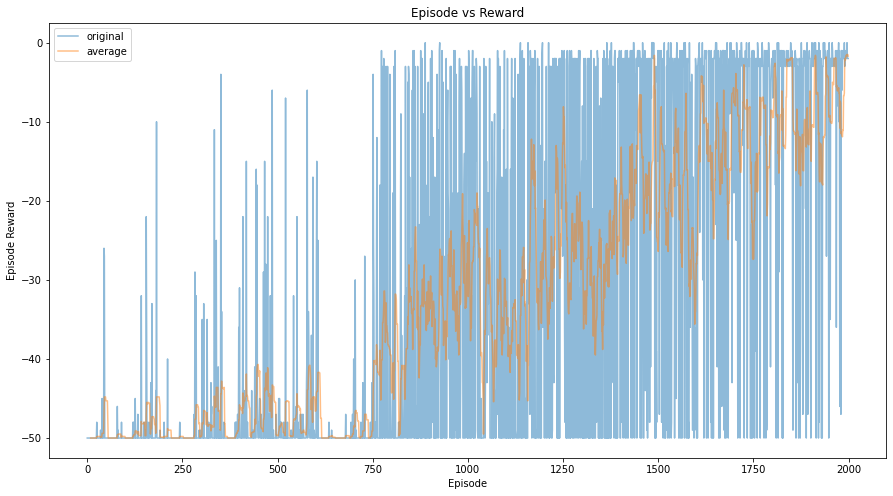

In [18]:
# plot stats
print(t2-t1)
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.figure(figsize=(15,8))
plt.plot(episode, r, alpha = 0.5, label='original')
plt.plot(episode[-len(cum_r):], cum_r, alpha = 0.5, label='average')
plt.title('Episode vs Reward')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
i+=1
plt.savefig('image'+str(i)+'.png')